In [1]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns; sns.set()
import sys


# 1. Data Cleaning

In [2]:
### PLEASE CHANGE THE WORKING/FILE DIRECTORY! THANK YOU
#Set the working directory
os.chdir('C:\\Users\\piotr\\OneDrive - Erasmus University Rotterdam\\Documents\\Github repositories\\group-project-2023-project-group-7')

In [3]:
# Set up for date parser
date_cols_org = ['founded_at', 'first_funding_at', 'last_funding_at']
date_cols_inv_rd = ['funded_at']
date_cols_aq = ['acquired_at']

In [164]:
### PLEASE CHANGE THE WORKING/FILE DIRECTORY! THANK YOU
# Load the data
df_aq = pd.read_csv('data\\acquisitions.csv', low_memory=False, parse_dates=date_cols_aq)
df_inv = pd.read_csv('data\\investments.csv', parse_dates=date_cols_inv_rd)
df_org = pd.read_csv('data\\organisations.csv', parse_dates=date_cols_org)
df_rd = pd.read_csv('data\\rounds.csv', parse_dates=date_cols_inv_rd)

In [5]:
# Get the shapes
print('Aquisitions: ', df_aq.shape)
print('Investments: ', df_inv.shape)
print('Organizations: ', df_org.shape)
print('Rounds: ', df_rd.shape)

Aquisitions:  (55240, 22)
Investments:  (114506, 24)
Organizations:  (28729, 15)
Rounds:  (83870, 17)


### Cleaning

In [6]:
# Clean column names - get rid of extra whitespaces
df_rd = df_rd.rename(columns=lambda x: x.strip())
df_aq = df_aq.rename(columns=lambda x: x.strip())
df_org = df_org.rename(columns=lambda x: x.strip())
df_inv = df_inv.rename(columns=lambda x: x.strip())

In [7]:
# Convert string numerical values into floats
df_inv['raised_amount_usd'] = df_inv['raised_amount_usd'].str.replace(',', '')
df_inv['raised_amount_usd'] = pd.to_numeric(df_inv['raised_amount_usd'], errors='coerce')

df_rd['raised_amount_usd'] = df_rd['raised_amount_usd'].str.replace(',', '')
df_rd['raised_amount_usd'] = pd.to_numeric(df_rd['raised_amount_usd'], errors='coerce')

df_aq['price_amount'] = df_aq['price_amount'].str.replace(',', '')
df_aq['price_amount'] = pd.to_numeric(df_aq['price_amount'], errors='coerce')

In [8]:
# Delete redundant column
df_rd = df_rd.drop(columns=['Unnamed: 16'], axis=1)

In [9]:
# Create variables on quarters/months 
df_inv['funded_month'] = df_inv['funded_month'].str[-2:]
df_inv['funded_quarter'] = df_inv['funded_quarter'].str[-2:]

df_aq['acquired_month'] = df_aq['acquired_month'].str[-2:]
df_aq['acquired_quarter'] = df_aq['acquired_quarter'].str[-2:]

df_rd['funded_month'] = df_rd['funded_month'].str[-2:]
df_rd['funded_quarter'] = df_rd['funded_quarter'].str[-2:]

In [10]:
# Fix the datetime format
df_org['founded_at'] = pd.to_datetime(df_org['founded_at'], format = '%Y-%m-%d')
df_inv['funded_year'] = pd.to_datetime(df_inv['funded_year'], format='%Y')
df_aq['acquired_year'] = pd.to_datetime(df_aq['acquired_year'], format='%Y')

In [11]:
# Why is the fix not working for this one?
for i, item in enumerate(df_aq['acquired_at']):
    try:
        pd.to_datetime(pd.Series(item))
    except ValueError:
        print(f'ERROR at index {i}')

ERROR at index 3093
ERROR at index 11206


In [12]:
# Manual fix - Dat found the erronous data points and an answer 
df_aq.loc[3093,'acquired_at'] = '2014-09-30'
df_aq.loc[11206, 'acquired_at'] = '2014-11-17'

In [13]:
# Now the conversion should work
df_aq['acquired_at']= pd.to_datetime(df_aq['acquired_at'], format = '%Y-%m-%d')

### Empty rows and duplicates

In [14]:
# Get the shapes
print('Aquisitions: ', df_aq.shape)
print('Investments: ', df_inv.shape)
print('Organizations: ', df_org.shape)
print('Rounds: ', df_rd.shape)

Aquisitions:  (55240, 22)
Investments:  (114506, 24)
Organizations:  (28729, 15)
Rounds:  (83870, 16)


In [15]:
# Drop rows that are fully empty
df_aq.dropna(axis=0, how='all', inplace=True)
df_inv.dropna(axis=0, how='all', inplace=True)
df_org.dropna(axis=0, how='all', inplace=True)
df_rd.dropna(axis=0, how='all', inplace=True)

In [16]:
# Get the shapes
print('Aquisitions: ', df_aq.shape)
print('Investments: ', df_inv.shape)
print('Organizations: ', df_org.shape)
print('Rounds: ', df_rd.shape)

Aquisitions:  (13070, 22)
Investments:  (114506, 24)
Organizations:  (28729, 15)
Rounds:  (83870, 16)


In [17]:
print('Fully duplicated rows')
print('AQ', df_aq.duplicated().sum())
print('INV', df_inv.duplicated().sum())
print('ORG', df_org.duplicated().sum())
print('RD', df_rd.duplicated().sum())

Fully duplicated rows
AQ 58
INV 0
ORG 0
RD 0


In [18]:
# Getting rid of 58 full duplicates
df_aq.drop_duplicates(inplace=True)

## Imputing each dataset separately and merging

### Organizations dataset

In [19]:
df_org.isna().sum()

permalink               0
name                    0
homepage_url         1166
category_list         831
market                833
funding_total_usd       0
status                644
country_code            0
state_code           8415
region                  0
city                    0
funding_rounds          0
founded_at              0
first_funding_at        0
last_funding_at         0
dtype: int64

This is the base dataset that all of the other datasets will be merged to. For now we will take care of the missing variables for state code and market. Status will be filled in once we merge the organisations and acquisitions dataset.  

In [20]:
# checking for any missing variables for market, but which have a category list and imputing based on that
df_org[(df_org['market'].isna()) & (df_org['category_list'].notnull())]

,permalink,name,homepage_url,category_list,market,funding_total_usd,status,country_code,state_code,region,city,funding_rounds,founded_at,first_funding_at,last_funding_at
11005,/organization/high-brew-coffee,High Brew Coffee,http://highbrewcoffee.com,|Consumer Goods|Coffee|Brewing|,NaN,4400000.0,operating,USA,TX,Austin,Austin,1,2013-01-01,2014-08-28,2014-08-28
13247,/organization/klique,Klique,http://www.klique.com,|Group Email|Group SMS|Social Media|,NaN,2075000.0,operating,USA,FL,"Naples, Florida",Naples,1,2013-01-01,2014-04-07,2014-04-07


In [21]:
df_org.loc[11005, 'market'] = 'Coffee'
df_org.loc[13247, 'market'] = 'Group SMS'
df_org['market'].fillna('Unknown', inplace = True)

In [22]:
# we notice that the state code is missing for non-US countries so we impute that data in
df_org['state_code'].fillna('non-US', inplace = True)

### Rounds dataset

Since we are getting these datasets ready for merging, we subset it on the data that will be added to the organisations dataset. The other datapoints are already included in the organisations dataset.

In [23]:
rounds_sub = ['company_permalink', 'funding_round_permalink', 'funding_round_type', 'funding_round_code', 'funded_at', 'funded_month', 'funded_quarter', 'funded_year', 'raised_amount_usd']
df_rd_sub = df_rd[rounds_sub]

In [24]:
df_rd_sub.isna().sum()

company_permalink              0
funding_round_permalink        0
funding_round_type             0
funding_round_code         61000
funded_at                      0
funded_month                  10
funded_quarter                10
funded_year                   10
raised_amount_usd          12955
dtype: int64

All the missing information is filled in now except for raised_amount_usd, which will be filled in with the help of the organizations dataset. The funding month/quarter/year values are filled in from the date variable.

In [25]:
#imputing variables based on a Google search
df_rd_sub.loc[60, 'funded_at'] = '2014-11-26'
df_rd_sub.loc[2637, 'funded_at'] = '2014-06-20'
df_rd_sub.loc[11563, 'funded_at'] = '2020-11-19'
df_rd_sub.loc[24877, 'funded_at'] = '2011-10-20' 
df_rd_sub.loc[50199, 'funded_at'] = '2013-05-07'
df_rd_sub.loc[54020, 'funded_at'] = '2014-05-01'
df_rd_sub.loc[61572, 'funded_at'] = '2014-09-29'
df_rd_sub.loc[63245, 'funded_at'] = '2014-11-11'
df_rd_sub.loc[64605, 'funded_at'] = '2014-11-01'
df_rd_sub.loc[72904, 'funded_at'] = '2014-07-01'

In [26]:
df_rd_sub['funded_at']= pd.to_datetime(df_rd_sub['funded_at'], format = '%Y-%m-%d')

C:\Users\piotr\AppData\Local\Temp\ipykernel_24464\1530647838.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_rd_sub['funded_at']= pd.to_datetime(df_rd_sub['funded_at'], format = '%Y-%m-%d')


In [27]:
df_rd_sub['funded_month'] = df_rd_sub['funded_at'].dt.month
df_rd_sub['funded_year'] = df_rd_sub['funded_at'].dt.year
df_rd_sub['funded_quarter'] = df_rd_sub['funded_at'].dt.quarter

C:\Users\piotr\AppData\Local\Temp\ipykernel_24464\3765251328.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_rd_sub['funded_month'] = df_rd_sub['funded_at'].dt.month
C:\Users\piotr\AppData\Local\Temp\ipykernel_24464\3765251328.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_rd_sub['funded_year'] = df_rd_sub['funded_at'].dt.year
C:\Users\piotr\AppData\Local\Temp\ipykernel_24464\3765251328.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using

In [28]:
#filling in funding_round_code with the value unknown
df_rd_sub['funding_round_code'].fillna('Unknown', inplace = True)

C:\Users\piotr\AppData\Local\Temp\ipykernel_24464\3738850632.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_rd_sub['funding_round_code'].fillna('Unknown', inplace = True)


#### First merge - organisations and rounds dataset

In [29]:
# Merge
df_merge_1 = pd.merge(df_org, df_rd_sub, how='left', left_on='permalink', right_on='company_permalink')

# Remove duplicate column from the right table
df_merge_1.drop('company_permalink', axis=1, inplace=True)

In [30]:
# converting the raised amount variable to numeric
df_merge_1['raised_amount_usd'] = pd.to_numeric(df_merge_1['raised_amount_usd'], errors = 'coerce')

All the raised amounts should add up to the total funding. We make use of this fact to impute the missing values for this variable.  

In [31]:
# Create a new dataframe with the total amount raised per startup
startup_totals = df_merge_1.groupby('name')['raised_amount_usd'].sum()

# Calculate the difference between the total funding and the total amount raised for each startup
diff = df_merge_1.groupby('name')['funding_total_usd'].unique() - startup_totals

# Fill in the missing values with the calculated difference
df_merge_1['raised_amount_usd'].fillna(df_merge_1['name'].map(diff[[0]]).fillna(0), inplace=True)

In [32]:
df_merge_1.shape

(57303, 23)

### Acquisitions dataset

Only a subset of these variable will be used for the modelling from the dataset as many are already included in the original organisation dataset (i.e. company information). 

In [33]:
acquisitions_sub = ['company_permalink', 'acquirer_permalink', 'acquirer_name', 'acquirer_category_list', 'acquirer_market', 
                    'acquirer_country_code', 'acquirer_state_code', 'acquirer_region', 'acquirer_city', 'acquired_at', 
                    'acquired_month', 'acquired_quarter', 'acquired_year', 'price_amount', 'price_currency_code']

df_aq_sub = df_aq[acquisitions_sub]

In [34]:
df_aq_sub.isna().sum() 

company_permalink            0
acquirer_permalink           0
acquirer_name                0
acquirer_category_list    1500
acquirer_market           1506
acquirer_country_code      839
acquirer_state_code       3280
acquirer_region            839
acquirer_city              958
acquired_at                  0
acquired_month               2
acquired_quarter             2
acquired_year                2
price_amount              9310
price_currency_code          4
dtype: int64

In [35]:
# checking for any cases where the market information is missing but the category list info is not and using that to fill in the values
df_aq_sub[(df_aq_sub['acquirer_market'].isna()) & (df_aq_sub['acquirer_category_list'].notnull())]

,company_permalink,acquirer_permalink,acquirer_name,acquirer_category_list,acquirer_market,acquirer_country_code,acquirer_state_code,acquirer_region,acquirer_city,acquired_at,acquired_month,acquired_quarter,acquired_year,price_amount,price_currency_code
4601,/organization/gastronauci-pl,/organization/zomato,Zomato,|Hospitality|Local Search|Restaurants|Content ...,NaN,IND,NaN,New Delhi,Gurgaon,2014-09-23,09,Q3,2014-01-01,NaN,USD
4931,/organization/greencrest-capital,/organization/oppenheimer-co-inc,"Oppenheimer & Co., Inc.",|Financial Services|,NaN,USA,NY,New York City,New York,2013-11-21,11,Q4,2013-01-01,NaN,USD
6738,/organization/lunchtime,/organization/zomato,Zomato,|Hospitality|Local Search|Restaurants|Content ...,NaN,IND,NaN,New Delhi,Gurgaon,2014-08-22,08,Q3,2014-01-01,NaN,USD
7080,/organization/menu-mania,/organization/zomato,Zomato,|Hospitality|Local Search|Restaurants|Content ...,NaN,IND,NaN,New Delhi,Gurgaon,2014-07-01,07,Q3,2014-01-01,NaN,USD
8091,/organization/obedovat,/organization/zomato,Zomato,|Hospitality|Local Search|Restaurants|Content ...,NaN,IND,NaN,New Delhi,Gurgaon,2014-08-22,08,Q3,2014-01-01,NaN,USD
8986,/organization/power-loft,/organization/copt,COPT,|Real Estate|,NaN,USA,MD,Baltimore,Columbia,2010-09-17,09,Q3,2010-01-01,NaN,USD


In [36]:
df_aq_sub.loc[4601, 'acquirer_market'] = 'Hospitality'
df_aq_sub.loc[4931, 'acquirer_market'] = 'Financial Services'
df_aq_sub.loc[6738, 'acquirer_market'] = 'Hospitality'
df_aq_sub.loc[7080, 'acquirer_market'] = 'Hospitality'
df_aq_sub.loc[8091, 'acquirer_market'] = 'Hospitality'
df_aq_sub.loc[8986, 'acquirer_market'] = 'Real Estate'

We can fill in the few missing month/year/quarter values with the acquired date variable. 

In [37]:
# Fix the datetime format
df_aq_sub['acquired_month'] = df_aq_sub['acquired_at'].dt.month
df_aq_sub['acquired_year'] = df_aq_sub['acquired_at'].dt.year
df_aq_sub['acquired_quarter'] = df_aq_sub['acquired_at'].dt.quarter

C:\Users\piotr\AppData\Local\Temp\ipykernel_24464\3797794380.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_aq_sub['acquired_month'] = df_aq_sub['acquired_at'].dt.month
C:\Users\piotr\AppData\Local\Temp\ipykernel_24464\3797794380.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_aq_sub['acquired_year'] = df_aq_sub['acquired_at'].dt.year
C:\Users\piotr\AppData\Local\Temp\ipykernel_24464\3797794380.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
T

The remaining missing values are filled with the term 'unknown'. 

In [38]:
df_aq_sub['acquirer_market'].fillna('Unknown', inplace = True)
df_aq_sub['acquirer_category_list'].fillna('Unknown', inplace = True)

#where the value is missing and the acquirer country code is not empty - should happen only for non-US countries
df_aq_sub['acquirer_state_code'] = np.where((df_aq_sub['acquirer_country_code'].notnull()) & 
                                            (df_aq_sub['acquirer_state_code'].isna()), 'non-US', df_aq_sub['acquirer_state_code'])
#fill the rest with unknown
df_aq_sub['acquirer_state_code'].fillna('Unknown', inplace = True)
df_aq_sub['acquirer_country_code'].fillna('Unknown', inplace = True)
df_aq_sub['acquirer_region'].fillna('Unknown', inplace = True)
df_aq_sub['acquirer_city'].fillna('Unknown', inplace = True)
df_aq_sub['price_currency_code'].fillna('Unknown', inplace = True)

C:\Users\piotr\AppData\Local\Temp\ipykernel_24464\1981680092.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_aq_sub['acquirer_market'].fillna('Unknown', inplace = True)
C:\Users\piotr\AppData\Local\Temp\ipykernel_24464\1981680092.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_aq_sub['acquirer_category_list'].fillna('Unknown', inplace = True)
C:\Users\piotr\AppData\Local\Temp\ipykernel_24464\1981680092.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://panda

#### Second merge - previous dataset and acquisitions

In [39]:
df_merge_2 = pd.merge(df_merge_1, df_aq_sub, how = 'left', left_on = 'permalink', right_on = 'company_permalink')
df_merge_2.drop('company_permalink', axis = 1, inplace = True)

In [40]:
df_merge_2.shape

(57470, 37)

In [41]:
df_merge_1.shape

(57303, 23)

Comparing the number of rows between the two datasets, we see the number of rows increased slightly. This is because some companies have multiple acquirers.

In [42]:
df_merge_2.isna().sum()

permalink                      0
name                           0
homepage_url                1562
category_list               1001
market                         0
funding_total_usd              0
status                      1193
country_code                   0
state_code                     0
region                         0
city                           0
funding_rounds                 0
founded_at                     0
first_funding_at               0
last_funding_at                0
funding_round_permalink       10
funding_round_type            10
funding_round_code            10
funded_at                     10
funded_month                  10
funded_quarter                10
funded_year                   10
raised_amount_usd              0
acquirer_permalink         51614
acquirer_name              51614
acquirer_category_list     51614
acquirer_market            51614
acquirer_country_code      51614
acquirer_state_code        51614
acquirer_region            51614
acquirer_c

### Investments dataset

In [43]:
inv_sub = ['funding_round_permalink', 'investor_permalink', 'investor_name', 
           'investor_country_code', 'investor_region', 'investor_city']
df_inv_sub = df_inv[inv_sub]

In [44]:
df_inv_sub.isna().sum()

funding_round_permalink        0
investor_permalink            66
investor_name                 66
investor_country_code      27985
investor_region            27985
investor_city              28499
dtype: int64

Based on the variables on display here, only two of the variables would be actually used in the final modelling phase - investor country code and investor region. Let's also check whether there are any cases where the city is known but the region is not.

In [45]:
df_inv_sub[(df_inv_sub['investor_region'].isna()) & (df_inv_sub['investor_city'].notnull())]

,funding_round_permalink,investor_permalink,investor_name,investor_country_code,investor_region,investor_city


It seems that is never the case. This means we can go ahead and drop the missing observations for investor country code and investor region, since these add no value.

In [46]:
df_inv_sub.dropna(subset = ['investor_region'], axis = 0, inplace = True)

C:\Users\piotr\AppData\Local\Temp\ipykernel_24464\502957779.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_inv_sub.dropna(subset = ['investor_region'], axis = 0, inplace = True)


There are only a few missing values for investor city, which can again be filled by unknown.

In [47]:
df_inv_sub['investor_city'].fillna('Unknown', inplace = True)

C:\Users\piotr\AppData\Local\Temp\ipykernel_24464\4014632715.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_inv_sub['investor_city'].fillna('Unknown', inplace = True)


### Creating the final dataset

In [48]:
df_full = pd.merge(df_merge_2, df_inv_sub, how = 'left', on = 'funding_round_permalink')

In [49]:
df_full.shape

(92985, 42)

In [50]:
# Fully empty rows at this point?
df_full.dropna(how='all', inplace=True)

In [51]:
df_full.shape # none of the rows are fully empty now

(92985, 42)

In [52]:
df_full.isna().sum()

permalink                      0
name                           0
homepage_url                2413
category_list               1101
market                         0
funding_total_usd              0
status                      1640
country_code                   0
state_code                     0
region                         0
city                           0
funding_rounds                 0
founded_at                     0
first_funding_at               0
last_funding_at                0
funding_round_permalink       10
funding_round_type            10
funding_round_code            10
funded_at                     10
funded_month                  10
funded_quarter                10
funded_year                   10
raised_amount_usd              0
acquirer_permalink         80443
acquirer_name              80443
acquirer_category_list     80443
acquirer_market            80443
acquirer_country_code      80443
acquirer_state_code        80443
acquirer_region            80443
acquirer_c

To summarize, out of these variables, the ones we may want to use in the actual modelling and have missing values are:
- status
- funding round type
- funding round code
- funded month
- funded quarter
- funded year
- acquirer market
- acquirer country code
- acquirer region 
- acquired month
- acquired quarter
- acquired year
- investor country code
- investor region

#### Imptutation of the remaining missing variables in our merged dataset

In [53]:
# if `raised_amount_usd`` is larger than 0 and `status` is n/a - fill with string "acquired"
df_full['status'] = np.where((df_full['acquirer_permalink'].notnull()) & (df_full['status'].isna()), 'acquired', df_full['status'])

# for the rest of the empty status - change to unknown
df_full['status'] = np.where(df_full['status'].isna(), 'Unknown', df_full['status'])

In [54]:
#drop the 10 observations with a missing funding round permalink and other info
df_full.dropna(subset = ['funding_round_permalink'], axis = 0, inplace = True)

In [55]:
# fill in the other modeling variables with none using regular expressions
import re

col_names = list(df_full.columns)
r = re.compile('acquirer\S+|investor\S+')
to_fill = list(filter(r.match, col_names))
to_fill

df_full[to_fill] = df_full[to_fill].fillna('None')

In [56]:
df_full.isna().sum()

permalink                      0
name                           0
homepage_url                2413
category_list               1101
market                         0
funding_total_usd              0
status                         0
country_code                   0
state_code                     0
region                         0
city                           0
funding_rounds                 0
founded_at                     0
first_funding_at               0
last_funding_at                0
funding_round_permalink        0
funding_round_type             0
funding_round_code             0
funded_at                      0
funded_month                   0
funded_quarter                 0
funded_year                    0
raised_amount_usd              0
acquirer_permalink             0
acquirer_name                  0
acquirer_category_list         0
acquirer_market                0
acquirer_country_code          0
acquirer_state_code            0
acquirer_region                0
acquirer_c

In [57]:
# filling in the price information - the price amount where the acquirer information is missing is kept empty for now
df_full['price_currency_code'].fillna('None', inplace = True)
df_full['price_amount'] = np.where((df_full['acquired_at'].isna()) & (df_full['price_amount'].isna()), 0, df_full['price_amount'])

In [58]:
# Drop empty rows that are left
df_full.dropna(how = 'all', inplace=True)

df_full.reset_index(inplace=True, drop=True)

In [59]:
# What are we working with now in terms of observations and features?
df_full.shape

(92975, 42)

#### Reorder columns for convenience

In [60]:
for i, col in enumerate(df_full.columns):
    print(i, col)

0 permalink
1 name
2 homepage_url
3 category_list
4 market
5 funding_total_usd
6 status
7 country_code
8 state_code
9 region
10 city
11 funding_rounds
12 founded_at
13 first_funding_at
14 last_funding_at
15 funding_round_permalink
16 funding_round_type
17 funding_round_code
18 funded_at
19 funded_month
20 funded_quarter
21 funded_year
22 raised_amount_usd
23 acquirer_permalink
24 acquirer_name
25 acquirer_category_list
26 acquirer_market
27 acquirer_country_code
28 acquirer_state_code
29 acquirer_region
30 acquirer_city
31 acquired_at
32 acquired_month
33 acquired_quarter
34 acquired_year
35 price_amount
36 price_currency_code
37 investor_permalink
38 investor_name
39 investor_country_code
40 investor_region
41 investor_city


In [61]:
# Here the relevant columns are placed in front of the data frame so that they can be excluded in one line

cols_order = [df_full.columns[0], # permalink
             df_full.columns[1], # name
             df_full.columns[2], # homepage_url
             df_full.columns[3], # category_list
             df_full.columns[8], # state_code
             df_full.columns[12], # founded_at
             df_full.columns[13], # first_funding_at
             df_full.columns[14], # last_funding_at
             df_full.columns[15], # funding_round_permalink
             df_full.columns[18], # funded_at
             *df_full.columns[23:30], #acquirer identification
             #df_full.columns[28], #state code
             *df_full.columns[30:32], #acquirer city, date
             *df_full.columns[32:35], #acquirer date information - for now keeping it here until figured out how to use it
             *df_full.columns[37:39], # investor_permalink, name
             #df_full.columns[41], # investor_city
             df_full.columns[5], # funding_total_usd
             df_full.columns[4], *df_full.columns[6:8], *df_full.columns[9:12], *df_full.columns[16:18], *df_full.columns[19:23],*df_full.columns[35:37], *df_full.columns[39:42]] # the rest


df_reordered = df_full[cols_order]
df_reordered.shape

(92975, 42)

In [62]:
df_reordered.isna().sum()

permalink                      0
name                           0
homepage_url                2413
category_list               1101
state_code                     0
founded_at                     0
first_funding_at               0
last_funding_at                0
funding_round_permalink        0
funded_at                      0
acquirer_permalink             0
acquirer_name                  0
acquirer_category_list         0
acquirer_market                0
acquirer_country_code          0
acquirer_state_code            0
acquirer_region                0
acquirer_city                  0
acquired_at                80433
acquired_month             80433
acquired_quarter           80433
acquired_year              80433
investor_permalink             0
investor_name                  0
funding_total_usd              0
market                         0
status                         0
country_code                   0
region                         0
city                           0
funding_ro

In [63]:
df_reordered

,permalink,name,homepage_url,category_list,state_code,founded_at,first_funding_at,last_funding_at,funding_round_permalink,funded_at,...,funding_round_code,funded_month,funded_quarter,funded_year,raised_amount_usd,price_amount,price_currency_code,investor_country_code,investor_region,investor_city
0,/organization/waywire,#waywire,http://www.waywire.com,|Entertainment|Politics|Social Media|News|,NY,2012-06-01,2012-06-30,2012-06-30,/funding-round/cc409188fa2b63482bd9008f682c2efa,2012-06-30,...,Unknown,6.0,2.0,2012.0,1750000.0,NaN,USD,USA,Los Angeles,Culver City
1,/organization/waywire,#waywire,http://www.waywire.com,|Entertainment|Politics|Social Media|News|,NY,2012-06-01,2012-06-30,2012-06-30,/funding-round/cc409188fa2b63482bd9008f682c2efa,2012-06-30,...,Unknown,6.0,2.0,2012.0,1750000.0,NaN,USD,USA,SF Bay Area,San Francisco
2,/organization/waywire,#waywire,http://www.waywire.com,|Entertainment|Politics|Social Media|News|,NY,2012-06-01,2012-06-30,2012-06-30,/funding-round/cc409188fa2b63482bd9008f682c2efa,2012-06-30,...,Unknown,6.0,2.0,2012.0,1750000.0,NaN,USD,USA,SF Bay Area,Palo Alto
3,/organization/rock-your-paper,'Rock' Your Paper,http://www.rockyourpaper.org,|Publishing|Education|,non-US,2012-10-26,2012-08-09,2012-08-09,/funding-round/f06b420775f7cb6c1541a9db526534bb,2012-08-09,...,Unknown,8.0,3.0,2012.0,40000.0,0.0,None,CHL,Santiago,Santiago
4,/organization/in-touch-network,(In)Touch Network,http://www.InTouchNetwork.com,|Electronics|Guides|Coffee|Restaurants|Music|i...,non-US,2011-04-01,2011-04-01,2011-04-01,/funding-round/33c3f135f05d7b734b8d7b7c8ae82647,2011-04-01,...,Unknown,4.0,2.0,2011.0,1500000.0,0.0,None,None,None,None
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
92970,/organization/x,[x+1],http://www.xplusone.com/,|Enterprise Software|,NY,1999-01-01,2008-06-01,2013-04-04,/funding-round/deb408bbd9f539af78ea69fb532ffa75,2011-01-03,...,B,1.0,1.0,2011.0,10000000.0,0.0,None,USA,SF Bay Area,Palo Alto
92971,/organization/x,[x+1],http://www.xplusone.com/,|Enterprise Software|,NY,1999-01-01,2008-06-01,2013-04-04,/funding-round/deb408bbd9f539af78ea69fb532ffa75,2011-01-03,...,B,1.0,1.0,2011.0,10000000.0,0.0,None,USA,Cincinnati,Cincinnati
92972,/organization/x,[x+1],http://www.xplusone.com/,|Enterprise Software|,NY,1999-01-01,2008-06-01,2013-04-04,/funding-round/deb408bbd9f539af78ea69fb532ffa75,2011-01-03,...,B,1.0,1.0,2011.0,10000000.0,0.0,None,USA,New York City,New York
92973,/organization/x,[x+1],http://www.xplusone.com/,|Enterprise Software|,NY,1999-01-01,2008-06-01,2013-04-04,/funding-round/deb408bbd9f539af78ea69fb532ffa75,2011-01-03,...,B,1.0,1.0,2011.0,10000000.0,0.0,None,USA,SF Bay Area,Santa Clara


# 2. Exploratory Data Analysis - Separate Data Sets

Key Insights from Exploratory Data Analysis:

ORGANIZATIONS & INVESTMENTS, GENERAL TRENDS FOR ALL DATA FRAMES:
	
COUNTRIES:

• Software has been the biggest market  in terms of number of start-ups funded.

• In the US, which is the biggest start-up market in the world by a great margin, most start-ups were founded in California, New York and Massachusetts.

MARKETS:

• Biotechnology sector has received the highest part of total financing over the years.

• TOP 10 markets have a great share in both: Number of start-ups founded and funding received.

FUNDING:

• Start-up funding is highly positively skewed. The amount of total funding received is varies from a few couple thousand USD to 5.7 bn USD.
 
• The level of start-up financing corresponded with the most significant macronomiceconomic events, such as dot-com bubble or the US financial crisis of 2008.


ROUNDS:
	
The mean raised amount has grown exponentially from round A to round H

In rounds that were classified as the following types:
	
Post IPO Debt

Secondary Market

Post IPO Equity

Private Equity

the mean raised amount was substantially higher than among other types.
	
ACQUISITIONS:

The mean acquisition price has decreased in the periods of economic downturn

Acquisition prices in the first quarter were much higher than in the other quarters

In [64]:
pd.set_option('display.max_columns', None)

## 2.1 Organisations

In [65]:
df_org.head(10)

,permalink,name,homepage_url,category_list,market,funding_total_usd,status,country_code,state_code,region,city,funding_rounds,founded_at,first_funding_at,last_funding_at
0,/organization/waywire,#waywire,http://www.waywire.com,|Entertainment|Politics|Social Media|News|,News,1750000.0,acquired,USA,NY,New York City,New York,1,2012-06-01,2012-06-30,2012-06-30
1,/organization/rock-your-paper,'Rock' Your Paper,http://www.rockyourpaper.org,|Publishing|Education|,Publishing,40000.0,operating,EST,non-US,Tallinn,Tallinn,1,2012-10-26,2012-08-09,2012-08-09
2,/organization/in-touch-network,(In)Touch Network,http://www.InTouchNetwork.com,|Electronics|Guides|Coffee|Restaurants|Music|i...,Electronics,1500000.0,operating,GBR,non-US,London,London,1,2011-04-01,2011-04-01,2011-04-01
3,/organization/r-ranch-and-mine,-R- Ranch and Mine,NaN,|Tourism|Entertainment|Games|,Tourism,60000.0,operating,USA,TX,Dallas,Fort Worth,2,2014-01-01,2014-08-17,2014-09-26
4,/organization/club-domains,.Club Domains,http://nic.club/,|Software|,Software,7000000.0,NaN,USA,FL,Ft. Lauderdale,Oakland Park,1,2011-10-10,2013-05-31,2013-05-31
5,/organization/1-2-3-listo,"1,2,3 Listo",http://www.123listo.com,|E-Commerce|,E-Commerce,40000.0,operating,CHL,non-US,Santiago,Las Condes,1,2012-01-01,2013-02-18,2013-02-18
6,/organization/10-minutes-with,10 Minutes With,http://10minuteswith.com,|Education|,Education,4400000.0,operating,GBR,non-US,London,London,2,2013-01-01,2013-01-01,2014-10-09
7,/organization/10-20-media,10-20 Media,http://www.10-20media.com,|E-Commerce|,E-Commerce,2050000.0,operating,USA,MD,Baltimore,Woodbine,4,2001-01-01,2009-06-18,2011-12-28
8,/organization/1000-corks,1000 Corks,http://1000corks.com,|Search|,Search,40000.0,operating,USA,OR,"Portland, Oregon",Lake Oswego,1,2008-01-01,2011-08-23,2011-08-23
9,/organization/1000memories,1000memories,http://1000memories.com,|Curated Web|,Curated Web,2535000.0,acquired,USA,CA,SF Bay Area,San Francisco,2,2010-07-01,2010-01-01,2011-02-16


### 2.1.1 Descriptive statistics

In [66]:
df_org.describe()

,funding_total_usd,funding_rounds
count,2.872900e+04,28729.000000
mean,1.572875e+07,1.994222
std,7.658772e+07,1.499803
min,1.400000e+01,1.000000
25%,4.000000e+05,1.000000
50%,2.075000e+06,1.000000
75%,1.025000e+07,2.000000
max,5.700000e+09,18.000000


### 2.1.2 Funding aquired by the startups

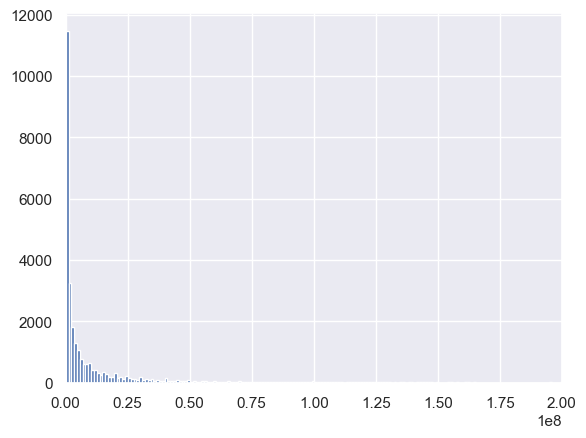

In [67]:
#Histogram of total funding aquired by the startups

fig=plt.figure()
ax = fig.add_subplot(1,1,1)
ax.hist(df_org['funding_total_usd'], bins = 5000)
ax.set_xlim(left=0, right=200000000);

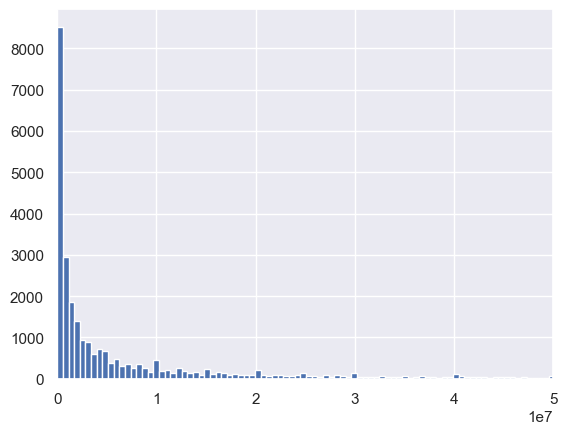

In [68]:
#Histogram of total funding aquired by the startups - zoom on the values smaller than 50000000 (50 mln USD)

fig=plt.figure()
ax = fig.add_subplot(1,1,1)
ax.hist(df_org['funding_total_usd'], bins = 10000)
ax.set_xlim(left=0, right=50000000);

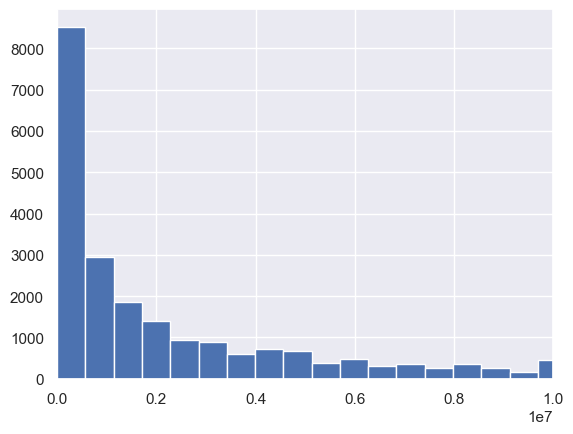

In [69]:
#Histogram of total funding aquired by the startups - zoom on the values smaller than 10000000 (10 mln USD)

fig=plt.figure()
ax = fig.add_subplot(1,1,1)
ax.hist(df_org['funding_total_usd'], bins = 10000)
ax.set_xlim(left=0, right=10000000);

The distribution of the total funding aquired by the start-ups is highly positively skewed, with median 2.08 of million USD much lower than the mean value of 15.73 million USD. A significant 'long tail' can be observed, with startups receiving much more funding than the average - the maximal value of total funding received is equal to 5.7 bn USD. Most of the startups took part in one or two funding rounds.

#### Start-ups that aquired the most funding

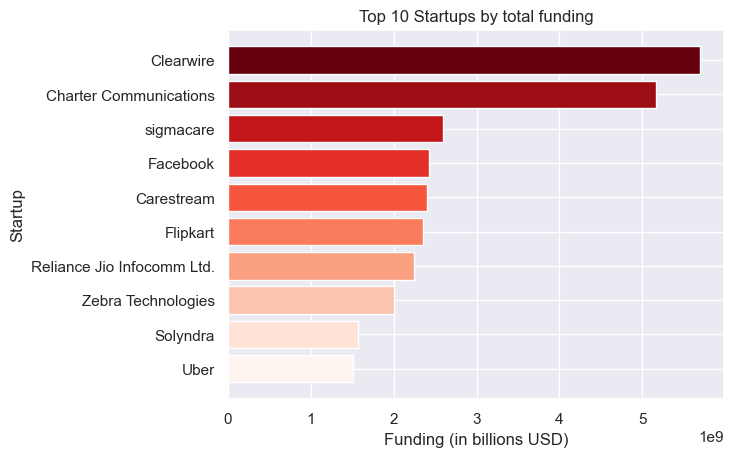

In [70]:
#Values of top 10 start-ups
top_10_startups = df_org.sort_values(by=['funding_total_usd'],ascending=False).head(10)
top_10_startups = top_10_startups.iloc[::-1]

#Create the bar plot
colors = plt.cm.get_cmap('Reds')(np.linspace(0, 1, len(top_10_startups)))
plt.barh(top_10_startups['name'], top_10_startups['funding_total_usd'], color=colors)
plt.xlabel('Funding (in billions USD)')
plt.ylabel('Startup')
plt.title('Top 10 Startups by total funding')
plt.show()

All the start-ups from the top 10 (in terms of total funding received) had raised funding exceeding 1 bn USD.

### 2.1.3 Status of the start-ups

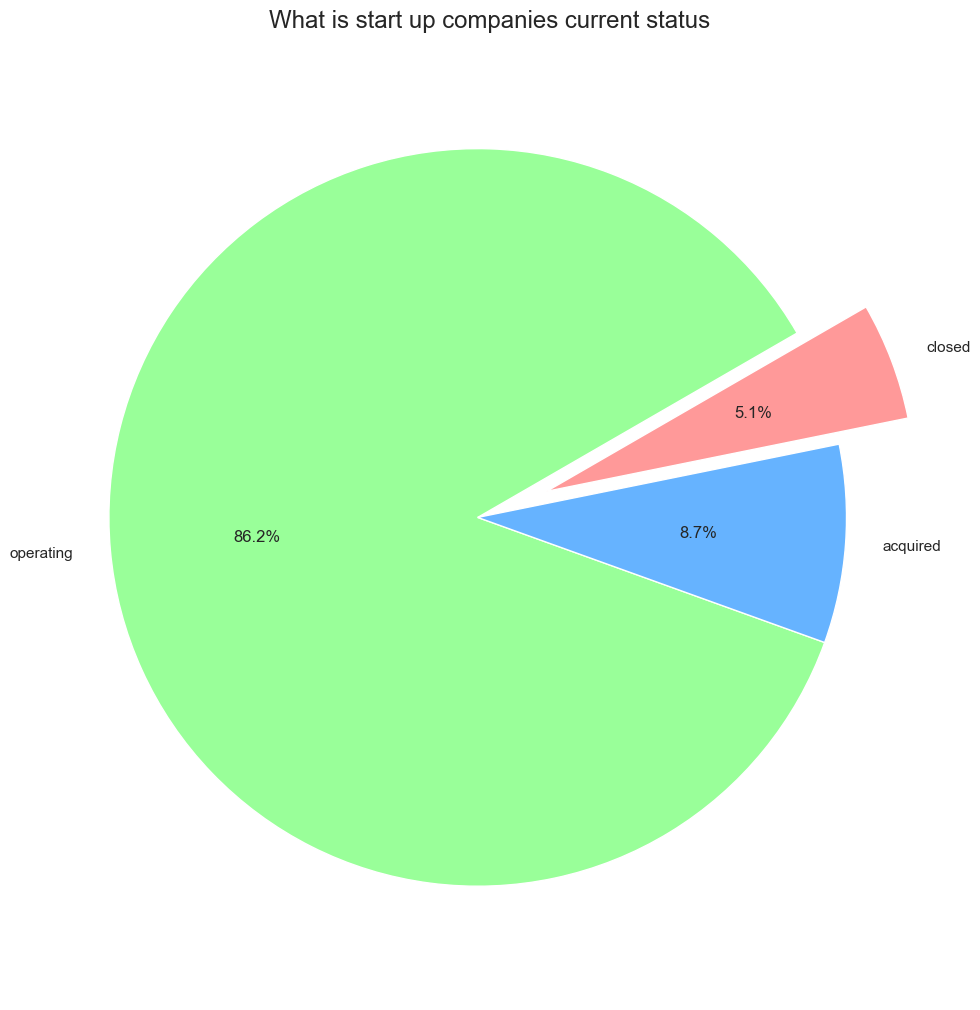

In [71]:
plt.rcParams['figure.figsize'] = 10,10
labels = df_org['status'].value_counts().index.tolist()
sizes = df_org['status'].value_counts().tolist()
explode = (0, 0, 0.2)
colors = ['#99ff99','#66b3ff','#ff9999']

plt.pie(sizes, explode=explode, labels=labels, colors=colors, autopct='%1.1f%%',
        shadow=False, startangle=30)
plt.axis('equal')
plt.tight_layout()
plt.title("What is start up companies current status", fontdict=None, position= [0.48,1], size = 'x-large')
plt.show()

It can be noted that the majority of start-ups are still operating (as for 2015), and more companies were acquired than suspended their operations.

### 2.1.4 The most common markets (industries)

In [72]:
len(df_org['market'].unique())

699

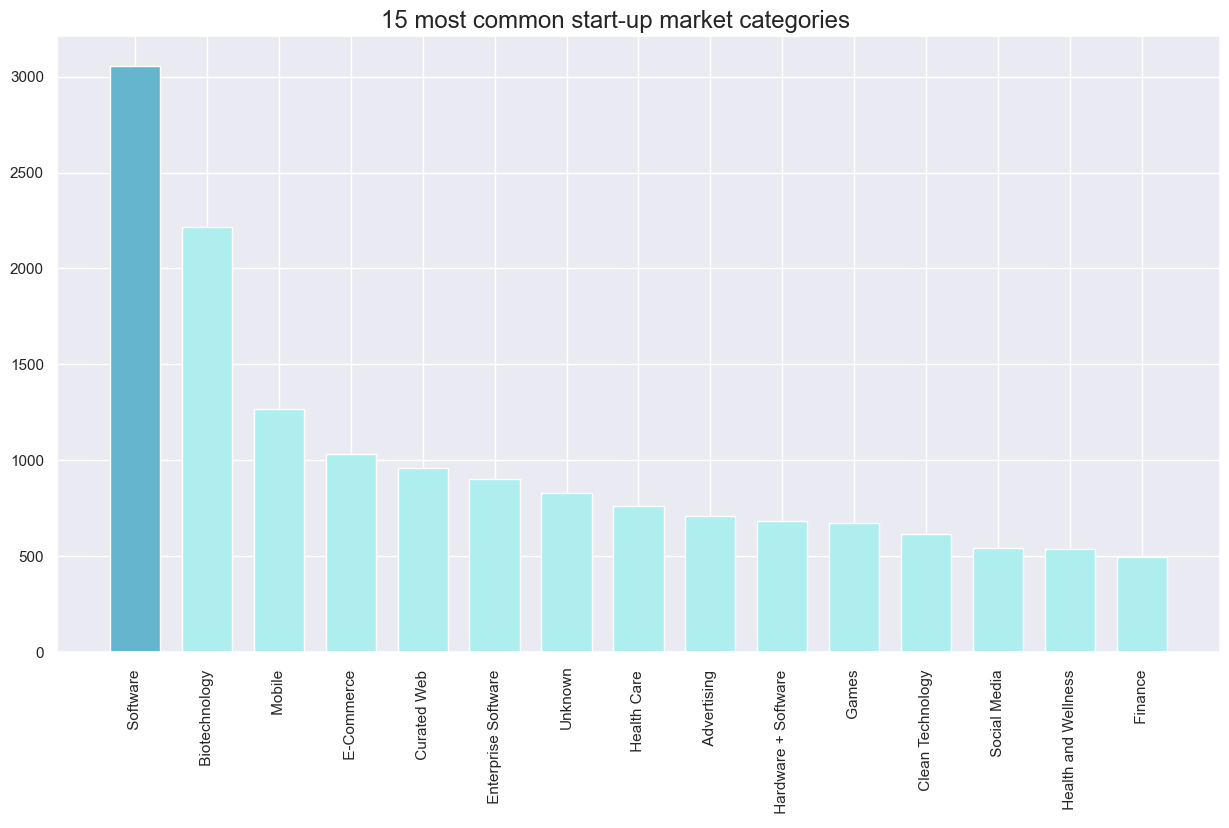

In [73]:
#Plot the 15 most common start-up market categories  
plt.rcParams['figure.figsize'] = 15,8
height = df_org['market'].value_counts()[:15].tolist()
bars =  df_org['market'].value_counts()[:15].index.tolist()
y_pos = np.arange(len(bars))
plt.bar(y_pos, height , width=0.7 ,color= ['c']+['paleturquoise']*14)
plt.xticks(y_pos, bars)
plt.xticks(rotation=90)
plt.title("15 most common start-up market categories", fontdict=None, position= [0.48,1.05], size = 'x-large')
plt.show()

In [74]:
df_org['count'] = 1
country_market = df_org[['count','country_code','market']].groupby(['country_code','market']).agg({'count': 'sum'})
country_market_pct = country_market.groupby(level=0).apply(lambda x: 100 * x / float(x.sum()))
country_market_pct.reset_index(inplace = True)

In [75]:
USA_market_pct = country_market_pct[country_market_pct['country_code'] == "USA"]
USA_market_pct = USA_market_pct.sort_values('count',ascending = False)[0:10]

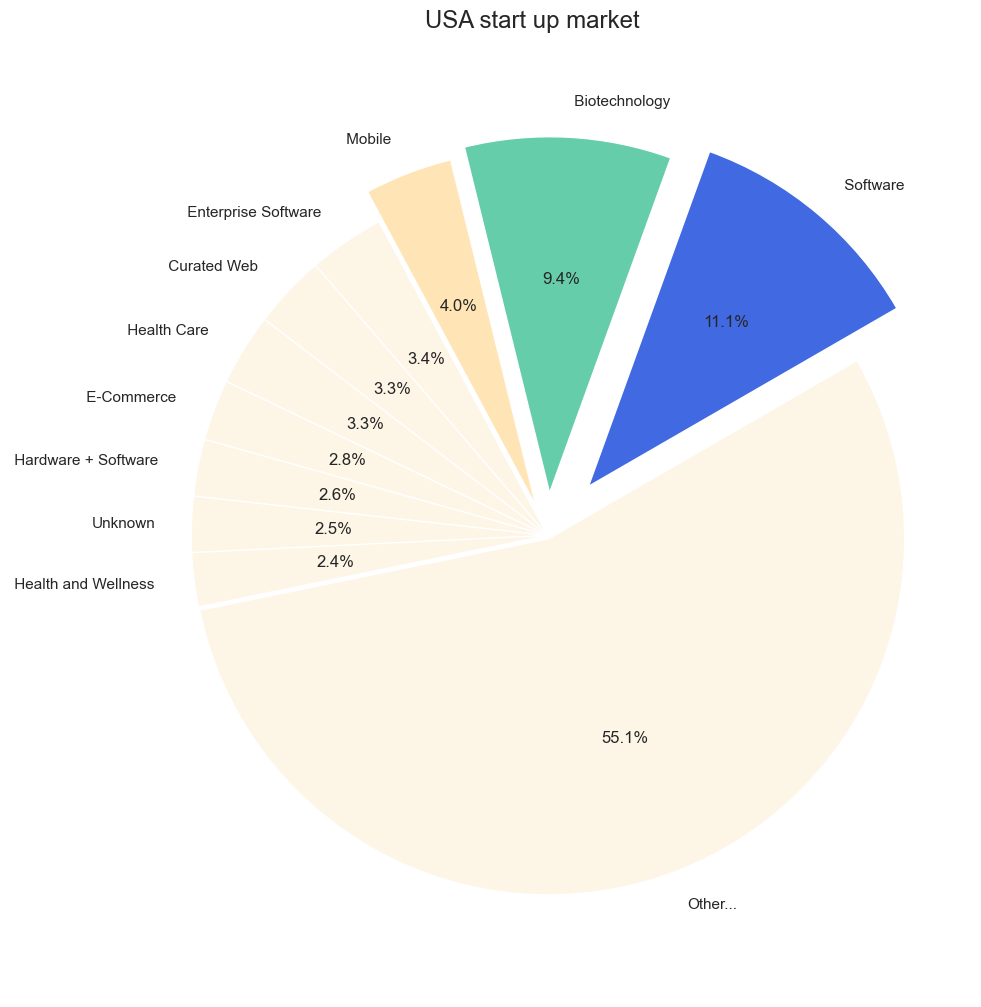

In [76]:
## Plot the breakdown of start-up market categories in the USA
plt.rcParams['figure.figsize'] =10,10
labels = list(USA_market_pct['market'])+['Other...']
sizes = list(USA_market_pct['count'])+[100-USA_market_pct['count'].sum()]
explode = (0.18, 0.12, 0.09,0,0,0,0,0,0,0,0.01)
colors =  ['royalblue','mediumaquamarine','moccasin'] +['oldlace']*8

plt.pie(sizes, explode = explode, colors = colors ,labels=labels, autopct='%1.1f%%',
        shadow=False, startangle=30)
plt.axis('equal')
plt.tight_layout()
plt.title("USA start up market", fontdict=None, position= [0.48,1.1], size = 'x-large')

plt.show()


On the charts above, the most common market categories for the global market and the American market were provided. Most of the startups both globally and on the US market were operating on Software, Biotechnology and Mobile markets.

#### The most and least successful start-ups (in terms of total funding raised)

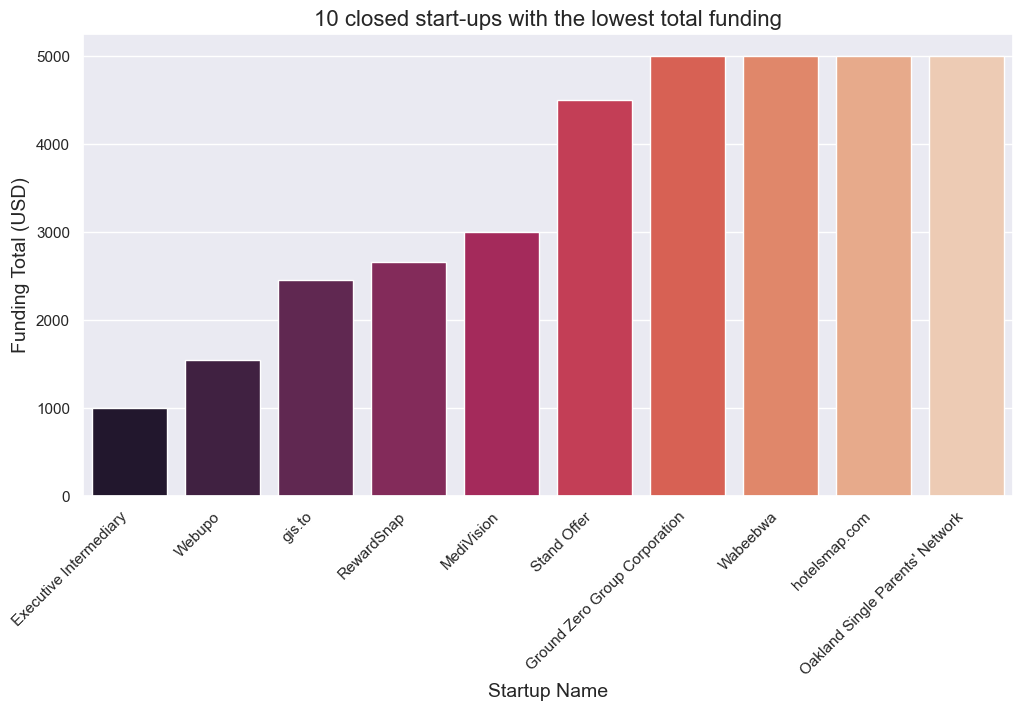

In [79]:
df_fail = df_org[df_org['status']=='closed']
df_top10_fail = df_fail.sort_values(by=['funding_total_usd'], ascending=True).head(10)
plt.figure(figsize=(12, 6))

sns.barplot(x='name', y='funding_total_usd', data=df_top10_fail, palette='rocket')
plt.title('10 closed start-ups with the lowest total funding', fontsize=16)
plt.xlabel('Startup Name', fontsize=14)
plt.ylabel('Funding Total (USD)', fontsize=14)
plt.xticks(rotation=45, ha='right')
plt.show()

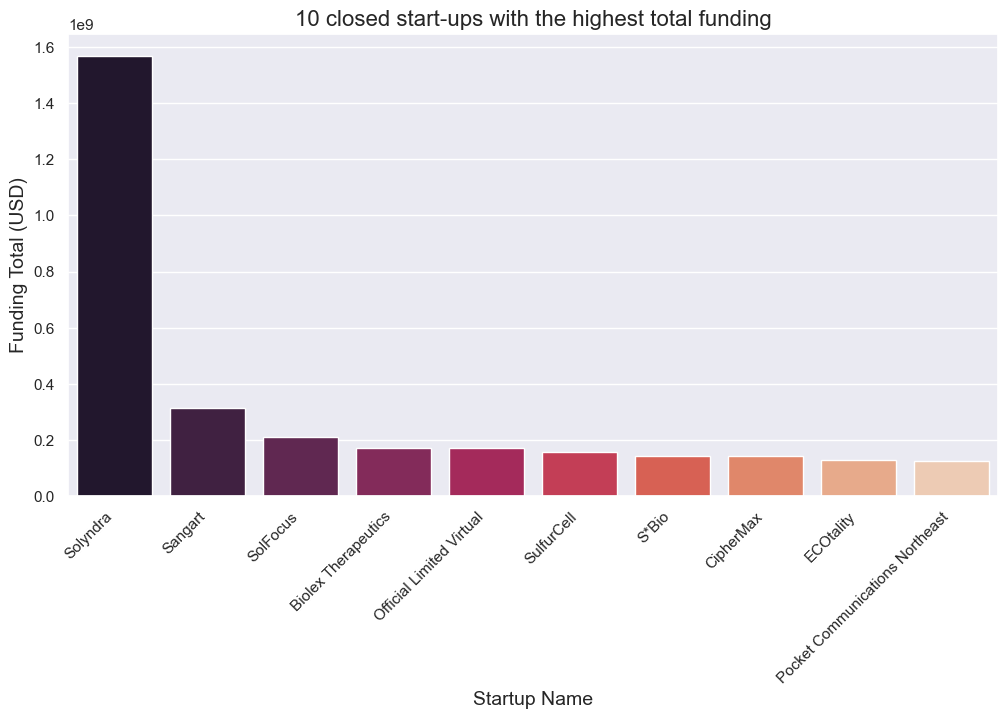

In [80]:
df_top = df_org[df_org['status']=='closed']
df_top10_top = df_fail.sort_values(by=['funding_total_usd'], ascending=False).head(10)

plt.figure(figsize=(12, 6))
sns.barplot(x='name', y='funding_total_usd', data=df_top10_top, palette='rocket')
plt.title('10 closed start-ups with the highest total funding', fontsize=16)
plt.xlabel('Startup Name', fontsize=14)
plt.ylabel('Funding Total (USD)', fontsize=14)
plt.xticks(rotation=45, ha='right')
plt.show()

A great disproportion between groups of closed start-ups that aquired the most and the least fudning can be observed. The first group did not survive on the market despite the funding exceeding 100 million USD, whilst the second group acquired only a few thousand dollars in total.  

### 2.1.5 Total start-up funding compared to different benchmarks

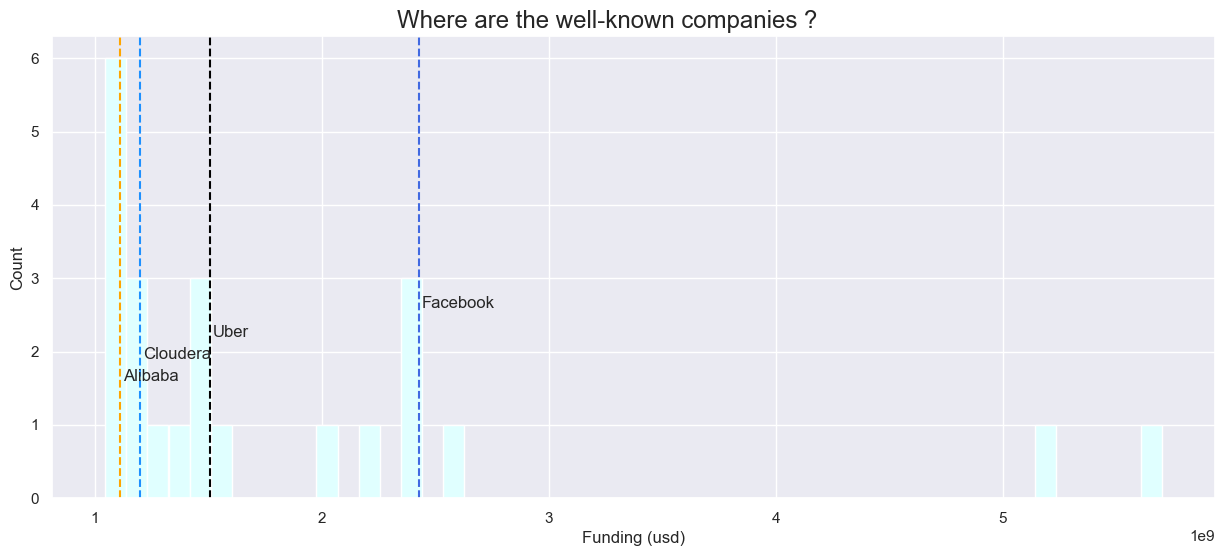

In [81]:
#Extract the total funding of the well-known companies 
Facebook_total_funding = df_org['funding_total_usd'][df_org['name']=="Facebook"].values[0]
Uber_total_funding = df_org['funding_total_usd'][df_org['name']=="Uber"].values[0]
Alibaba_total_funding = df_org['funding_total_usd'][df_org['name']=="Alibaba"].values[0]
Cloudera_total_funding = df_org['funding_total_usd'][df_org['name']=="Cloudera"].values[0]

plt.rcParams['figure.figsize'] = 15,6
plt.hist(df_org['funding_total_usd'][(df_org['funding_total_usd'] >= 1000000000)].dropna(), bins=50,color = 'lightcyan' )
plt.ylabel('Count')
plt.xlabel('Funding (usd)')
plt.title("Where are the well-known companies ? ", fontdict=None, position= [0.48,1.05], size = 'x-large')

#Add the values the well-known companies benchmarks
plt.axvline(Facebook_total_funding,color='royalblue',linestyle ="--")
plt.text(Facebook_total_funding+15000000, 2.6,"Facebook")

plt.axvline(Uber_total_funding,color='black',linestyle ="--")
plt.text(Uber_total_funding+10000000, 2.2,"Uber")

plt.axvline(Cloudera_total_funding,color='dodgerblue',linestyle ="--")
plt.text(Cloudera_total_funding+10000000, 1.9,"Cloudera")

plt.axvline(Alibaba_total_funding,color='orange',linestyle ="--")
plt.text(Alibaba_total_funding+10000000, 1.6,"Alibaba")


plt.show()

Among the companies that received more than 1 bn USD total funding, the chosen well-known companies are not the leaders.  Facebook which is in the top 5 of companies that received the most funding, and Uber closes the top 10.

In [82]:
#Change the type of 'founded_at' column
df_org['founded_at'] = pd.to_datetime(df_org['founded_at'])

### 2.1.6 When the companies were founded?

In [83]:
df_org['founded_at'] = pd.to_datetime(df_org['founded_at'], errors = 'coerce' )

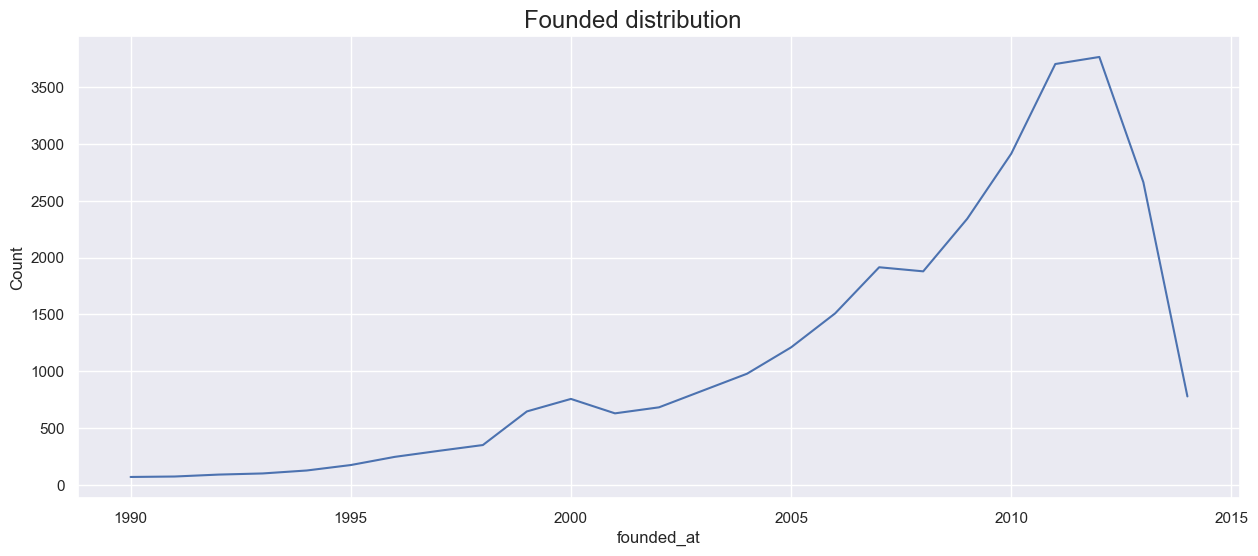

In [84]:
plt.rcParams['figure.figsize'] = 15,6
df_org['name'].groupby(df_org["founded_at"].dt.year).count().plot(kind="line")

plt.ylabel('Count')
plt.title("Founded distribution ", fontdict=None, position= [0.48,1.05], size = 'x-large')
plt.show()

Number of star-ups funded was growing till early 2010s, when it reached a peak and drasticly declined. The most companies were founded in 2011 and 2012.

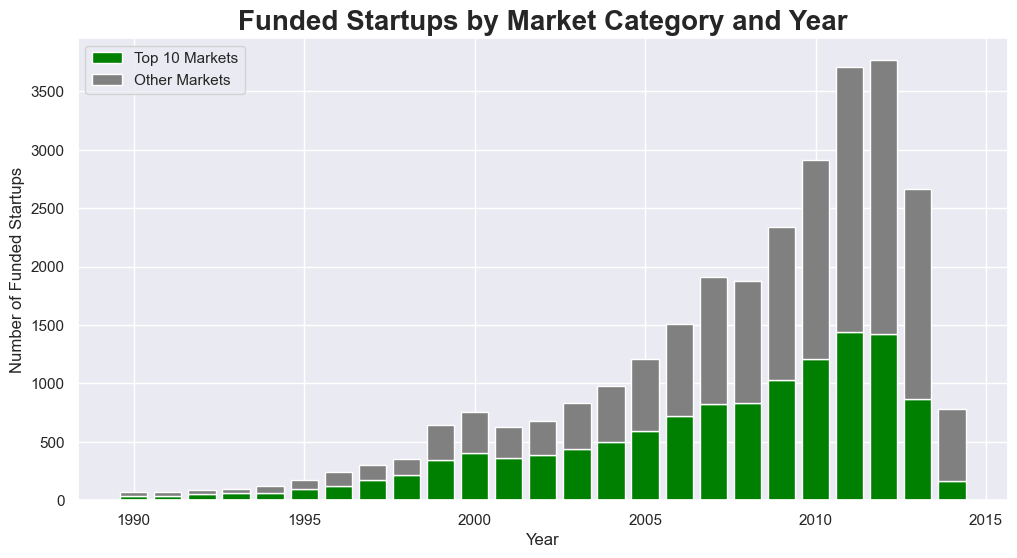

In [85]:

market_counts = df_org.groupby([df_org["founded_at"].dt.year, "market"])["name"].count().unstack(fill_value=0)
top_10_markets = market_counts.sum().nlargest(10).index.tolist()

#Additional column will represent categories outside the top 10, market as "other
market_counts["Other"] = market_counts.sum(axis=1) - market_counts[top_10_markets].sum(axis=1)

top_10_counts = market_counts[top_10_markets].sum(axis=1)
other_counts = market_counts["Other"]

# Plot it as a bar chart
fig, ax = plt.subplots(figsize=(12, 6))
ax.bar(top_10_counts.index, top_10_counts, color="green", label="Top 10 Markets")
ax.bar(other_counts.index, other_counts, bottom=top_10_counts, color="gray", label="Other Markets")

#Labels and formatting
ax.set_xlabel("Year")
ax.set_ylabel("Number of Funded Startups")
ax.set_title("Funded Startups by Market Category and Year", fontdict={'fontsize': 20, 'fontweight': 'bold', 'verticalalignment': 'baseline'}, loc='center')
ax.legend()

plt.show()

It can be noted that the top 10 markets accound for a vast part of all start-ups count in a given year - in some years around to the half of all companies founded. 

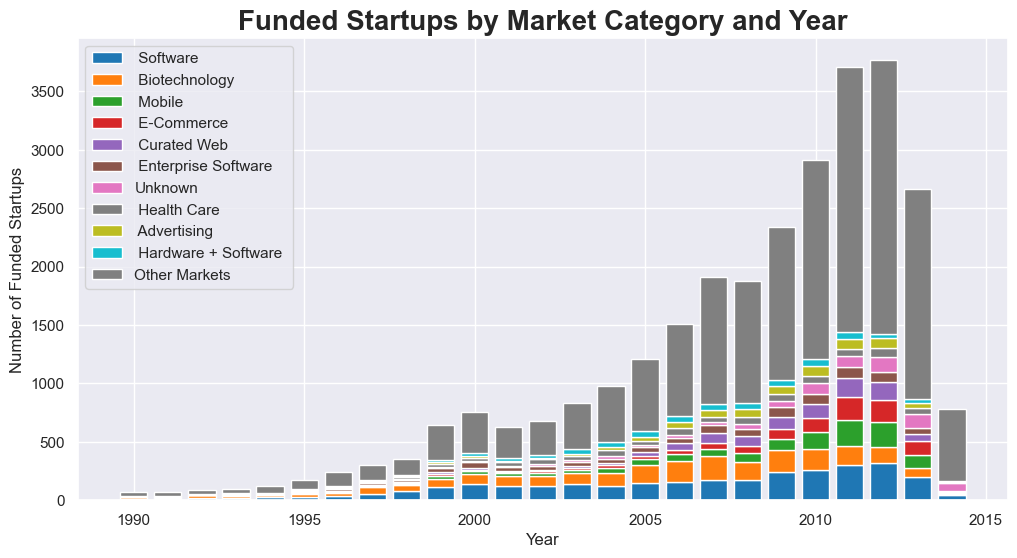

In [86]:
market_counts = df_org.groupby([df_org["founded_at"].dt.year, "market"])["name"].count().unstack(fill_value=0)

top_10_markets = market_counts.sum().nlargest(10).index.tolist()

for market in top_10_markets:
    market_counts[market] = market_counts[market] if market in market_counts.columns else 0
market_counts["Other"] = market_counts.sum(axis=1) - market_counts[top_10_markets].sum(axis=1)

fig, ax = plt.subplots(figsize=(12, 6))

#Separate the top 10 market categories on the plot
market_colors = plt.get_cmap('tab10').colors
for i, market in enumerate(top_10_markets):
    ax.bar(market_counts.index, market_counts[market], bottom=market_counts[top_10_markets[:i]].sum(axis=1), color=market_colors[i], label=market)
ax.bar(market_counts.index, market_counts["Other"], bottom=market_counts[top_10_markets].sum(axis=1), color="gray", label="Other Markets")

# Labels and formatting
ax.set_xlabel("Year")
ax.set_ylabel("Number of Funded Startups")

ax.set_title("Funded Startups by Market Category and Year", fontdict={'fontsize': 20, 'fontweight': 'bold', 'verticalalignment': 'baseline'}, loc='center')

ax.legend()

plt.show()


By breaking down the top 10 industries, it can be observed that the share of Software and Biotechnology market has been very significant from late 1990's until 2014. From around 2005 till 2014 the number of start-ups founded and oriented on Mobile market has increased dynamicly. 

#### How many companies were founded yearly given the economic events

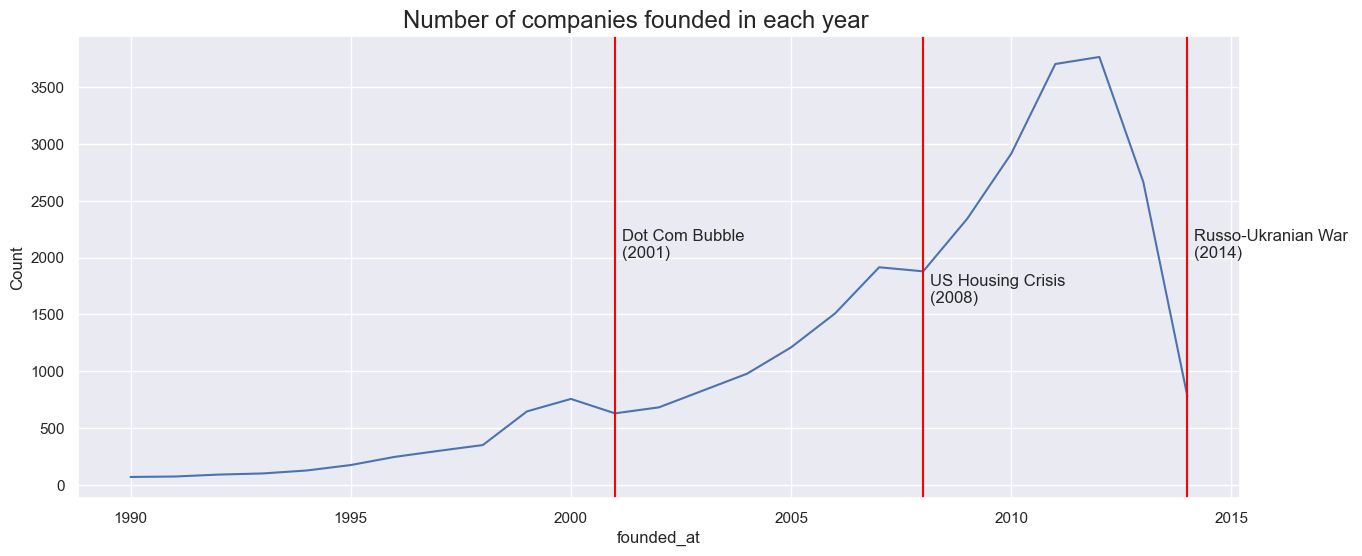

In [87]:
plt.rcParams['figure.figsize'] = 15,6
df_org['name'].groupby(df_org["founded_at"].dt.year).count().plot(kind="line")

plt.ylabel('Count')
plt.title("Number of companies founded in each year", fontdict=None, position= [0.48,1.05], size = 'x-large')
plt.axvline(2008,color='red')
plt.text(2008+0.15, 1600,"US Housing Crisis \n(2008)")
plt.axvline(2001,color='red')
plt.text(2001+0.15, 2000,"Dot Com Bubble \n(2001)")

plt.axvline(2014,color='red')
plt.text(2014+0.15, 2000,"Russo-Ukranian War \n(2014)")
plt.show()

As can be observed, all of the decline in number of start-ups founded happened in junction with major global crises.

In [88]:
Facebook_founded_year = df_org['founded_at'][df_org['name']=="Facebook"].dt.year.values[0]
Uber_founded_year  = df_org['founded_at'][df_org['name']=="Uber"].dt.year.values[0]
Alibaba_founded_year  = df_org['founded_at'][df_org['name']=="Alibaba"].dt.year.values[0]

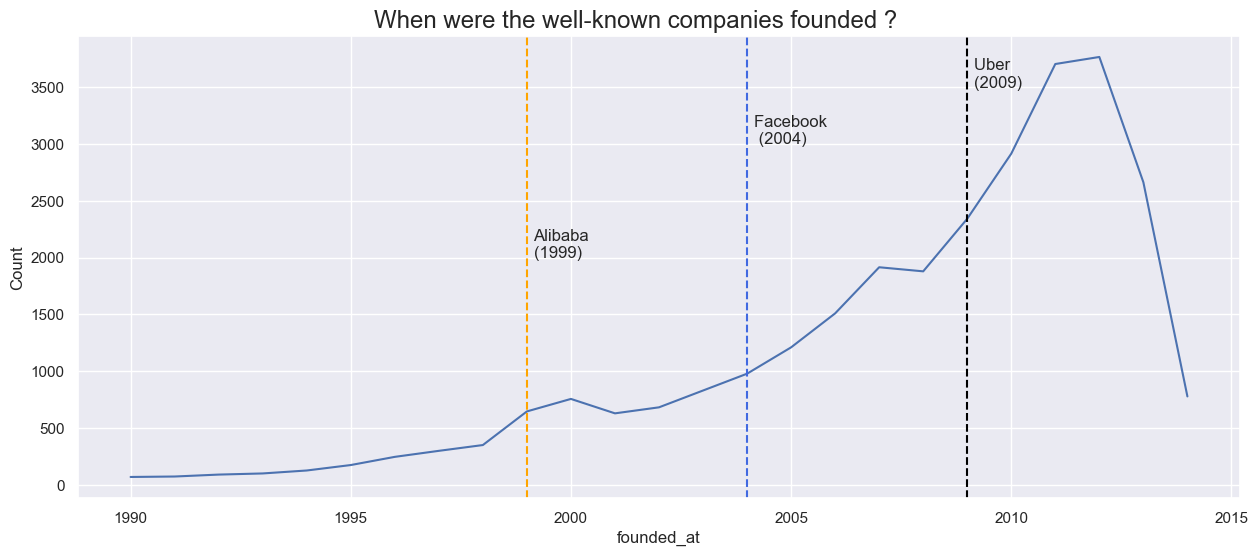

In [89]:
plt.rcParams['figure.figsize'] = 15,6
df_org['name'][df_org["founded_at"].dt.year >= 1990].groupby(df_org["founded_at"].dt.year).count().plot(kind="line")
plt.ylabel('Count')

plt.axvline(Facebook_founded_year,color='royalblue',linestyle ="--")
plt.text(Facebook_founded_year+0.15, 3000,"Facebook \n (2004)")

plt.axvline(Uber_founded_year,color='black',linestyle ="--")
plt.text(Uber_founded_year+0.15, 3500,"Uber \n(2009)")

plt.axvline(Alibaba_founded_year,color='orange',linestyle ="--")
plt.text(Alibaba_founded_year+0.15, 2000,"Alibaba \n(1999)")


plt.title("When were the well-known companies founded ?", fontdict=None, position= [0.48,1.05], size = 'x-large')
plt.show()

### 2.1.7 Analysis of funding distribution grouped on yearly basis

In [90]:
df_org.groupby(df_org["founded_at"].dt.year)["funding_total_usd"].sum()

founded_at
1990    1.560135e+09
1991    3.995324e+09
1992    2.623861e+09
1993    7.531215e+09
1994    2.829948e+09
1995    5.627879e+09
1996    6.641907e+09
1997    7.803029e+09
1998    1.135348e+10
1999    1.920413e+10
2000    1.984239e+10
2001    2.016089e+10
2002    1.982244e+10
2003    2.748235e+10
2004    3.484131e+10
2005    3.675873e+10
2006    3.551189e+10
2007    4.843309e+10
2008    2.956656e+10
2009    3.046486e+10
2010    2.708386e+10
2011    2.426714e+10
2012    1.854231e+10
2013    8.301219e+09
2014    1.621189e+09
Name: funding_total_usd, dtype: float64

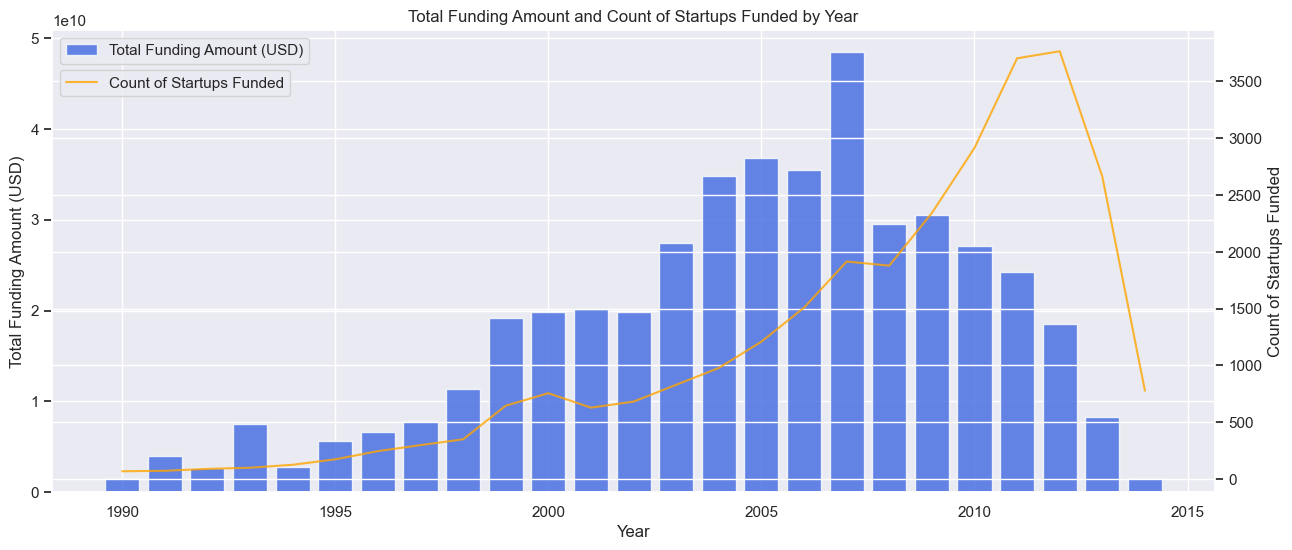

In [91]:
#Group by year
funding_by_year = df_org.groupby(df_org["founded_at"].dt.year)["funding_total_usd"].sum()
count_by_year = df_org.groupby(df_org["founded_at"].dt.year)["name"].count()
fig, ax1 = plt.subplots(figsize=(15,6))
ax2 = ax1.twinx()

#Create a bar chart 
ax1.bar(funding_by_year.index, funding_by_year.values, color='royalblue', alpha=0.8)

#Labels and formatting
ax1.set_ylabel('Total Funding Amount (USD)')
ax2.plot(count_by_year.index, count_by_year.values, color='orange', alpha=0.8)
ax2.set_ylabel('Count of Startups Funded')
ax1.set_title('Total Funding Amount and Count of Startups Funded by Year')
ax1.set_xlabel('Year')
ax1.legend(['Total Funding Amount (USD)'], loc='upper left', bbox_to_anchor=(0, 1))
ax2.legend(['Count of Startups Funded'], loc='upper left', bbox_to_anchor=(0, 0.93))
plt.show()

It can be observed that the increase and decrease trends in the total amount of funding and count of start-ups go hand-in-hand. However, there seems to be a slight lagging in which the increase in total funding, is followed by an increase in the count a couple of years later. For example, the total funding reached its peak in 2007 whereas the count reached its peak in 2012.

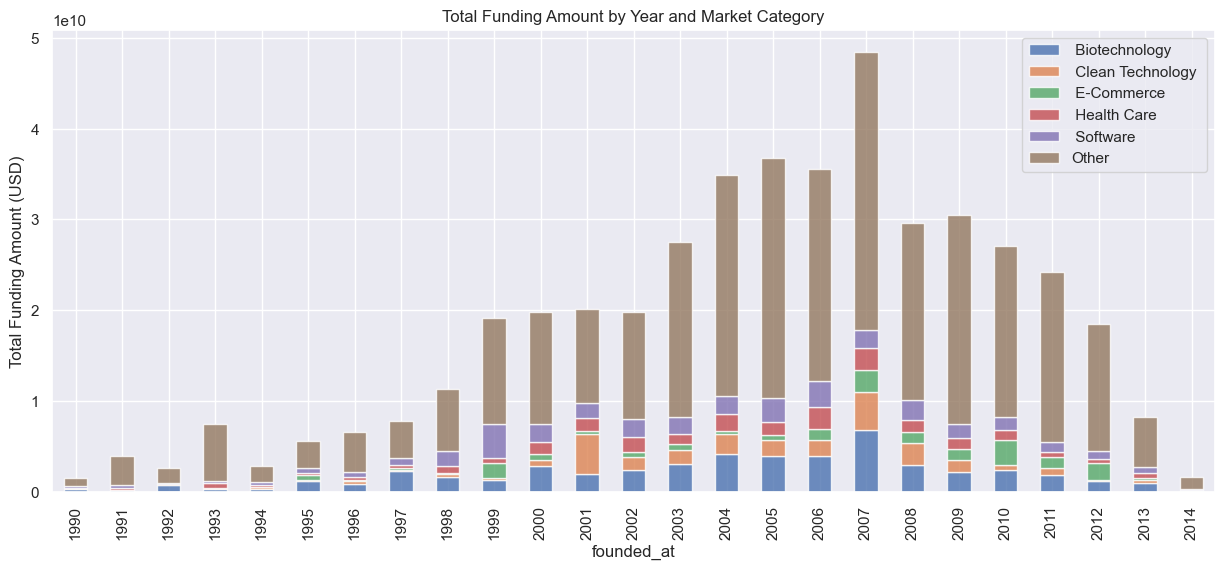

In [92]:
top_markets = df_org.groupby('market')['funding_total_usd'].sum().nlargest(5).index.tolist()
df_funding_by_year = df_org.groupby([df_org['founded_at'].dt.year, 'market'])['funding_total_usd'].sum().reset_index()
df_funding_by_year.loc[~df_funding_by_year['market'].isin(top_markets), 'market'] = 'Other'
df_funding_by_year = df_funding_by_year.groupby(['founded_at', 'market'])['funding_total_usd'].sum().unstack()
fig, ax = plt.subplots(figsize=(15,6))

# Plot it
df_funding_by_year.plot(kind='bar', stacked=True, ax=ax, alpha=0.8)
ax.set_ylabel('Total Funding Amount (USD)')

# Labels and formatiing
ax.set_title('Total Funding Amount by Year and Market Category')
ax.legend()
plt.show()


In [93]:
# Top invested categories, can be compared with the graph above including the total number of startups
df_org.groupby('market').sum()['funding_total_usd'].sort_values(ascending=False).head()

market
 Biotechnology        5.002520e+10
 Software             3.318093e+10
 Clean Technology     2.521277e+10
 Health Care          2.220721e+10
 E-Commerce           1.802274e+10
Name: funding_total_usd, dtype: float64

### Funding by country analyses

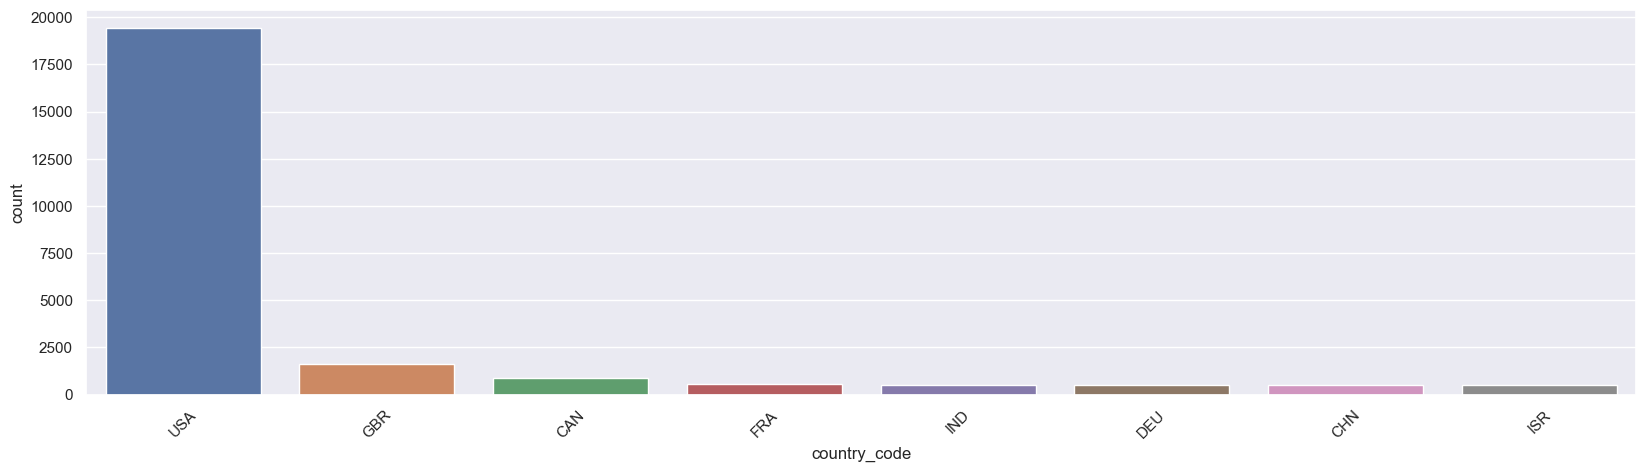

In [94]:
#Country
plt.figure(figsize=(20,5))
sns.countplot(x ='country_code', data = df_org, order=df_org['country_code'].value_counts().iloc[:8].index)
plt.xticks(rotation=45)
plt.show()

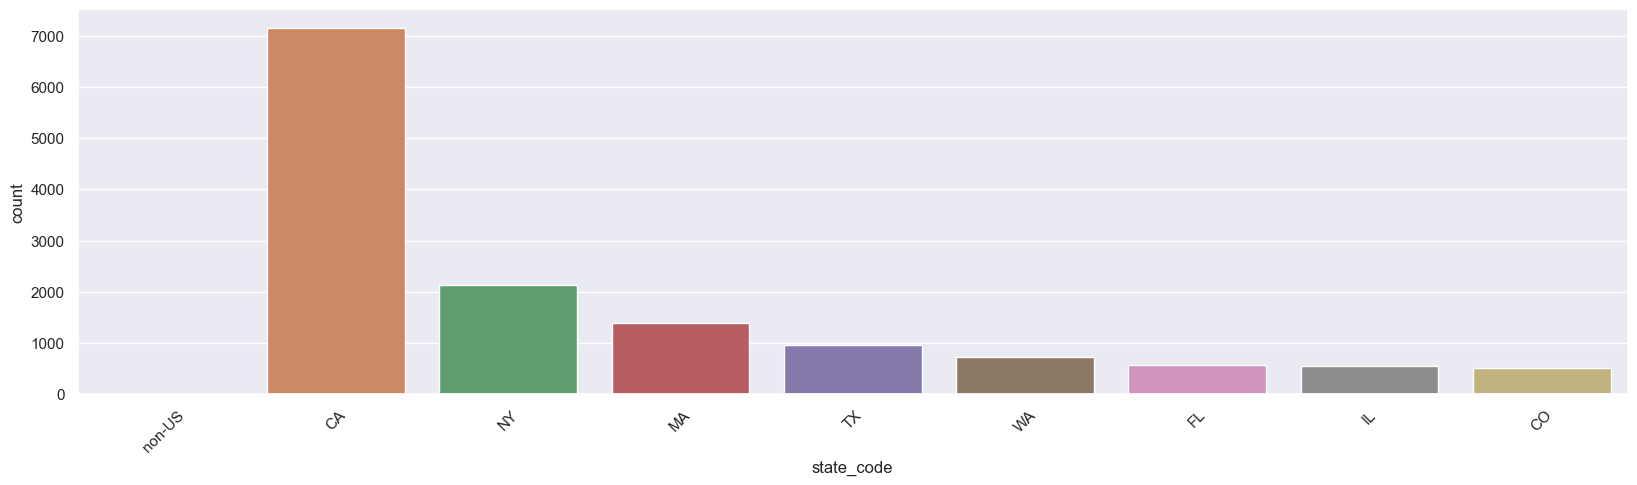

In [95]:
plt.figure(figsize=(20,5))
g = sns.countplot(x ='state_code', data = df_org[(df_org['country_code'] =='USA')], order=df_org['state_code'].value_counts().iloc[:9].index)
plt.xticks(rotation=45)
plt.show()

The US is the country in which most start-ups are founded. California leads by a great margin compared to the other states in the US.    

## 2.2 Rounds

In [96]:
df_rd.head(10)

,company_permalink,company_name,company_category_list,company_market,company_country_code,company_state_code,company_region,company_city,funding_round_permalink,funding_round_type,funding_round_code,funded_at,funded_month,funded_quarter,funded_year,raised_amount_usd
0,/organization/waywire,#waywire,|Entertainment|Politics|Social Media|News|,News,USA,NY,New York City,New York,/funding-round/cc409188fa2b63482bd9008f682c2efa,seed,NaN,2012-06-30,06,2,2012.0,1750000.0
1,/organization/tv-communications,&TV Communications,|Games|,Games,USA,CA,Los Angeles,Los Angeles,/funding-round/59a3669a64e39360c2b939300bcda162,venture,NaN,2010-09-23,09,3,2010.0,3000000.0
2,/organization/tv-communications,&TV Communications,|Games|,Games,USA,CA,Los Angeles,Los Angeles,/funding-round/86d22afc65107b6941e6c43c671ecbb8,venture,NaN,2010-06-04,06,2,2010.0,1000000.0
3,/organization/rock-your-paper,'Rock' Your Paper,|Publishing|Education|,Publishing,EST,NaN,Tallinn,Tallinn,/funding-round/f06b420775f7cb6c1541a9db526534bb,seed,NaN,2012-08-09,08,3,2012.0,40000.0
4,/organization/in-touch-network,(In)Touch Network,|Electronics|Guides|Coffee|Restaurants|Music|i...,Electronics,GBR,NaN,London,London,/funding-round/33c3f135f05d7b734b8d7b7c8ae82647,seed,NaN,2011-04-01,04,2,2011.0,1500000.0
5,/organization/r-ranch-and-mine,-R- Ranch and Mine,|Tourism|Entertainment|Games|,Tourism,USA,TX,Dallas,Fort Worth,/funding-round/029720f7eeb218f51c43df5155671472,equity_crowdfunding,NaN,2014-08-17,08,3,2014.0,10000.0
6,/organization/r-ranch-and-mine,-R- Ranch and Mine,|Tourism|Entertainment|Games|,Tourism,USA,TX,Dallas,Fort Worth,/funding-round/766b0bcead9ca8560af5e1ade579fb7f,equity_crowdfunding,NaN,2014-09-26,09,3,2014.0,50000.0
7,/organization/club-domains,.Club Domains,|Software|,Software,USA,FL,Ft. Lauderdale,Oakland Park,/funding-round/aee671c9707f8278a9544c8ae37650e0,venture,B,2013-05-31,05,2,2013.0,7000000.0
8,/organization/fox-networks,.Fox Networks,|Advertising|,Advertising,ARG,NaN,Buenos Aires,Buenos Aires,/funding-round/69a1536a6f4506538afd7aa7241ddbe1,undisclosed,NaN,2007-01-16,01,1,2007.0,4912393.0
9,/organization/0-6-com,0-6.com,|Curated Web|,Curated Web,NaN,NaN,NaN,NaN,/funding-round/5727accaeaa57461bd22a9bdd945382d,venture,A,2008-03-19,03,1,2008.0,2000000.0


### 2.2.1 Descriptive statistics

Compared to the organisations data frame, the variable 'raised_amount_usd' has got lower mean. The observation count is higher by around 2.5 times compared to organisations data frame. The standard devation is around 25% higher than for the organisations data frame. The median is slighly lower, while the maximal value is around 2 times higher.

In [97]:
df_rd.describe()

,funded_year,raised_amount_usd
count,83860.000000,7.091500e+04
mean,2011.018173,9.176873e+06
std,2.889240,9.665408e+07
min,1921.000000,1.000000e+00
25%,2010.000000,3.611505e+05
50%,2012.000000,1.700000e+06
75%,2013.000000,6.574399e+06
max,2015.000000,2.127194e+10


### 2.2.2 Funding aquired by the startups

The distribution of funding raised in a given round is a bit more skewed than the distribution of the toal funding, but the pattern is similar -  similar to a negative exponential distribution.

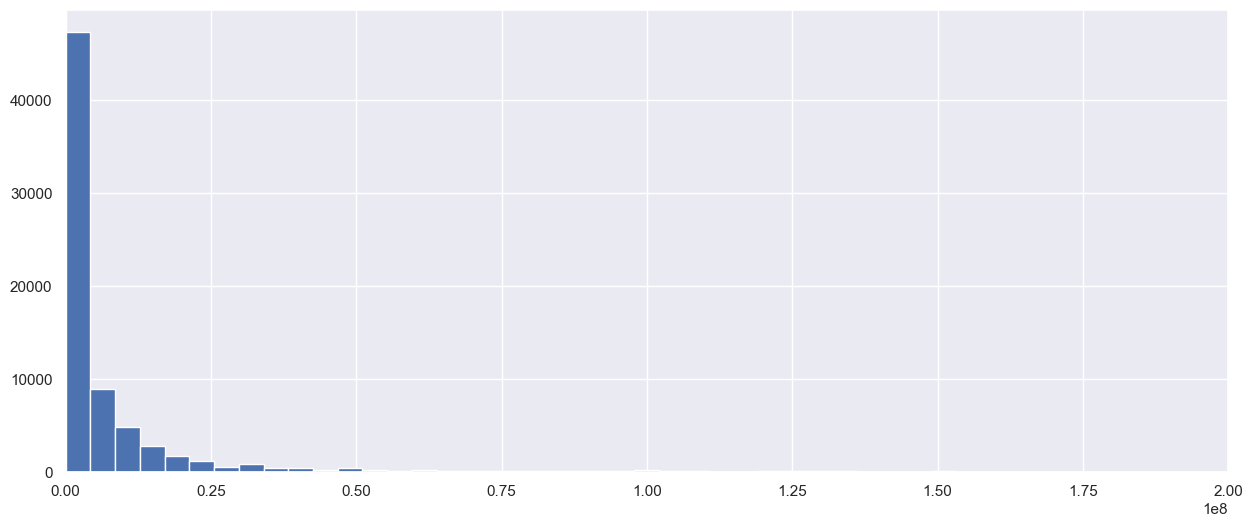

In [98]:
#Similar histogram as for organisations

fig=plt.figure()
ax = fig.add_subplot(1,1,1)
ax.hist(df_rd['raised_amount_usd'], bins = 5000)
ax.set_xlim(left=0, right=200000000);

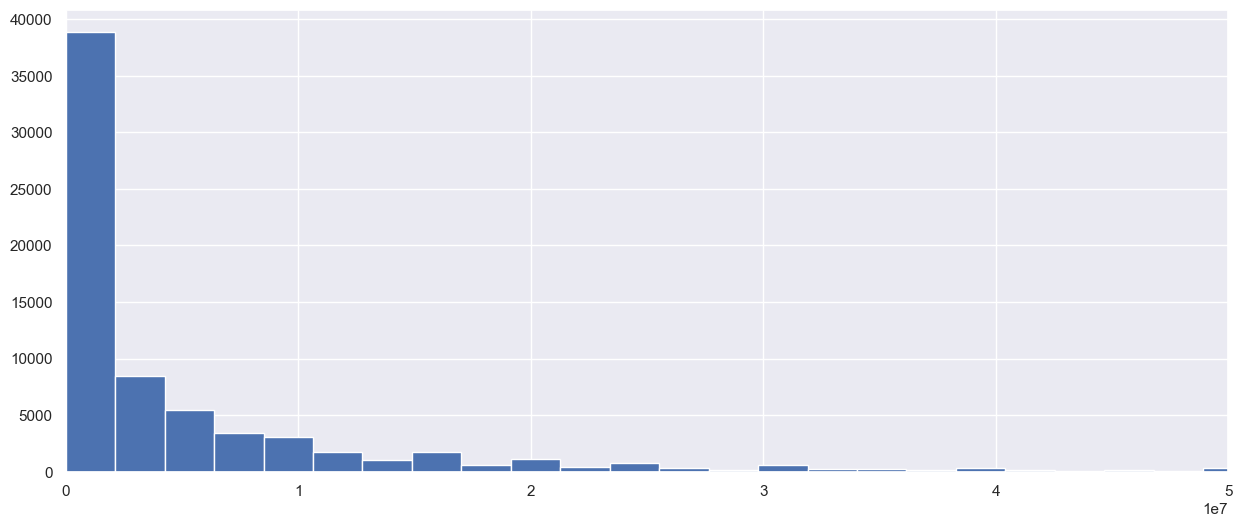

In [99]:
#Histogram of total funding aquired by the startups - zoom on the values smaller than 50000000 (50 mln USD)

fig=plt.figure()
ax = fig.add_subplot(1,1,1)
ax.hist(df_rd['raised_amount_usd'], bins = 10000)
ax.set_xlim(left=0, right=50000000);

#### Start-ups that aquired the most funding

Verizon Communications, Sberbank and Chaler Communications received the most 

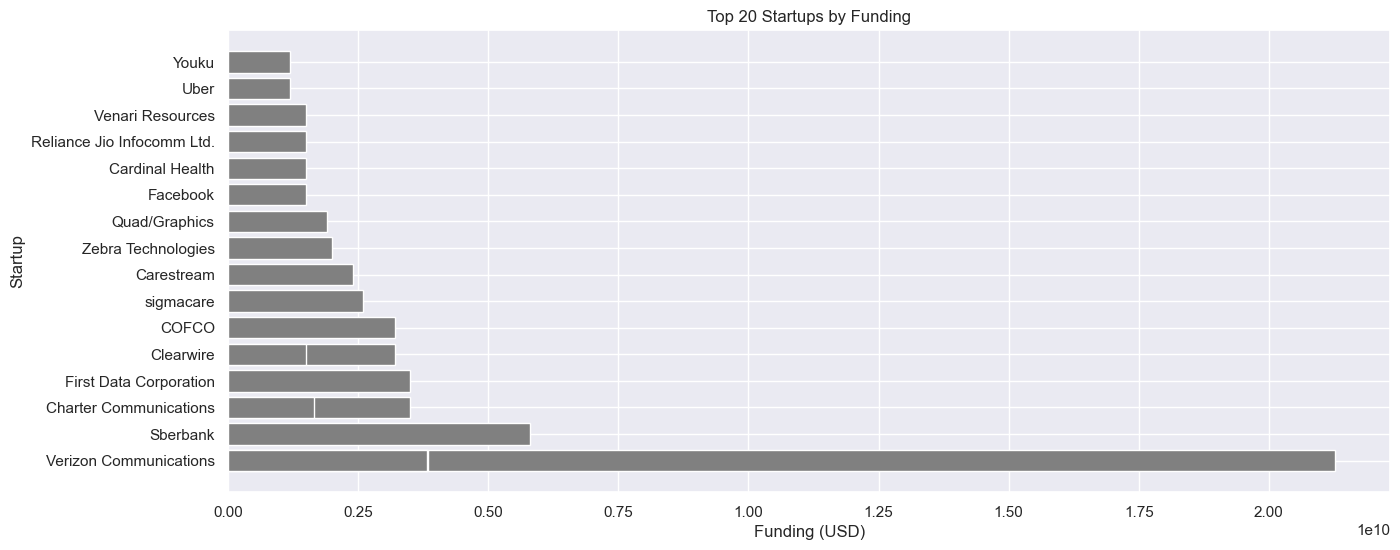

In [100]:
# sort the data 
top = df_rd.sort_values(by=['raised_amount_usd'],ascending=False).head(20)

# Bar plot - horizontal
plt.barh(top['company_name'], top['raised_amount_usd'], color='grey')
plt.xlabel('Funding (USD)')
plt.ylabel('Startup')
plt.title('Top 20 Startups by Funding')
plt.show()

### 2.2.3 The most common markets (industries)

In [101]:
len(df_rd['company_market'].unique())

754

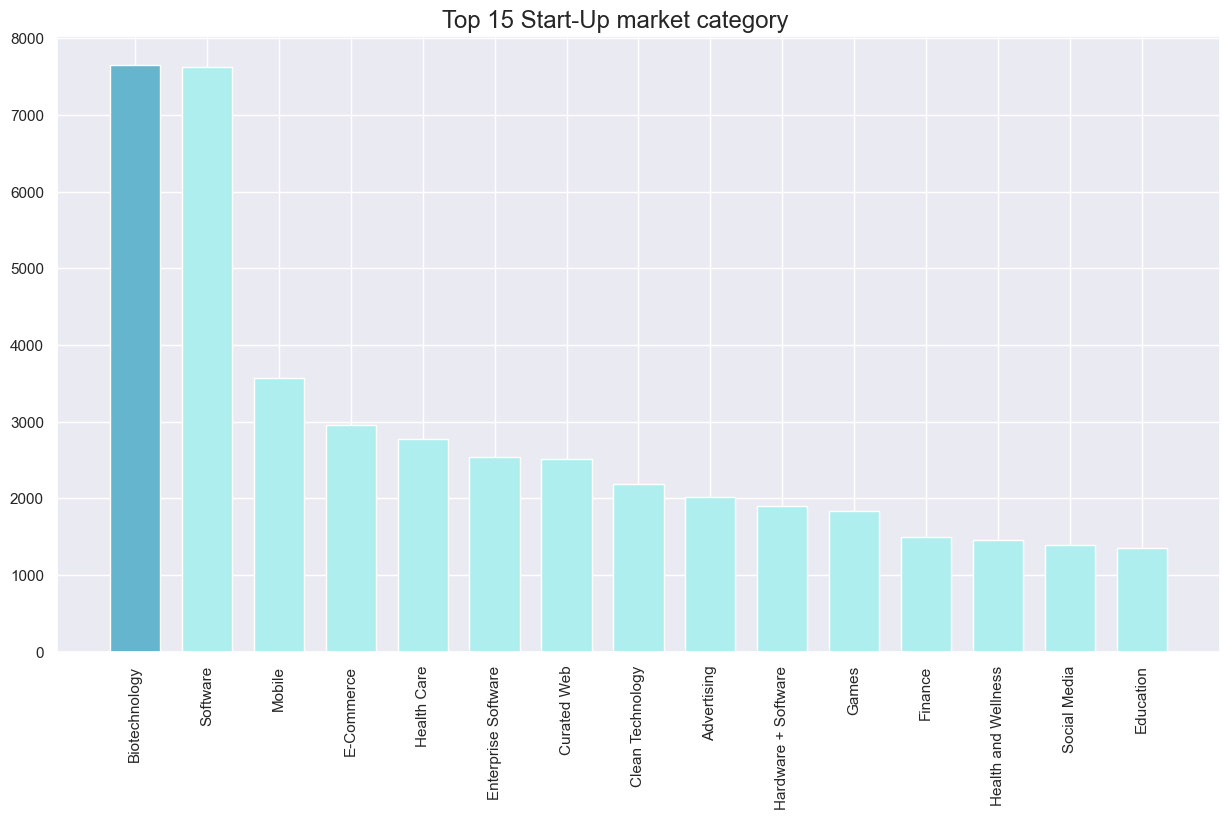

In [102]:
plt.rcParams['figure.figsize'] = 15,8

height = df_rd['company_market'].value_counts()[:15].tolist()
bars =  df_rd['company_market'].value_counts()[:15].index.tolist()
y_pos = np.arange(len(bars))
plt.bar(y_pos, height , width=0.7 ,color= ['c']+['paleturquoise']*14)
plt.xticks(y_pos, bars)
plt.xticks(rotation=90)
plt.title("Top 15 Start-Up market category", fontdict=None, position= [0.48,1.05], size = 'x-large')
plt.show()

Compared to the total funding aquired, the biotechnology has got more funding than software. There are also other differences in the top categories. The values for each category are higher than in case of the organisation data frame.

In [103]:
df_rd['count'] = 1
country_market = df_rd[['count','company_country_code','company_market']].groupby(['company_country_code','company_market']).agg({'count': 'sum'})
# Change: groupby state_office and divide by sum
country_market_pct = country_market.groupby(level=0).apply(lambda x: 100 * x / float(x.sum()))
country_market_pct.reset_index(inplace = True)

In [104]:
USA_market_pct = country_market_pct[country_market_pct['company_country_code'] == "USA"]
USA_market_pct = USA_market_pct.sort_values('count',ascending = False)[0:10]

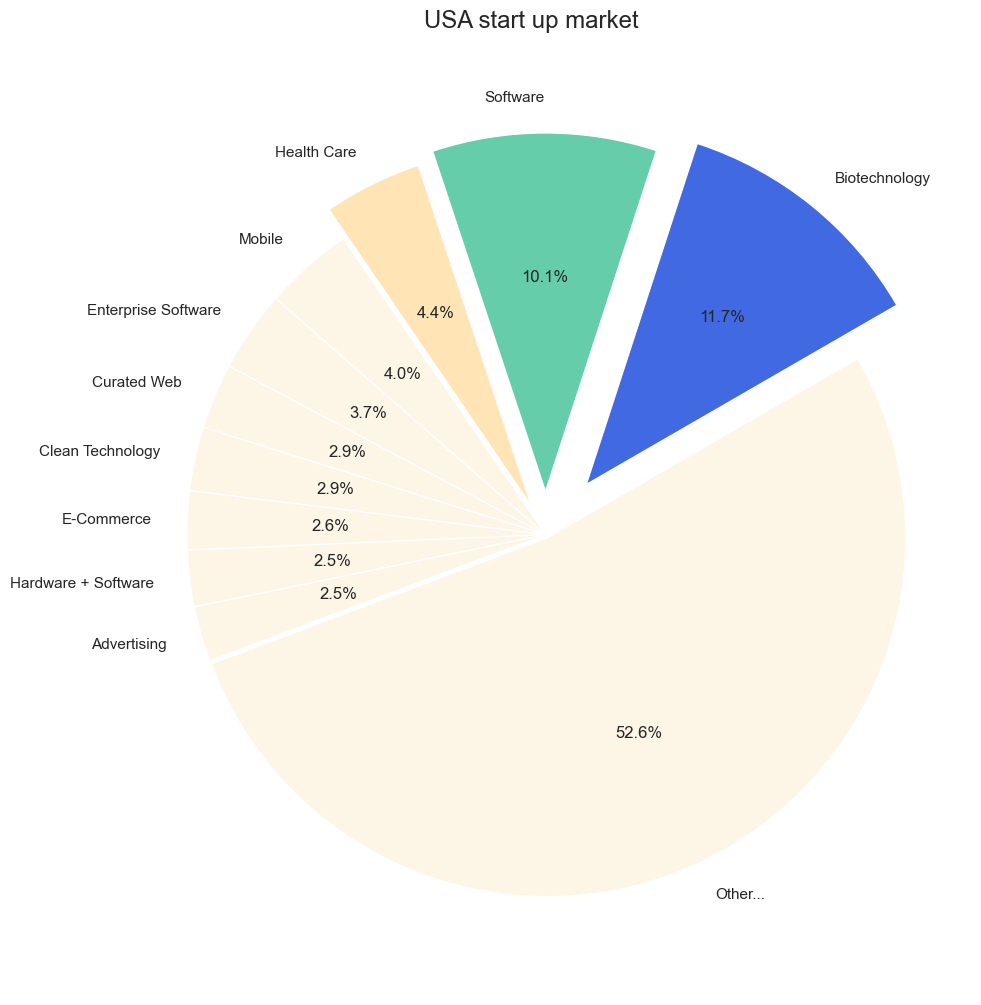

In [105]:
## USA
plt.rcParams['figure.figsize'] =10,10
labels = list(USA_market_pct['company_market'])+['Other...']
sizes = list(USA_market_pct['count'])+[100-USA_market_pct['count'].sum()]
explode = (0.18, 0.12, 0.09,0,0,0,0,0,0,0,0.01)
colors =  ['royalblue','mediumaquamarine','moccasin'] +['oldlace']*8

plt.pie(sizes, explode = explode, colors = colors ,labels=labels, autopct='%1.1f%%',
        shadow=False, startangle=30)
plt.axis('equal')
plt.tight_layout()
plt.title("USA start up market", fontdict=None, position= [0.48,1.1], size = 'x-large')

plt.show()


The breakdown of funding on the American market leads to similar conclusions as the previous chart, presenting the worldwide breakdown of funding. Compared to the part 2.1, the biotechnology has got a higher share than software, the organisations' data inidcated the opposite. Also Health Care is on 3rd place, whilst it was on 6th position at the respective chart made on basis of the organisations data.    

### 2.2.4 Number of rounds by year and funding

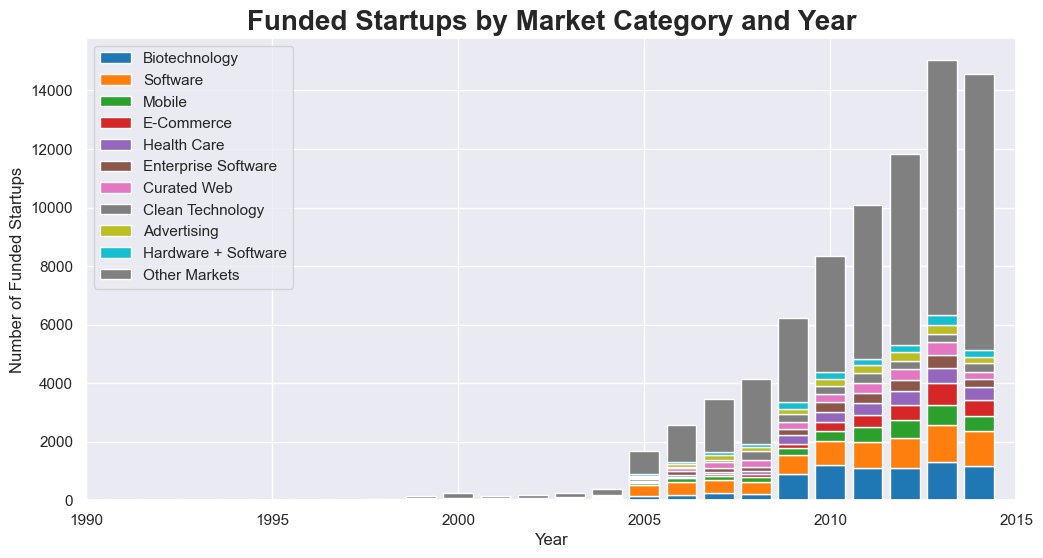

In [106]:

market_counts = df_rd.groupby([df_rd["funded_year"], "company_market"])["company_name"].count().unstack(fill_value=0)
top_10_markets = market_counts.sum().nlargest(10).index.tolist()

for market in top_10_markets:
    market_counts[market] = market_counts[market] if market in market_counts.columns else 0
market_counts["Other"] = market_counts.sum(axis=1) - market_counts[top_10_markets].sum(axis=1)

fig, ax = plt.subplots(figsize=(12, 6))

market_colors = plt.get_cmap('tab10').colors
for i, market in enumerate(top_10_markets):
    ax.bar(market_counts.index, market_counts[market], bottom=market_counts[top_10_markets[:i]].sum(axis=1), color=market_colors[i], label=market)
ax.bar(market_counts.index, market_counts["Other"], bottom=market_counts[top_10_markets].sum(axis=1), color="gray", label="Other Markets")


ax.set_xlabel("Year")
ax.set_ylabel("Number of Funded Startups")

ax.set_title("Funded Startups by Market Category and Year", fontdict={'fontsize': 20, 'fontweight': 'bold', 'verticalalignment': 'baseline'}, loc='center')
ax.set_xlim(left=1990)
ax.set_xlim(right=2015)

ax.legend()

plt.show()


Similar to the part 2.1, the Biotechnology, Software and Mobile are the main start-up markets. 

In [107]:
df_rd.groupby('company_market').sum()['raised_amount_usd'].sort_values(ascending=False).head()

company_market
Biotechnology       7.337290e+10
Mobile              4.947011e+10
Software            4.222748e+10
Clean Technology    3.761994e+10
Health Care         2.946608e+10
Name: raised_amount_usd, dtype: float64

### 2.2.5 Country Analyses

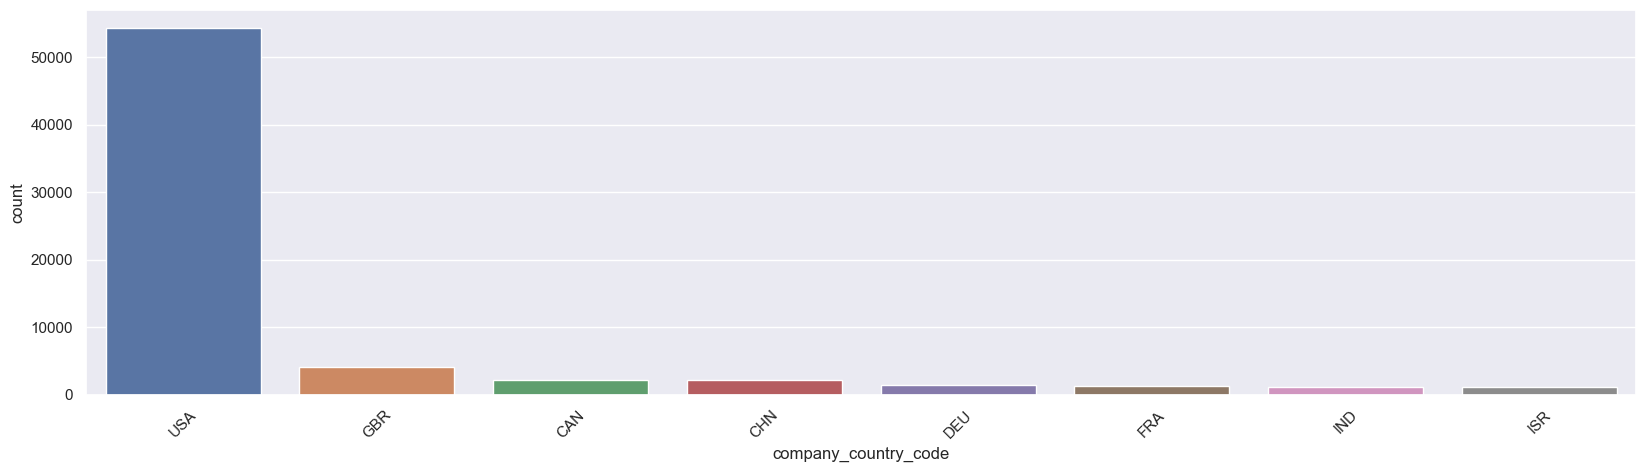

In [108]:
#Country
plt.figure(figsize=(20,5))
sns.countplot(x ='company_country_code', data = df_rd, order=df_rd['company_country_code'].value_counts().iloc[:8].index)
plt.xticks(rotation=45)
plt.show()


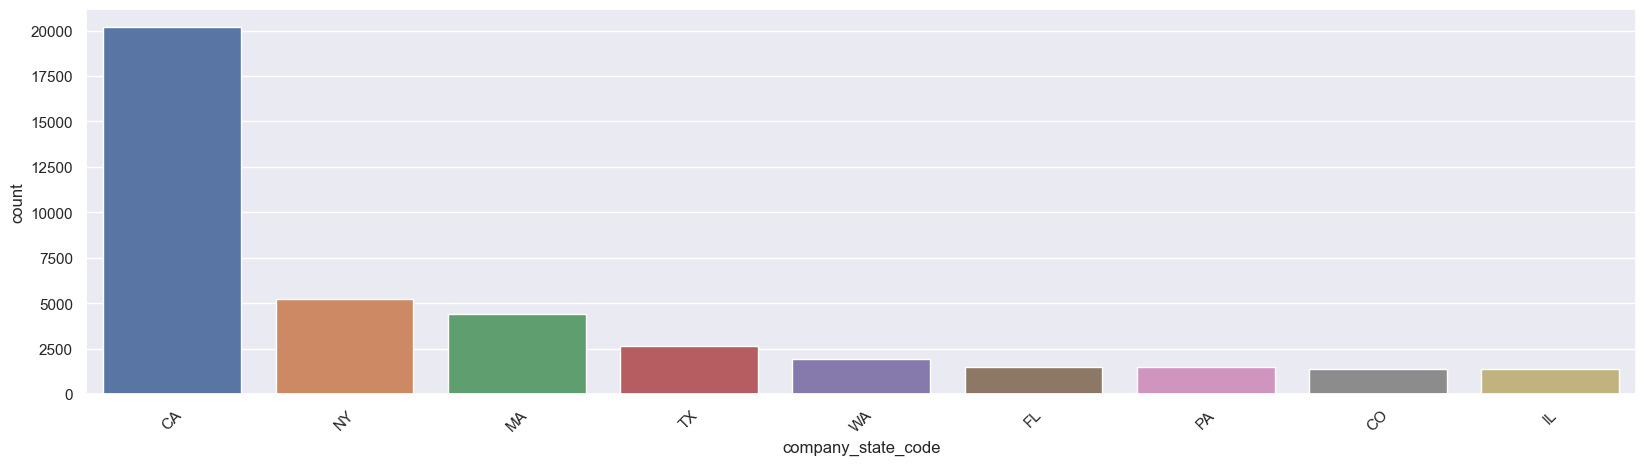

In [109]:
plt.figure(figsize=(20,5))
g = sns.countplot(x ='company_state_code', data = df_rd[(df_rd['company_country_code'] =='USA')], order=df_rd['company_state_code'].value_counts().iloc[:9].index)
plt.xticks(rotation=45)
plt.show()


Similar to part 2.1, the US is the country in which most start-ups are founded. California leads by a great margin compared to the other states in the US.    

### 2.2.6 Funds raised depending on the round code and type

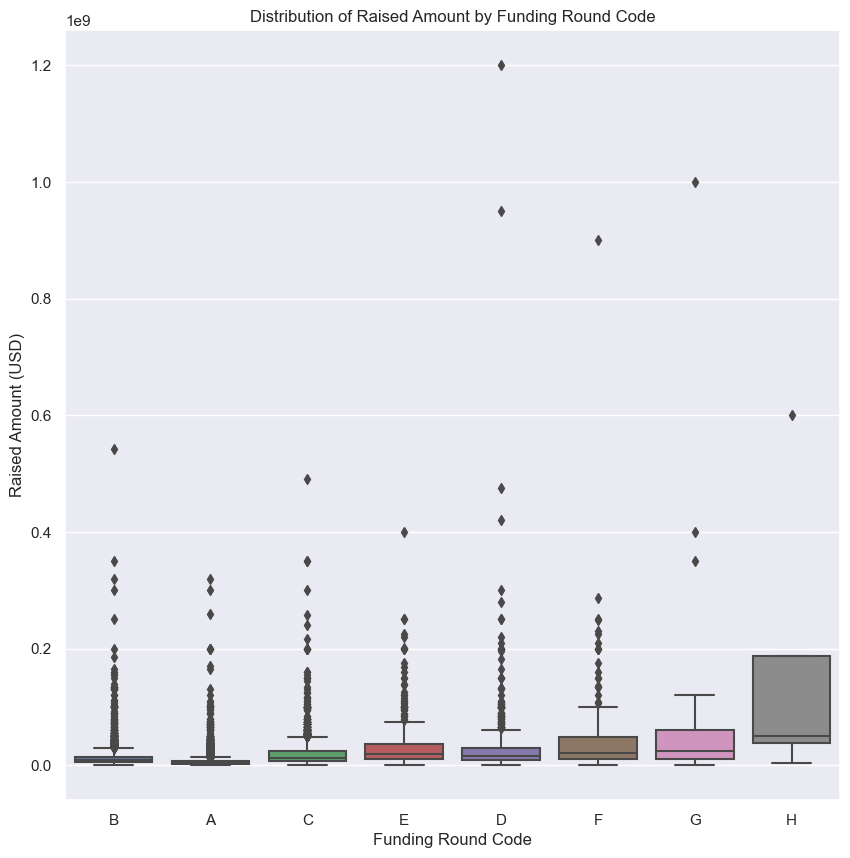

In [110]:
sns.boxplot(x='funding_round_code', y='raised_amount_usd', data=df_rd)

plt.xlabel('Funding Round Code')
plt.ylabel('Raised Amount (USD)')
plt.title('Distribution of Raised Amount by Funding Round Code')
plt.show()

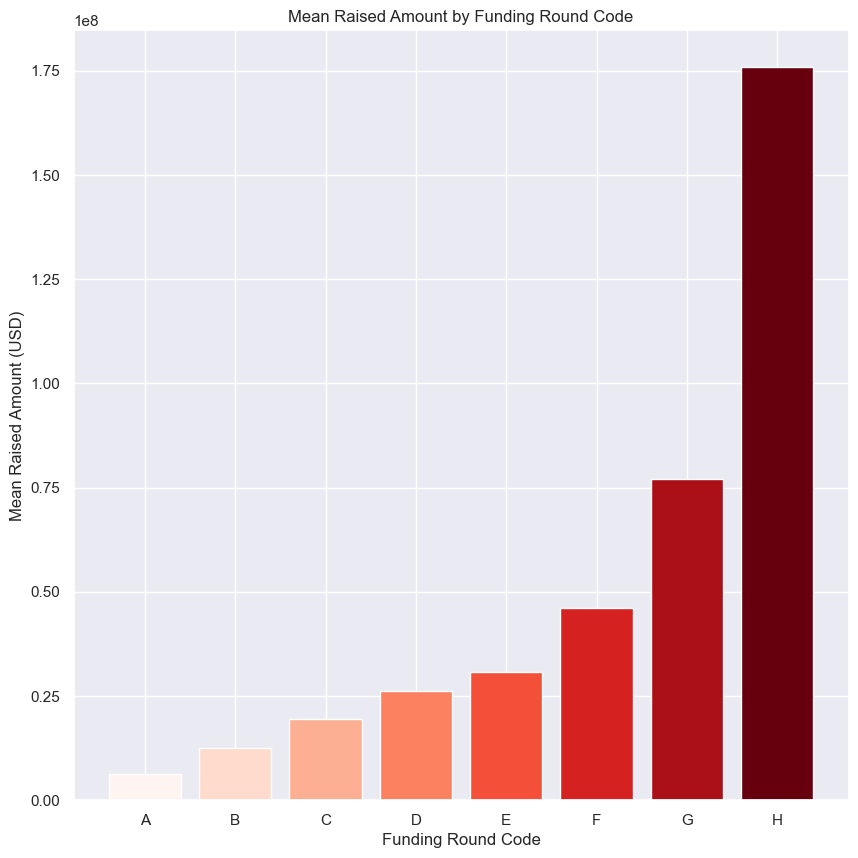

In [111]:
#Group the data
grouped = df_rd.groupby('funding_round_code')['raised_amount_usd'].mean().reset_index()

##Create the plot
colors = plt.cm.Reds(np.linspace(0, 1, len(grouped)))
plt.bar(grouped['funding_round_code'], grouped['raised_amount_usd'], color=colors)

# Labels and formatting
plt.xlabel('Funding Round Code')
plt.ylabel('Mean Raised Amount (USD)')
plt.title('Mean Raised Amount by Funding Round Code')
plt.show()

The mean raised amount has grown exponentially from round A to round H.

#### Funding round types

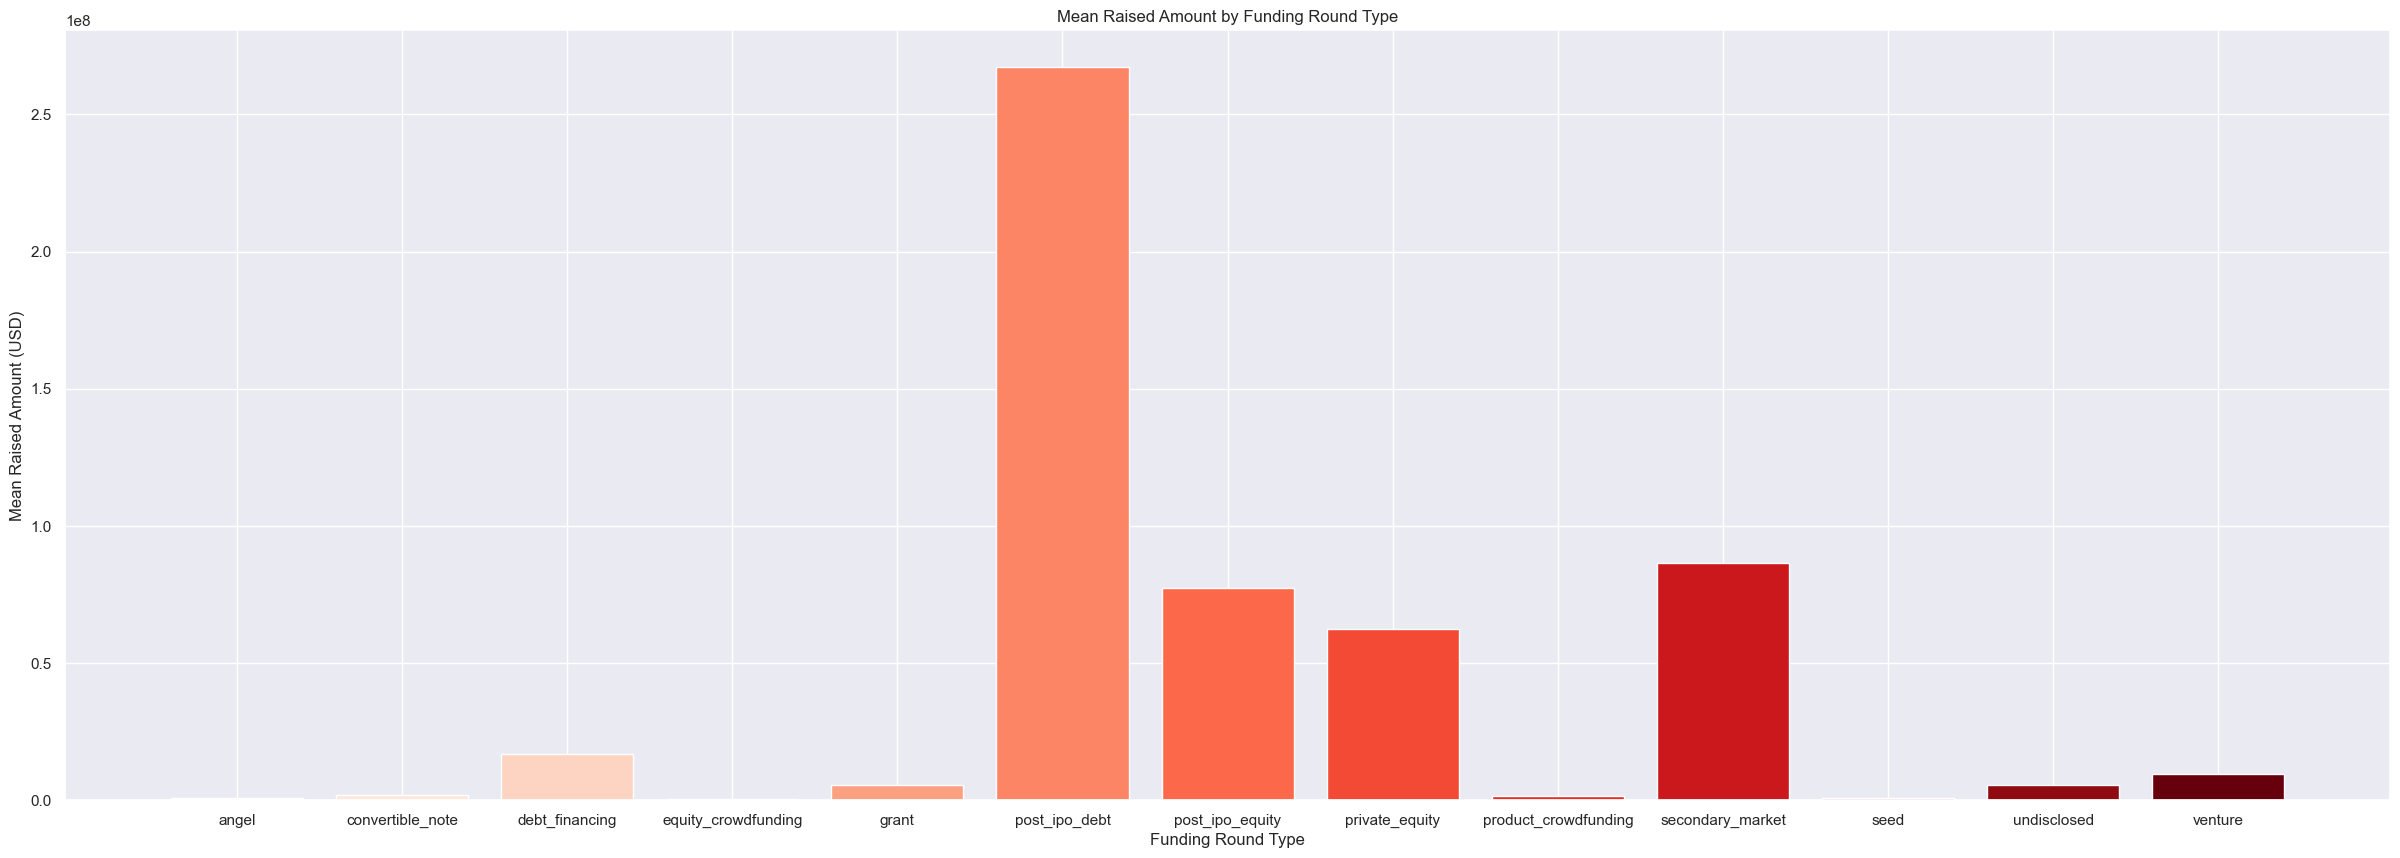

In [112]:
#Group the data
grouped = df_rd.groupby('funding_round_type')['raised_amount_usd'].mean().reset_index()

# Create the plot
colors = plt.cm.Reds(np.linspace(0, 1, len(grouped)))
fig = plt.figure(figsize=(30, 10)) 
ax = fig.add_subplot(111)
ax.bar(grouped['funding_round_type'], grouped['raised_amount_usd'], color=colors)

# Formatring and labels
ax.set_xlabel('Funding Round Type')
ax.set_ylabel('Mean Raised Amount (USD)')
ax.set_title('Mean Raised Amount by Funding Round Type')
plt.show()

In rounds that were classified as the following types:
	
Post IPO Debt

Secondary Market

Post IPO Equity

Private Equity

the mean raised amount was substantially higher than among other types.

## 2.3 Investments

In [113]:
df_inv.head(10)

,company_permalink,company_name,company_category_list,company_market,company_country_code,company_state_code,company_region,company_city,investor_permalink,investor_name,investor_category_list,investor_market,investor_country_code,investor_state_code,investor_region,investor_city,funding_round_permalink,funding_round_type,funding_round_code,funded_at,funded_month,funded_quarter,funded_year,raised_amount_usd
0,/organization/test-company-3,test company,NaN,NaN,ARE,NaN,Dubai,Dubai,/person/jamessss-bondddd,jamessss bondddd,NaN,NaN,NaN,NaN,NaN,NaN,/funding-round/c308019016ead7afb2a1d117018eb6fc,seed,NaN,1921-09-01,09,Q3,1921-01-01,1000.0
1,/organization/andrewburnett-com-ltd,AndrewBurnett.com Ltd,|Internet|SEO|Services|Public Relations|Social...,Internet,GBR,NaN,Edinburgh,Edinburgh,/organization/ekaf,Ekaf,NaN,NaN,NaN,NaN,NaN,NaN,/funding-round/14fe2864e02d0f15ddc3ec8eacdc8e1b,seed,NaN,1974-01-01,01,Q1,1974-01-01,NaN
2,/organization/abo-data,ABO Data,|Enterprise Software|,Enterprise Software,USA,TX,TX - Other,Italy,/person/antonio-murroni,ANTONIO MURRONI,NaN,NaN,NaN,NaN,NaN,NaN,/funding-round/809e211b969c3f66440fc15ffcd29385,seed,NaN,1979-01-01,01,Q1,1979-01-01,1000000.0
3,/organization/abo-data,ABO Data,|Enterprise Software|,Enterprise Software,USA,TX,TX - Other,Italy,/person/filippo-murroni,FILIPPO Murroni,NaN,NaN,NaN,NaN,NaN,NaN,/funding-round/809e211b969c3f66440fc15ffcd29385,seed,NaN,1979-01-01,01,Q1,1979-01-01,1000000.0
4,/organization/ikro,Ikro,NaN,NaN,BRA,NaN,BRA - Other,Canoas,/organization/crp-companhia-de-participacoes,CRP Companhia de Participações,NaN,NaN,NaN,NaN,NaN,NaN,/funding-round/46c353a8249170cc4b6ab89a522fefdc,venture,A,1982-06-01,06,Q2,1982-01-01,724000.0
5,/organization/laborat-rios-noli,Laboratórios Noli,NaN,NaN,BRA,NaN,Porto Alegre,Porto Alegre,/organization/crp-companhia-de-participacoes,CRP Companhia de Participações,NaN,NaN,NaN,NaN,NaN,NaN,/funding-round/5bdff09243b72f7fb325146259880e93,venture,A,1982-12-01,12,Q4,1982-01-01,155000.0
6,/organization/indelsul,Indelsul,NaN,NaN,NaN,NaN,NaN,NaN,/organization/crp-companhia-de-participacoes,CRP Companhia de Participações,NaN,NaN,NaN,NaN,NaN,NaN,/funding-round/48e8db0d90f95934831603622cb3f46a,venture,A,1982-12-01,12,Q4,1982-01-01,165000.0
7,/organization/polimax,Polimax,NaN,NaN,NaN,NaN,NaN,NaN,/organization/crp-companhia-de-participacoes,CRP Companhia de Participações,NaN,NaN,NaN,NaN,NaN,NaN,/funding-round/b046f5d59bc7a5bc86ddfb69c70adf77,venture,A,1983-06-01,06,Q2,1983-01-01,94000.0
8,/organization/lenovo,Lenovo,|Hardware|,Hardware,USA,NC,Raleigh,Morrisville,/organization/chinese-academy-of-sciences,Chinese Academy Of Sciences,|Education|,Education,CHN,NaN,Beijing,Beijing,/funding-round/0f444f3fdb0c1058aa70eeba9f0f5089,undisclosed,NaN,1984-01-01,01,Q1,1984-01-01,NaN
9,/organization/mixertech,Mixertech,NaN,NaN,NaN,NaN,NaN,NaN,/organization/crp-companhia-de-participacoes,CRP Companhia de Participações,NaN,NaN,NaN,NaN,NaN,NaN,/funding-round/4316813c5da6e06f2a15fa25c7946a73,venture,A,1984-05-01,05,Q2,1984-01-01,NaN


### 2.3.1 Descriptive statistics

In [114]:
df_inv.describe()

,raised_amount_usd
count,1.010910e+05
mean,1.267140e+07
std,4.725429e+07
min,1.400000e+01
25%,1.200000e+06
50%,4.600000e+06
75%,1.300000e+07
max,5.800000e+09


### 2.3.2 Funding aquired by the startups

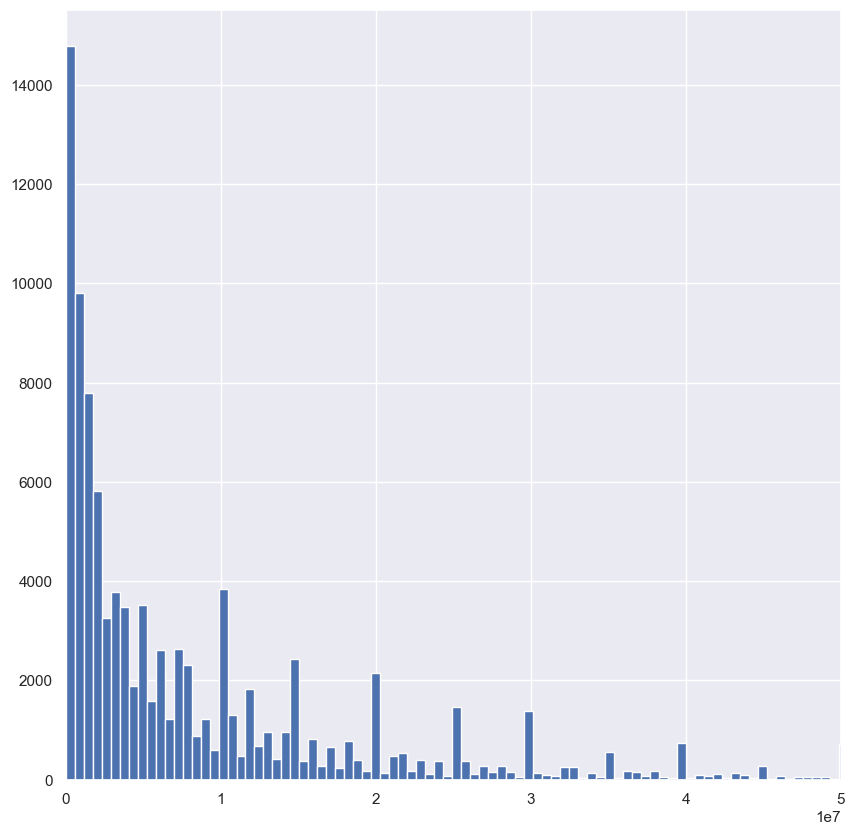

In [115]:
#Histogram of total funding aquired by the startups - zoom on the values smaller than 50000000 (50 mln USD)

fig=plt.figure()
ax = fig.add_subplot(1,1,1)
ax.hist(df_inv['raised_amount_usd'], bins = 10000)
ax.set_xlim(left=0, right=50000000);

The distribution of the investments is similar to the distributions presented in parts 2.1 and 2.2. A slighly higher number of relatevely big investments can be observed. 

### 2.3.3 Investments over time and by market category

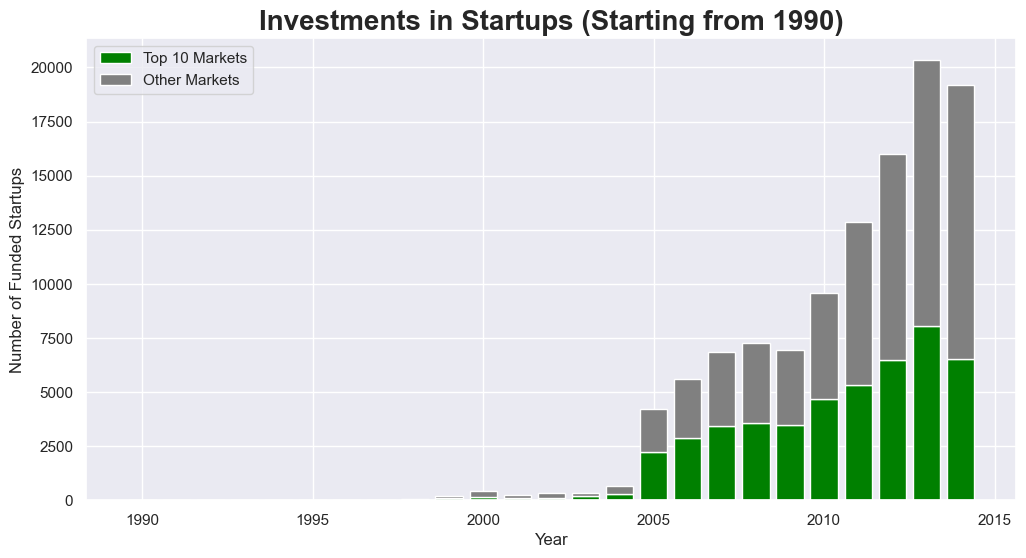

In [116]:
df_inv_1990 = df_inv[df_inv["funded_at"].dt.year >= 1990]
market_counts = df_inv_1990.groupby([df_inv_1990["funded_at"].dt.year, "company_market"])["company_name"].count().unstack(fill_value=0)
top_5_markets = market_counts.sum().nlargest(10).index.tolist()
market_counts["Other"] = market_counts.sum(axis=1) - market_counts[top_5_markets].sum(axis=1)
top_5_counts = market_counts[top_5_markets].sum(axis=1)
other_counts = market_counts["Other"]

# Create the plot
fig, ax = plt.subplots(figsize=(12, 6))
ax.bar(top_5_counts.index, top_5_counts, color="green", label="Top 10 Markets")
ax.bar(other_counts.index, other_counts, bottom=top_5_counts, color="gray", label="Other Markets")
ax.set_xlabel("Year")
ax.set_ylabel("Number of Funded Startups")
ax.set_title("Investments in Startups (Starting from 1990)", fontdict={'fontsize': 20, 'fontweight': 'bold', 'verticalalignment': 'baseline'}, loc='center')
ax.legend()
plt.show()

The trend corresponds to the observations made in the previous part dedicated to the funding rounds. After 2004 the number of investments has increased dynamically.

#### Different market categories

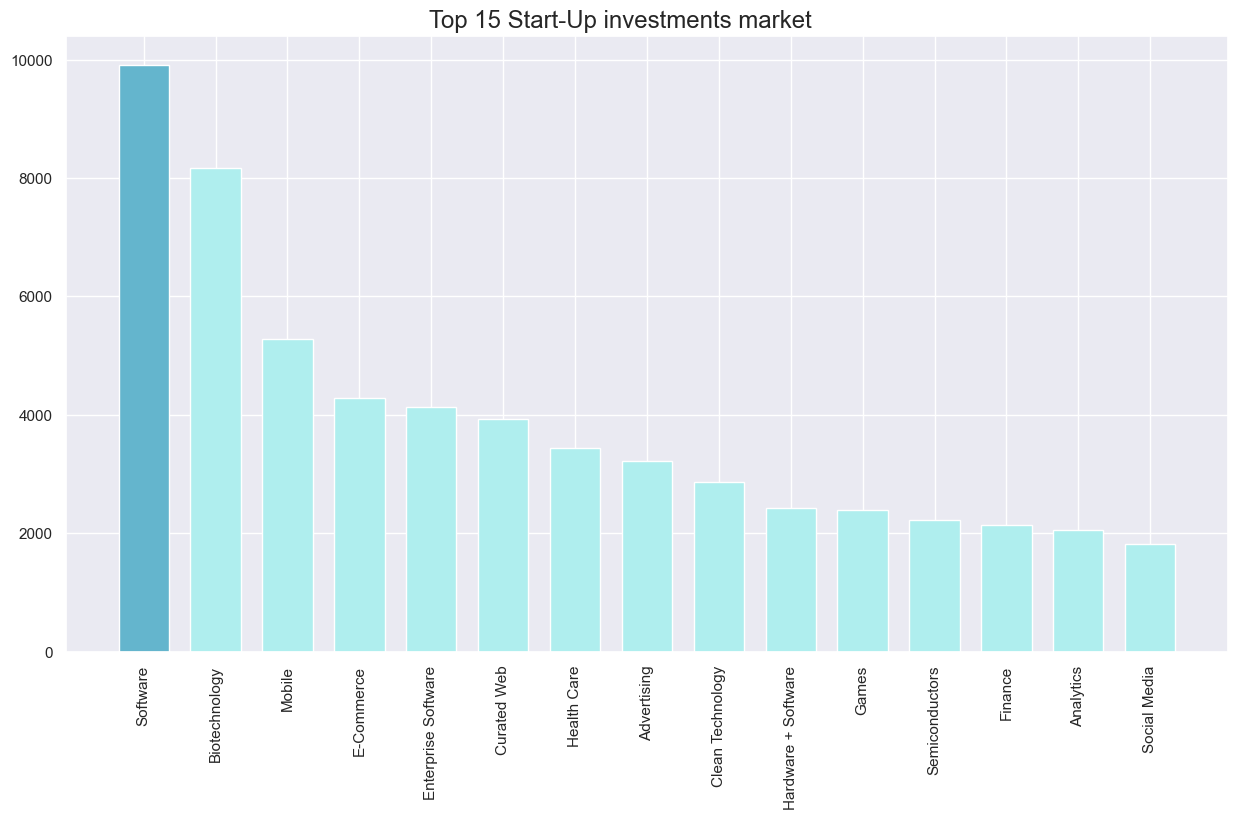

In [117]:
plt.rcParams['figure.figsize'] = 15,8

height = df_inv['company_market'].value_counts()[:15].tolist()
bars =  df_inv['company_market'].value_counts()[:15].index.tolist()
y_pos = np.arange(len(bars))
plt.bar(y_pos, height , width=0.7 ,color= ['c']+['paleturquoise']*14)
plt.xticks(y_pos, bars)
plt.xticks(rotation=90)
plt.title("Top 15 Start-Up investments market ", fontdict=None, position= [0.48,1.05], size = 'x-large')
plt.show()

The top markets for investments are Software, Biotechnology and Mobile, as in the previous sections. 

### 2.3.4 Investments by country

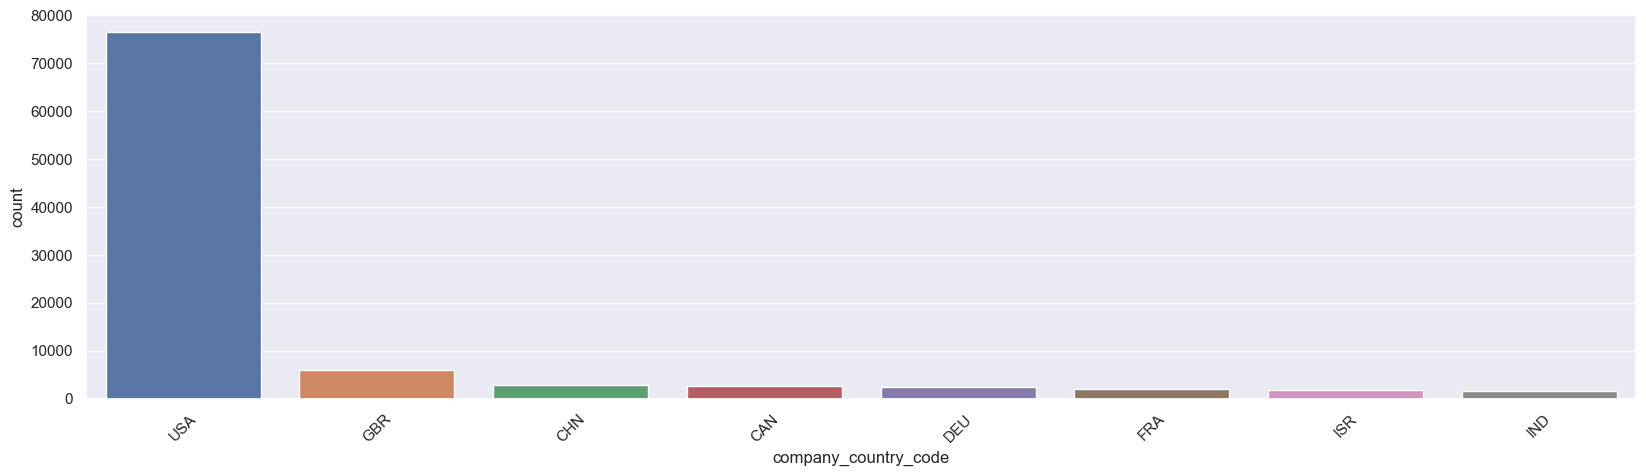

In [118]:
#Country
plt.figure(figsize=(20,5))
sns.countplot(x ='company_country_code', data = df_inv, order=df_inv['company_country_code'].value_counts().iloc[:8].index)
plt.xticks(rotation=45)
plt.show()

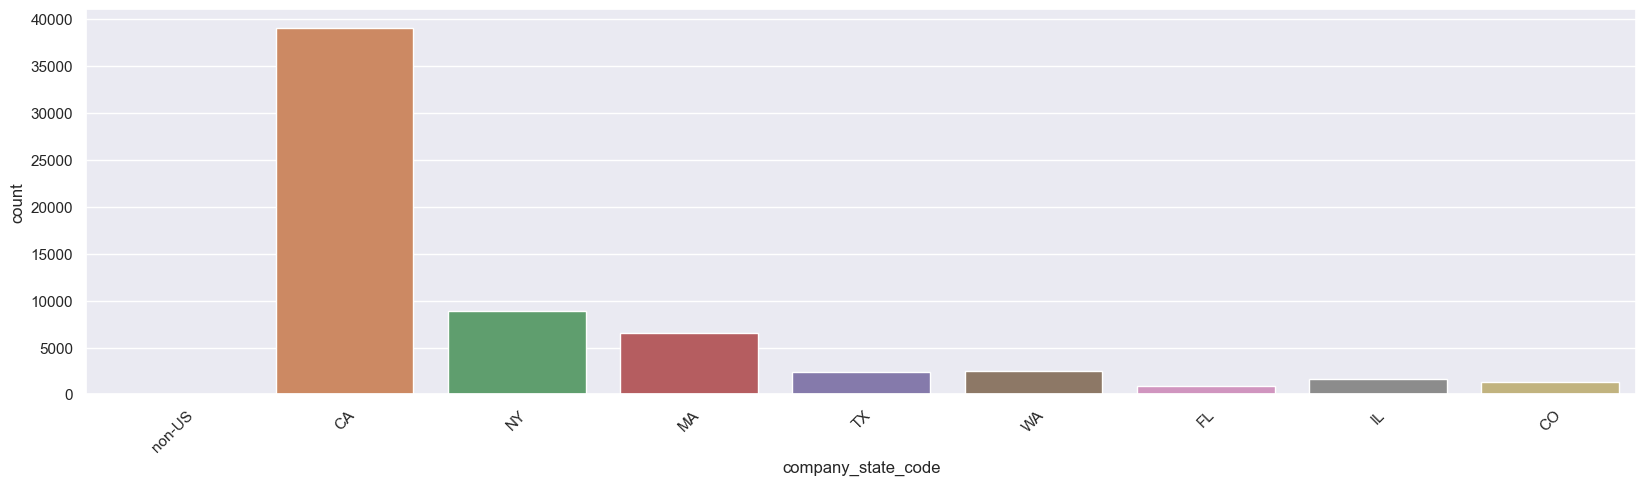

In [119]:
plt.figure(figsize=(20,5))
g = sns.countplot(x ='company_state_code', data = df_inv[(df_inv['company_country_code'] =='USA')], order=df_org['state_code'].value_counts().iloc[:9].index)
plt.xticks(rotation=45)
plt.show()

Similar to parts 2.1 and 2.2, the US is the country in which most start-ups are founded. California leads by a great margin compared to the other states in the US.  

## 2.4 Acquisitions

In [120]:
df_aq.head(10)

,company_permalink,company_name,company_category_list,company_market,company_country_code,company_state_code,company_region,company_city,acquirer_permalink,acquirer_name,acquirer_category_list,acquirer_market,acquirer_country_code,acquirer_state_code,acquirer_region,acquirer_city,acquired_at,acquired_month,acquired_quarter,acquired_year,price_amount,price_currency_code
0,/organization/waywire,#waywire,|Entertainment|Politics|Social Media|News|,News,USA,NY,New York City,New York,/organization/magnify,Waywire Networks,|Curated Web|Video|,Curated Web,USA,NY,New York City,New York,2013-10-17,10,Q4,2013-01-01,NaN,USD
1,/organization/fluff-friends,(fluff)Friends,NaN,NaN,NaN,NaN,NaN,NaN,/organization/social-gaming-network,SGN (Social Gaming Network),|Games|,Games,USA,CA,Los Angeles,Beverly Hills,2008-09-16,09,Q3,2008-01-01,NaN,USD
2,/organization/red,(RED),|Nonprofits|,Nonprofits,USA,NY,New York City,New York,/organization/nationstar-mortgage-holdings,Nationstar Mortgage Holdings,|Finance|,Finance,USA,TX,Dallas,Lewisville,2014-05-08,05,Q2,2014-01-01,18000000.0,USD
3,/organization/vandaele-holdings,.,NaN,NaN,NaN,NaN,NaN,NaN,/organization/hi7e,HI7E,NaN,NaN,USA,FL,Palm Beaches,West Palm Beach,2011-01-01,01,Q1,2011-01-01,NaN,USD
4,/organization/co-internet,.CO,|Registrars|Domains|Curated Web|,Registrars,USA,FL,Miami,Miami,/organization/neustar,Neustar,|Telecommunications|Analytics|Information Tech...,Analytics,USA,VA,"Washington, D.C.",Sterling,2014-03-20,03,Q1,2014-01-01,109000000.0,USD
5,/organization/vantronix,.vantronix,|Cloud Security|Network Security|Security|,Cloud Security,DEU,NaN,Hanover,Hanover,/organization/compumatica,Compumatica,NaN,NaN,NaN,NaN,NaN,NaN,2011-01-01,01,Q1,2011-01-01,NaN,USD
6,/organization/003-ru,003.RU,NaN,NaN,RUS,NaN,Moscow,Moscow,/organization/media-saturn,Media Saturn,|Sales and Marketing|Media|Enterprise Software|,Media,ESP,NaN,Barcelona,Barcelona,2012-07-23,07,Q3,2012-01-01,NaN,USD
7,/organization/0958572-b-c-ltd,0958572 B.C. Ltd.,NaN,NaN,NaN,NaN,NaN,NaN,/organization/atlas-intellectual-property-mana...,ATLAS Intellectual Property Management Co.,|Telecommunications|Mobile|Finance|,Mobile,USA,WA,Seattle,Seattle,2012-02-02,02,Q1,2012-01-01,9000000.0,USD
8,/organization/1-nation-technology,1 Nation Technology,NaN,NaN,NaN,NaN,NaN,NaN,/organization/vology,Vology,NaN,NaN,USA,FL,Tampa,Oldsmar,2006-01-01,01,Q1,2006-01-01,NaN,USD
9,/organization/1-800-contacts,1-800 Contacts,|Consumer Goods|Retail|,Retail,USA,UT,Salt Lake City,Draper,/organization/thomas-h-lee-partners,Thomas H. Lee Partners,|Investment Management|Business Development|Im...,Business Development,USA,MA,Boston,Boston,2014-01-07,01,Q1,2014-01-01,NaN,USD


### 2.4.1 Descriptive statistics

In [121]:
df_aq.describe()

,price_amount
count,3.702000e+03
mean,7.409062e+08
std,4.051974e+09
min,1.000000e+00
25%,1.807500e+07
50%,8.200000e+07
75%,3.400000e+08
max,1.500000e+11


### 2.4.2 Funding aquired by the startups

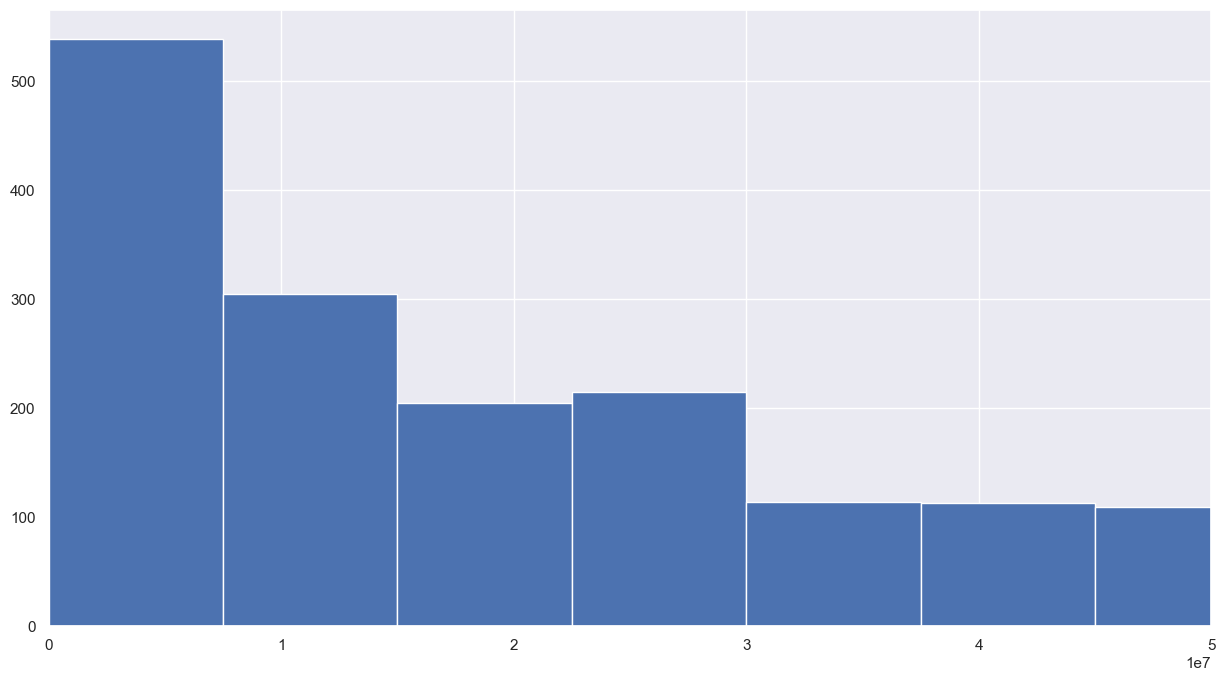

In [122]:
#Runs long! - 60s
#Histogram of total funding aquired by the startups - zoom on the values smaller than 50000000 (50 mln USD)

fig=plt.figure()
ax = fig.add_subplot(1,1,1)
ax.hist(df_aq['price_amount'], bins = 20000)
ax.set_xlim(left=0, right=50000000);

### 2.4.3 Aquisitions over time and by market

Companies that were aquired, 5 top industries highlighted

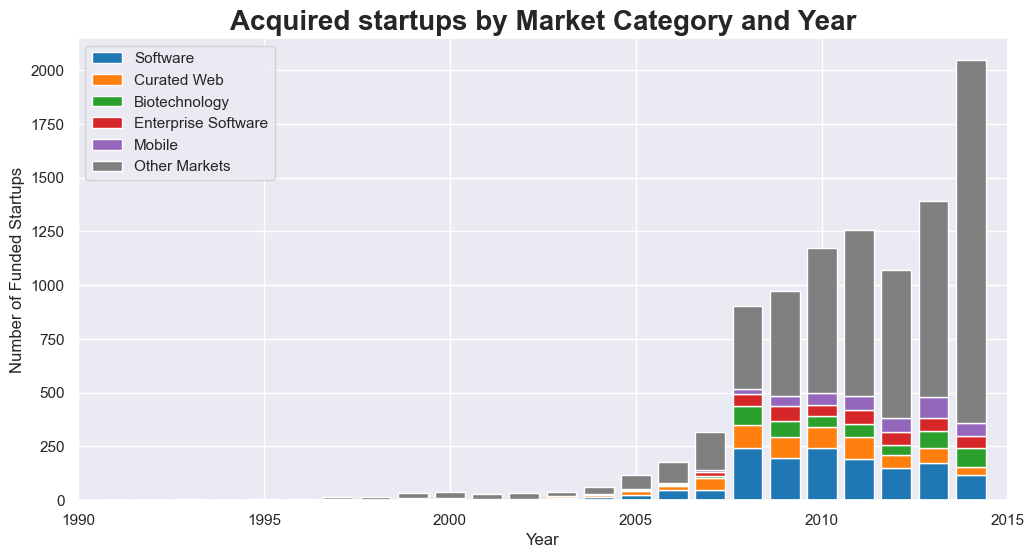

In [123]:
market_counts = df_aq.groupby([df_aq["acquired_at"].dt.year, "company_market"])["company_name"].count().unstack(fill_value=0)

top_10_markets = market_counts.sum().nlargest(5).index.tolist()

for market in top_10_markets:
    market_counts[market] = market_counts[market] if market in market_counts.columns else 0
market_counts["Other"] = market_counts.sum(axis=1) - market_counts[top_10_markets].sum(axis=1)

fig, ax = plt.subplots(figsize=(12, 6))

market_colors = plt.get_cmap('tab10').colors
for i, market in enumerate(top_10_markets):
    ax.bar(market_counts.index, market_counts[market], bottom=market_counts[top_10_markets[:i]].sum(axis=1), color=market_colors[i], label=market)
ax.bar(market_counts.index, market_counts["Other"], bottom=market_counts[top_10_markets].sum(axis=1), color="gray", label="Other Markets")

ax.set_xlim(left=1990, right=2015)

ax.set_xlabel("Year")
ax.set_ylabel("Number of Funded Startups")

ax.set_title("Acquired startups by Market Category and Year", fontdict={'fontsize': 20, 'fontweight': 'bold', 'verticalalignment': 'baseline'}, loc='center')

ax.legend()

plt.show()



Similar trends to previous sections can be observed - most acquired companies are from Software market, and the top 5 market consitutes a great part of all of the acquisitions.

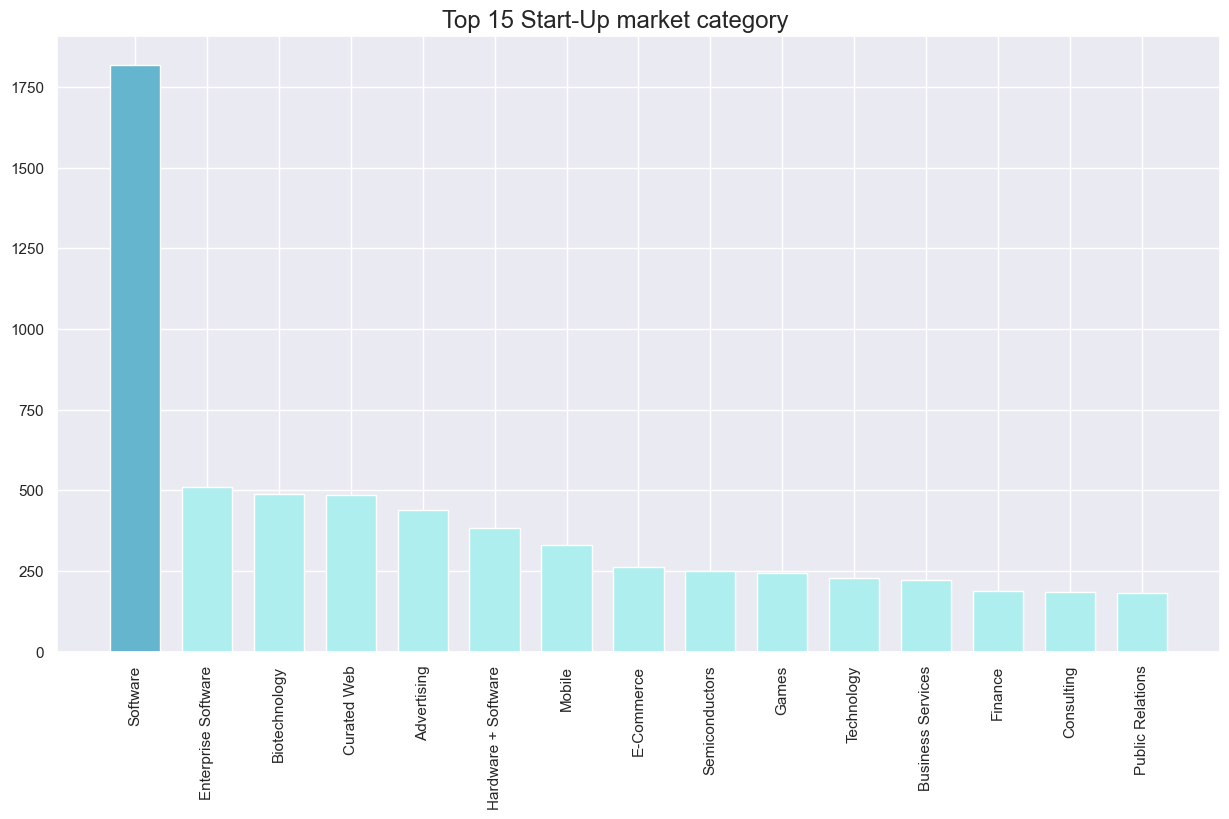

In [124]:
plt.rcParams['figure.figsize'] = 15,8

height = df_aq['acquirer_market'].value_counts()[:15].tolist()
bars =  df_aq['acquirer_market'].value_counts()[:15].index.tolist()
y_pos = np.arange(len(bars))
plt.bar(y_pos, height , width=0.7 ,color= ['c']+['paleturquoise']*14)
plt.xticks(y_pos, bars)
plt.xticks(rotation=90)
plt.title("Top 15 Start-Up market category", fontdict=None, position= [0.48,1.05], size = 'x-large')
plt.show()

Altough the trends observed on the graph above are similar to the previous sections, what is worth noting is that software companies are acquired significantly more often than others.

### 2.4.4 Acquisitions in different countries

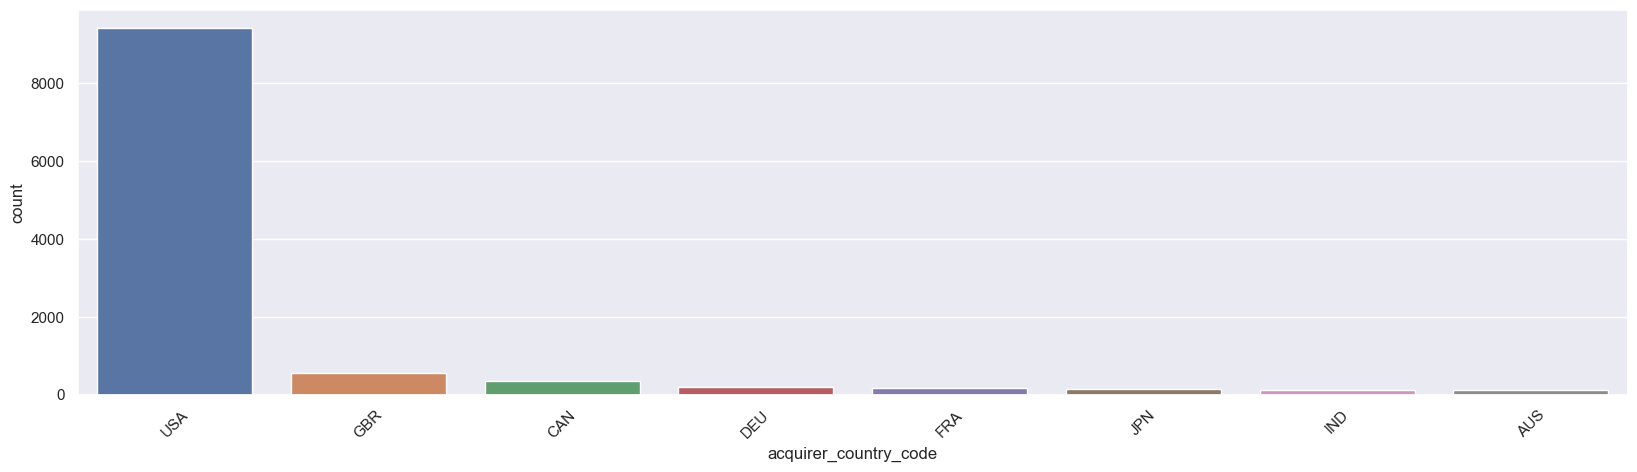

In [125]:
#Country
plt.figure(figsize=(20,5))
sns.countplot(x ='acquirer_country_code', data = df_aq, order=df_aq['acquirer_country_code'].value_counts().iloc[:8].index)
plt.xticks(rotation=45)
plt.show()

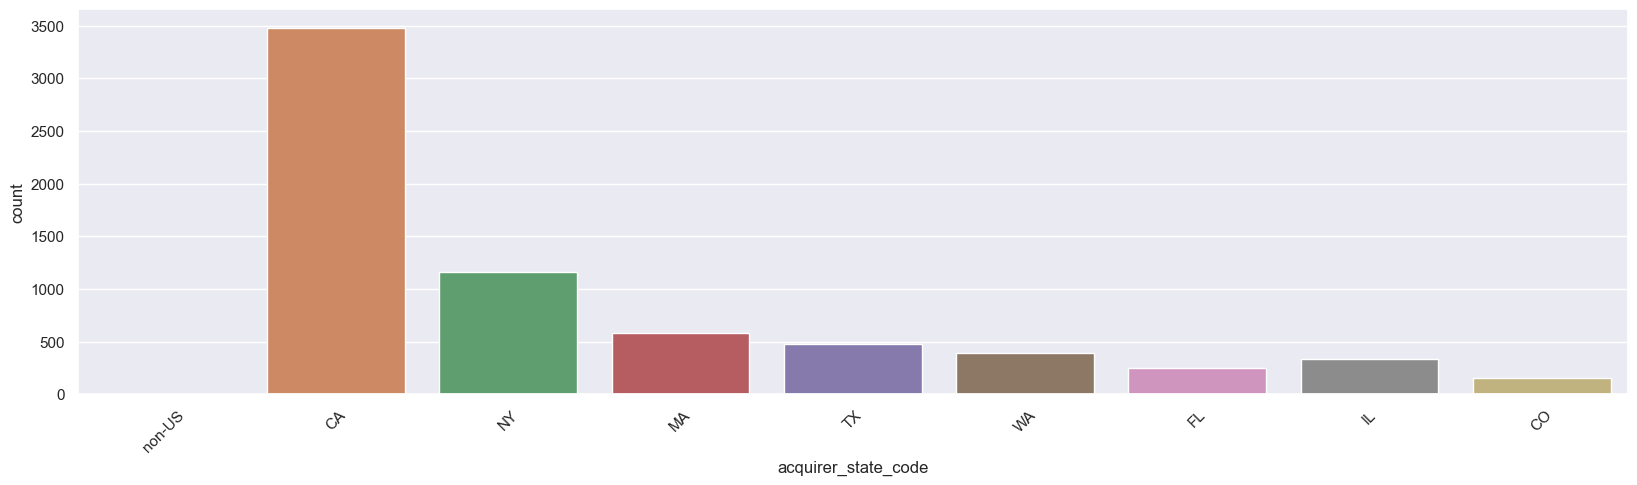

In [126]:
plt.figure(figsize=(20,5))
g = sns.countplot(x ='acquirer_state_code', data = df_aq[(df_aq['acquirer_country_code'] =='USA')], order=df_org['state_code'].value_counts().iloc[:9].index)
plt.xticks(rotation=45)
plt.show()

Similar to parts 2.1 and 2.2, the US is the country in which most start-ups are founded. California leads by a great margin compared to the other states in the US.

### 2.4.5 Aquisitions over quarters

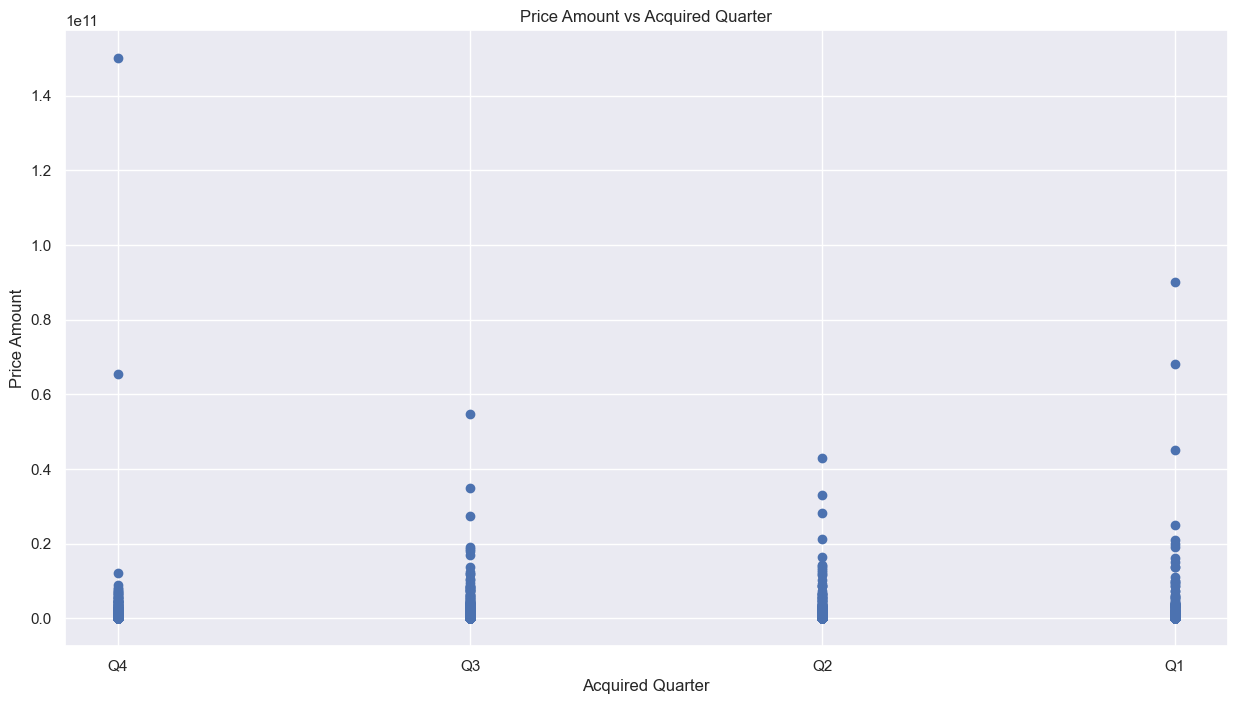

In [127]:
df_aq['acquired_quarter'] = df_aq['acquired_quarter'].astype(str)

plt.scatter(df_aq['acquired_quarter'], df_aq['price_amount'])
plt.xlabel('Acquired Quarter')
plt.ylabel('Price Amount')
plt.title('Price Amount vs Acquired Quarter')
plt.show()

Text(0.5, 1.0, 'target boxplot')

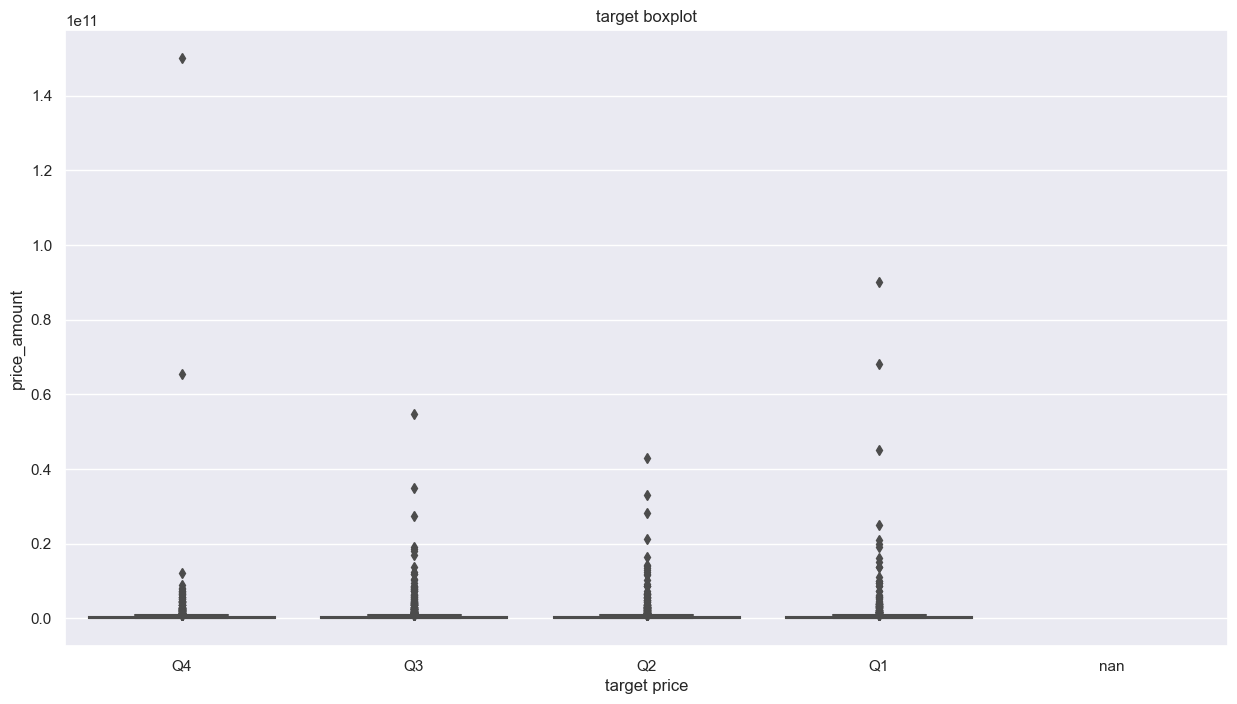

In [128]:
sns.boxplot(x='acquired_quarter', y="price_amount", data=df_aq)
plt.xlabel('target price')
plt.title("target boxplot")



In [129]:
df_aq.groupby(df_aq["acquired_quarter"])["price_amount"].mean()

acquired_quarter
Q1     9.134975e+08
Q2     6.735102e+08
Q3     7.301733e+08
Q4     6.806051e+08
nan             NaN
Name: price_amount, dtype: float64

As seen above, the transaction prices are quite similar in case of quarters 2-4, but in the first quarter the mean acquistion price is much higher.

In [130]:
df_aq.groupby(df_aq["acquired_month"])["price_amount"].mean()

acquired_month
01    7.531400e+08
02    1.078510e+09
03    9.964317e+08
04    5.143202e+08
05    8.096348e+08
06    6.655366e+08
07    7.567170e+08
08    8.056856e+08
09    6.396868e+08
10    8.017209e+08
11    7.839094e+08
12    4.401200e+08
Name: price_amount, dtype: float64

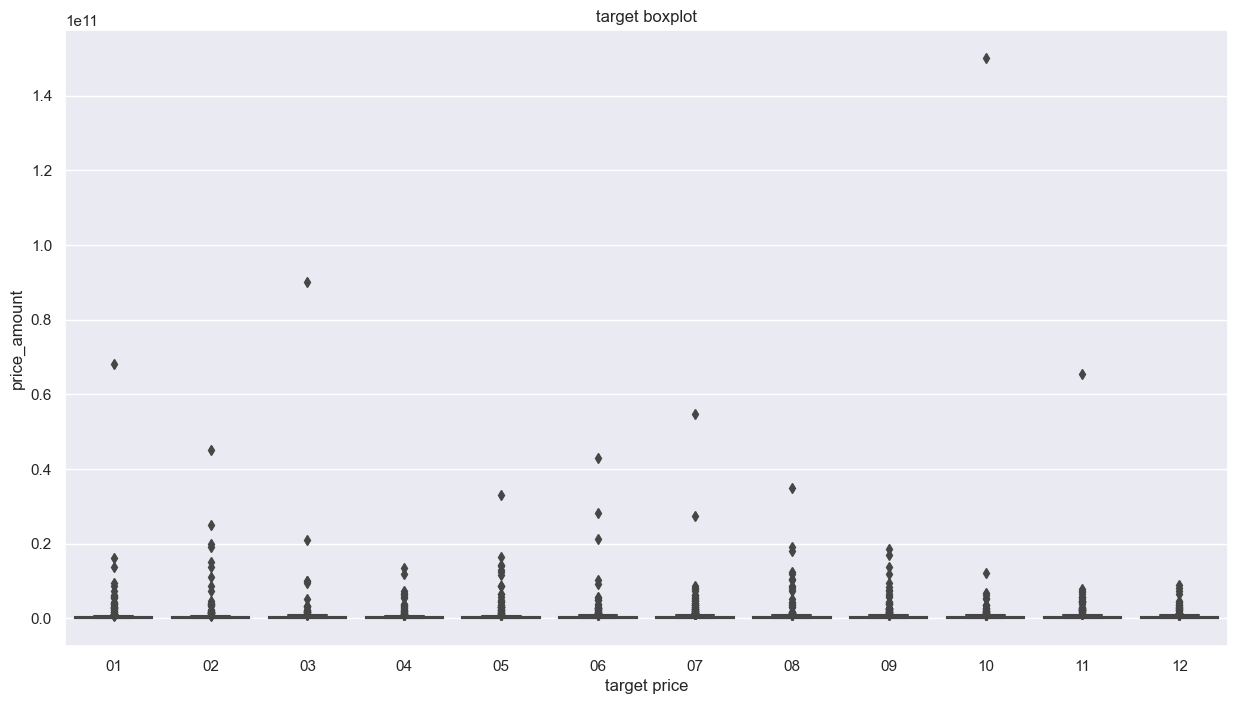

In [131]:
month_order = ["01", "02", "03", "04", "05", "06", "07", "08", "09", "10", "11", "12"]
sns.boxplot(x='acquired_month', y="price_amount", data=df_aq, order=month_order)
plt.xlabel('target price')
plt.title("target boxplot")
plt.show()

# 3. Exploratory Data Analysis - Merged Data Set (df_full)

In the previous section, the four data sets were analyzed individually. After that, the EDA on merged data was conducted (following the code below). Due to the problematic interpreatation of the merged data set (one company can be present in many rows) it was decided that this part is of less importance and should be regarded as an additional material.

So, the following section is quite similar to section 2 in regards to the data exploration. No significant differences important for understanding the data set and future feature engineering were noticed.

In [132]:
#Take a look at the data:
df_full.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 92975 entries, 0 to 92974
Data columns (total 42 columns):
 #   Column                   Non-Null Count  Dtype         
---  ------                   --------------  -----         
 0   permalink                92975 non-null  object        
 1   name                     92975 non-null  object        
 2   homepage_url             90562 non-null  object        
 3   category_list            91874 non-null  object        
 4   market                   92975 non-null  object        
 5   funding_total_usd        92975 non-null  float64       
 6   status                   92975 non-null  object        
 7   country_code             92975 non-null  object        
 8   state_code               92975 non-null  object        
 9   region                   92975 non-null  object        
 10  city                     92975 non-null  object        
 11  funding_rounds           92975 non-null  int64         
 12  founded_at               92975 n

In [133]:
df_full.head()

,permalink,name,homepage_url,category_list,market,funding_total_usd,status,country_code,state_code,region,city,funding_rounds,founded_at,first_funding_at,last_funding_at,funding_round_permalink,funding_round_type,funding_round_code,funded_at,funded_month,funded_quarter,funded_year,raised_amount_usd,acquirer_permalink,acquirer_name,acquirer_category_list,acquirer_market,acquirer_country_code,acquirer_state_code,acquirer_region,acquirer_city,acquired_at,acquired_month,acquired_quarter,acquired_year,price_amount,price_currency_code,investor_permalink,investor_name,investor_country_code,investor_region,investor_city
0,/organization/waywire,#waywire,http://www.waywire.com,|Entertainment|Politics|Social Media|News|,News,1750000.0,acquired,USA,NY,New York City,New York,1,2012-06-01,2012-06-30,2012-06-30,/funding-round/cc409188fa2b63482bd9008f682c2efa,seed,Unknown,2012-06-30,6.0,2.0,2012.0,1750000.0,/organization/magnify,Waywire Networks,|Curated Web|Video|,Curated Web,USA,NY,New York City,New York,2013-10-17,10.0,4.0,2013.0,NaN,USD,/organization/afsquare,AFSquare,USA,Los Angeles,Culver City
1,/organization/waywire,#waywire,http://www.waywire.com,|Entertainment|Politics|Social Media|News|,News,1750000.0,acquired,USA,NY,New York City,New York,1,2012-06-01,2012-06-30,2012-06-30,/funding-round/cc409188fa2b63482bd9008f682c2efa,seed,Unknown,2012-06-30,6.0,2.0,2012.0,1750000.0,/organization/magnify,Waywire Networks,|Curated Web|Video|,Curated Web,USA,NY,New York City,New York,2013-10-17,10.0,4.0,2013.0,NaN,USD,/organization/first-round-capital,First Round,USA,SF Bay Area,San Francisco
2,/organization/waywire,#waywire,http://www.waywire.com,|Entertainment|Politics|Social Media|News|,News,1750000.0,acquired,USA,NY,New York City,New York,1,2012-06-01,2012-06-30,2012-06-30,/funding-round/cc409188fa2b63482bd9008f682c2efa,seed,Unknown,2012-06-30,6.0,2.0,2012.0,1750000.0,/organization/magnify,Waywire Networks,|Curated Web|Video|,Curated Web,USA,NY,New York City,New York,2013-10-17,10.0,4.0,2013.0,NaN,USD,/organization/innovation-endeavors,Innovation Endeavors,USA,SF Bay Area,Palo Alto
3,/organization/rock-your-paper,'Rock' Your Paper,http://www.rockyourpaper.org,|Publishing|Education|,Publishing,40000.0,operating,EST,non-US,Tallinn,Tallinn,1,2012-10-26,2012-08-09,2012-08-09,/funding-round/f06b420775f7cb6c1541a9db526534bb,seed,Unknown,2012-08-09,8.0,3.0,2012.0,40000.0,None,None,None,None,None,None,None,None,NaT,NaN,NaN,NaN,0.0,None,/organization/start-up-chile,Start-Up Chile,CHL,Santiago,Santiago
4,/organization/in-touch-network,(In)Touch Network,http://www.InTouchNetwork.com,|Electronics|Guides|Coffee|Restaurants|Music|i...,Electronics,1500000.0,operating,GBR,non-US,London,London,1,2011-04-01,2011-04-01,2011-04-01,/funding-round/33c3f135f05d7b734b8d7b7c8ae82647,seed,Unknown,2011-04-01,4.0,2.0,2011.0,1500000.0,None,None,None,None,None,None,None,None,NaT,NaN,NaN,NaN,0.0,None,None,None,None,None,None


In [134]:
df_full.shape

(92975, 42)

In [135]:
#Total number of startups
len(df_full['name'].unique())

28691

#### Change the data types and the notation

In [136]:
#Change the format to avoid printing numbers in a scientific format
pd.options.display.float_format = '{:.2f}'.format

#### Descriptive statistics

In [137]:
df_full.describe()

,funding_total_usd,funding_rounds,funded_month,funded_quarter,funded_year,raised_amount_usd,acquired_month,acquired_quarter,acquired_year,price_amount
count,92975.00,92975.00,92975.00,92975.00,92975.00,92975.00,12542.00,12542.00,12542.00,85378.00
mean,42636893.69,3.38,6.36,2.47,2010.77,11791266.77,6.64,2.56,2011.53,32457620.77
std,137951600.80,2.29,3.43,1.11,2.85,46981202.97,3.39,1.10,2.27,1465146241.48
min,14.00,1.00,1.00,1.00,1990.00,0.00,1.00,1.00,1987.00,0.00
25%,2100000.00,2.00,3.00,1.00,2009.00,700000.00,4.00,2.00,2010.00,0.00
50%,11843959.00,3.00,6.00,2.00,2011.00,3500000.00,7.00,3.00,2012.00,0.00
75%,41290000.00,4.00,9.00,3.00,2013.00,12000000.00,10.00,4.00,2013.00,0.00
max,5700000000.00,18.00,12.00,4.00,2014.00,3500000000.00,12.00,4.00,2014.00,150000000000.00


#### Correlation plot

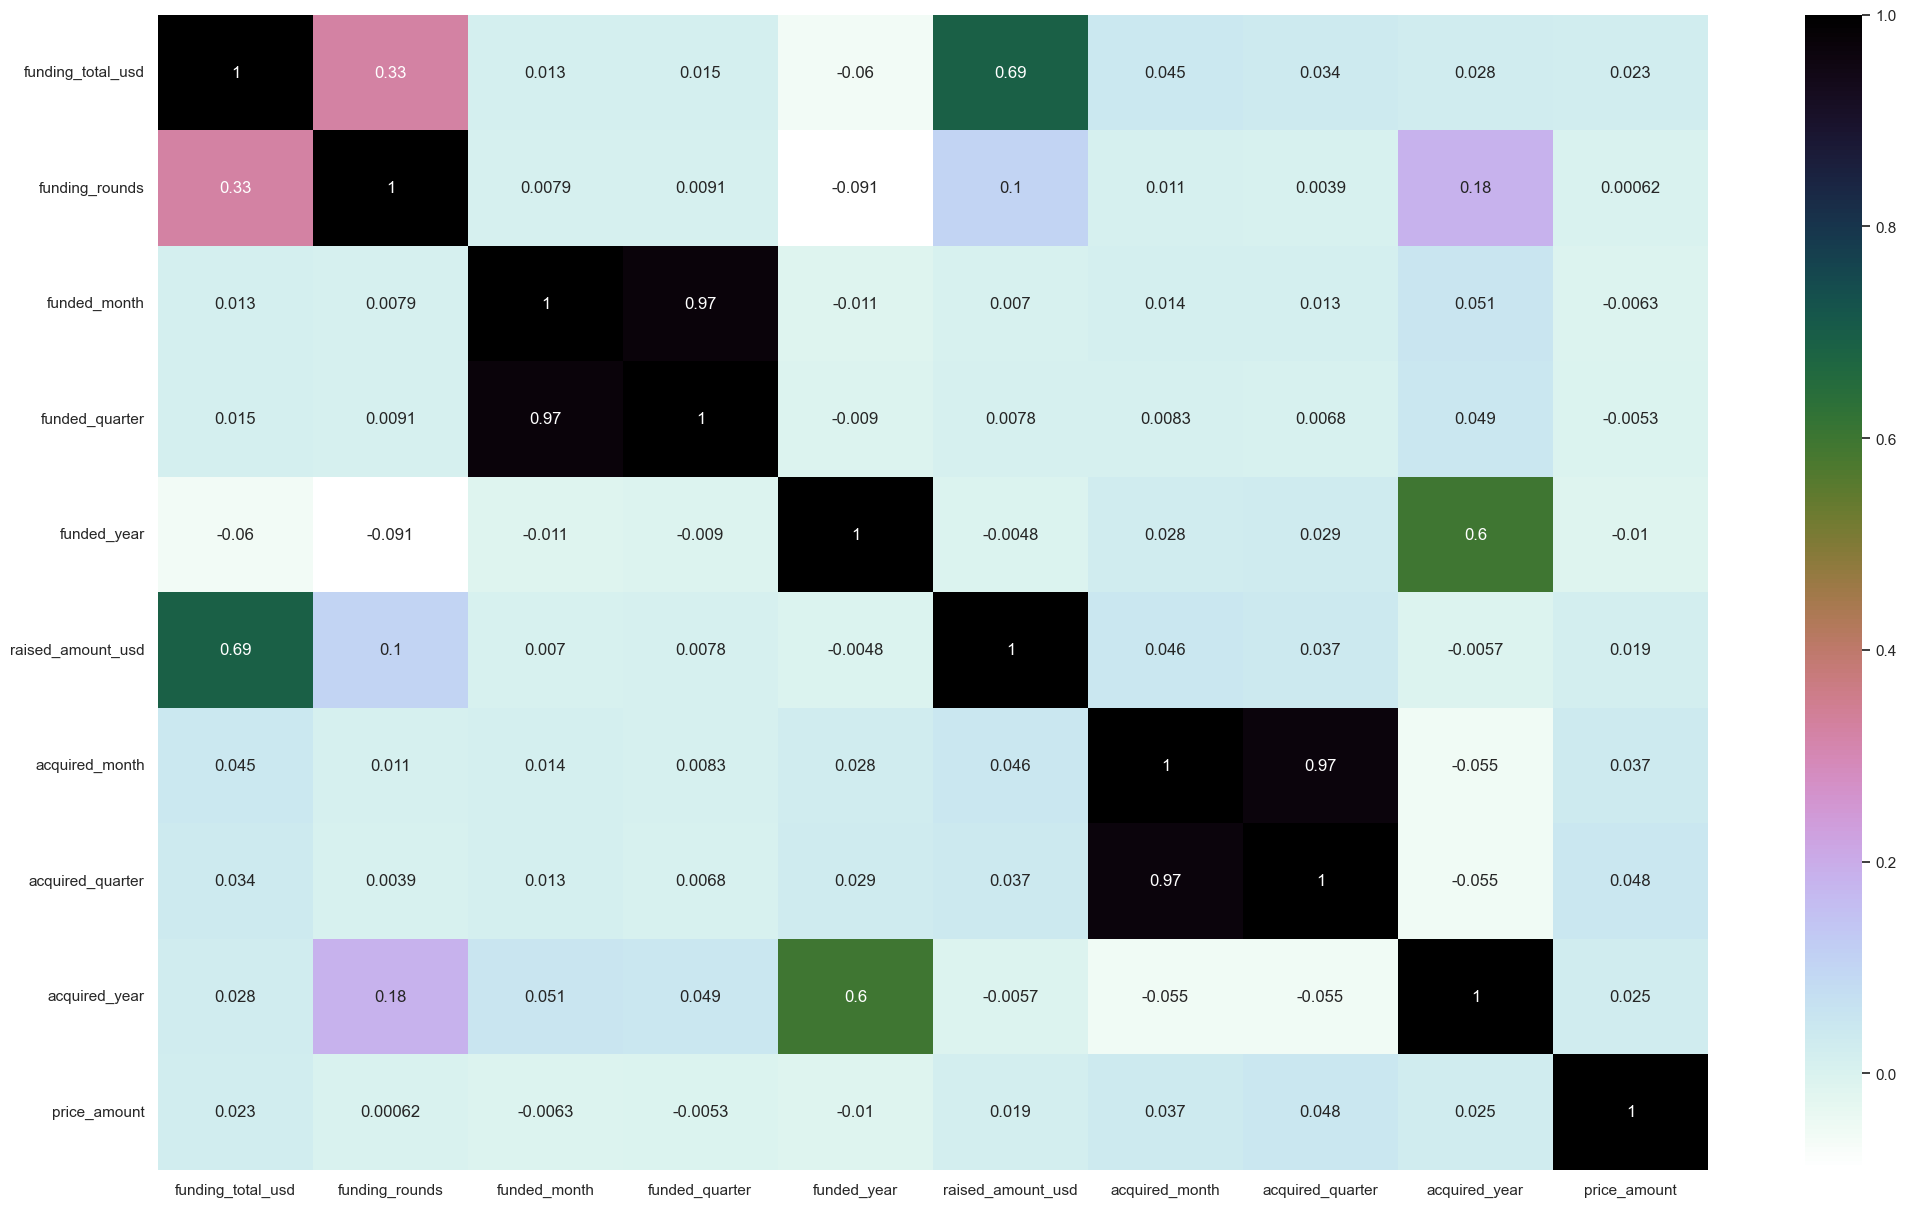

In [138]:
plt.figure(figsize=(25,15)) 
sns.heatmap(df_full.corr(),annot=True,cmap='cubehelix_r') 
plt.show()

#### Funding aquired by the startups

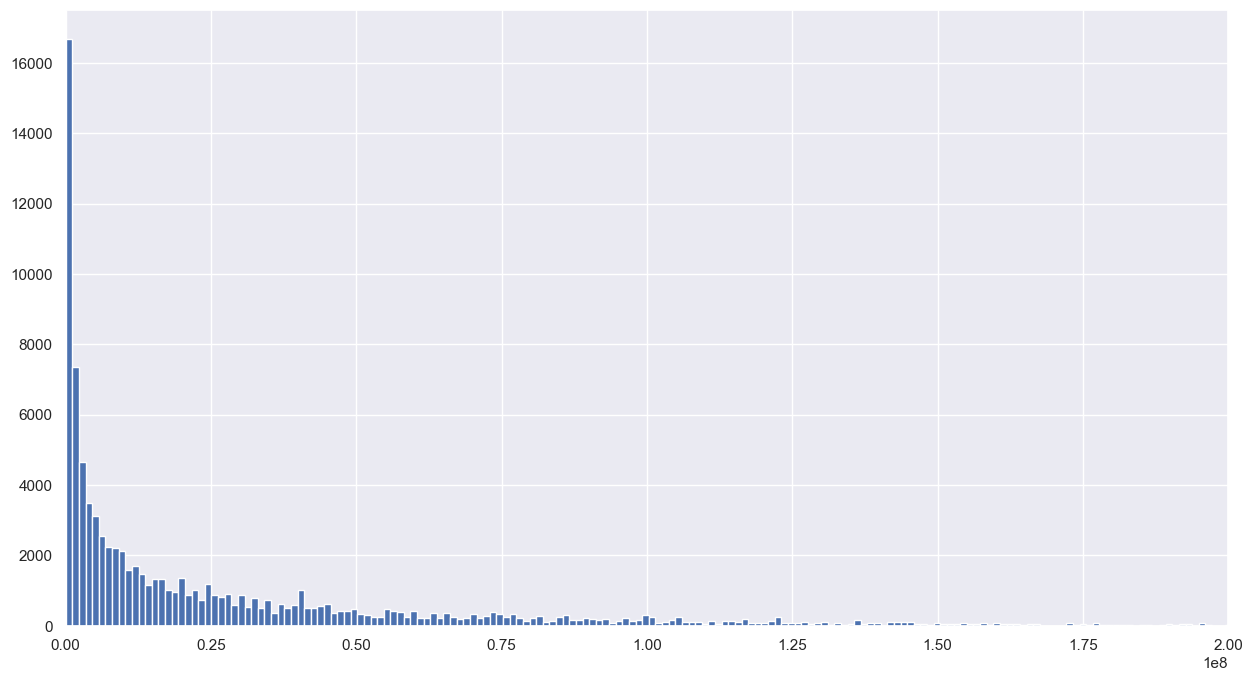

In [139]:
#Histogram of total funding aquired by the startups

fig=plt.figure()
ax = fig.add_subplot(1,1,1)
ax.hist(df_full['funding_total_usd'], bins = 5000)
ax.set_xlim(left=0, right=200000000);

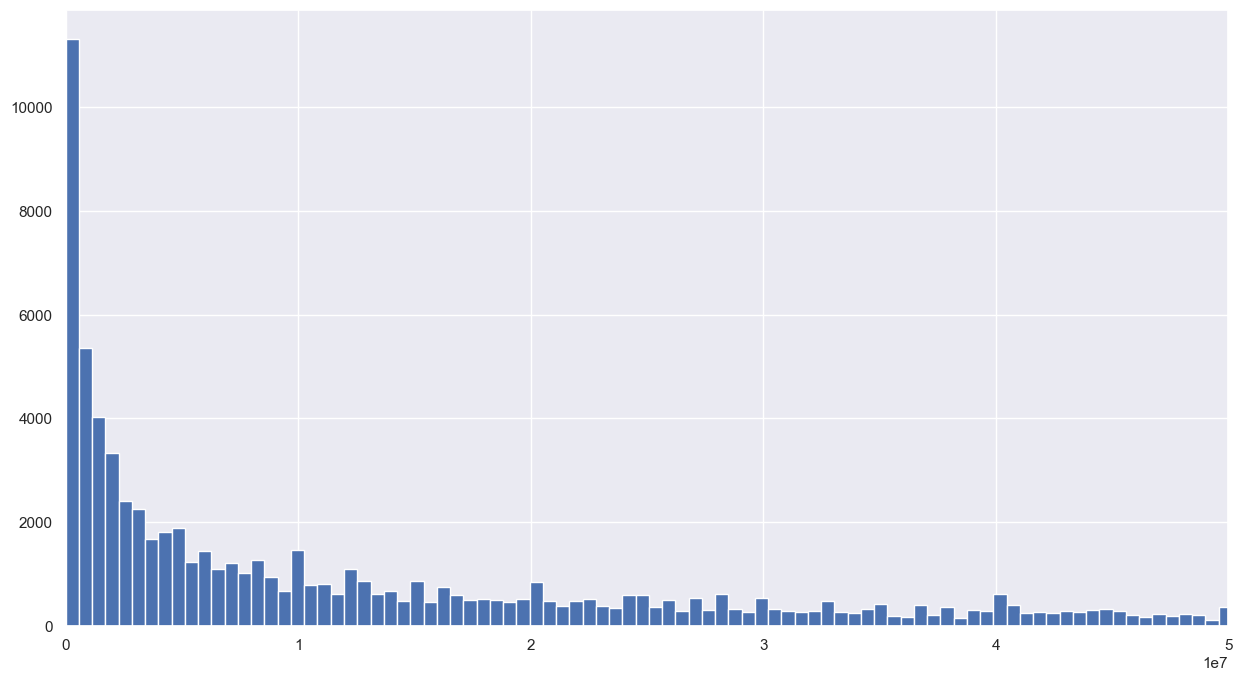

In [140]:
#Histogram of total funding aquired by the startups - zoom on the values smaller than 50000000

fig=plt.figure()
ax = fig.add_subplot(1,1,1)
ax.hist(df_full['funding_total_usd'], bins = 10000)
ax.set_xlim(left=0, right=50000000);

#### Top startups

In [141]:
pd.set_option('display.max_columns', None)

#### Status of the start-ups

In [142]:
df_full['status'].value_counts()

operating    75664
acquired     12449
closed        3361
Unknown       1501
Name: status, dtype: int64

#### Total funding by the market

In [143]:
len(df_full['market'].unique())

699

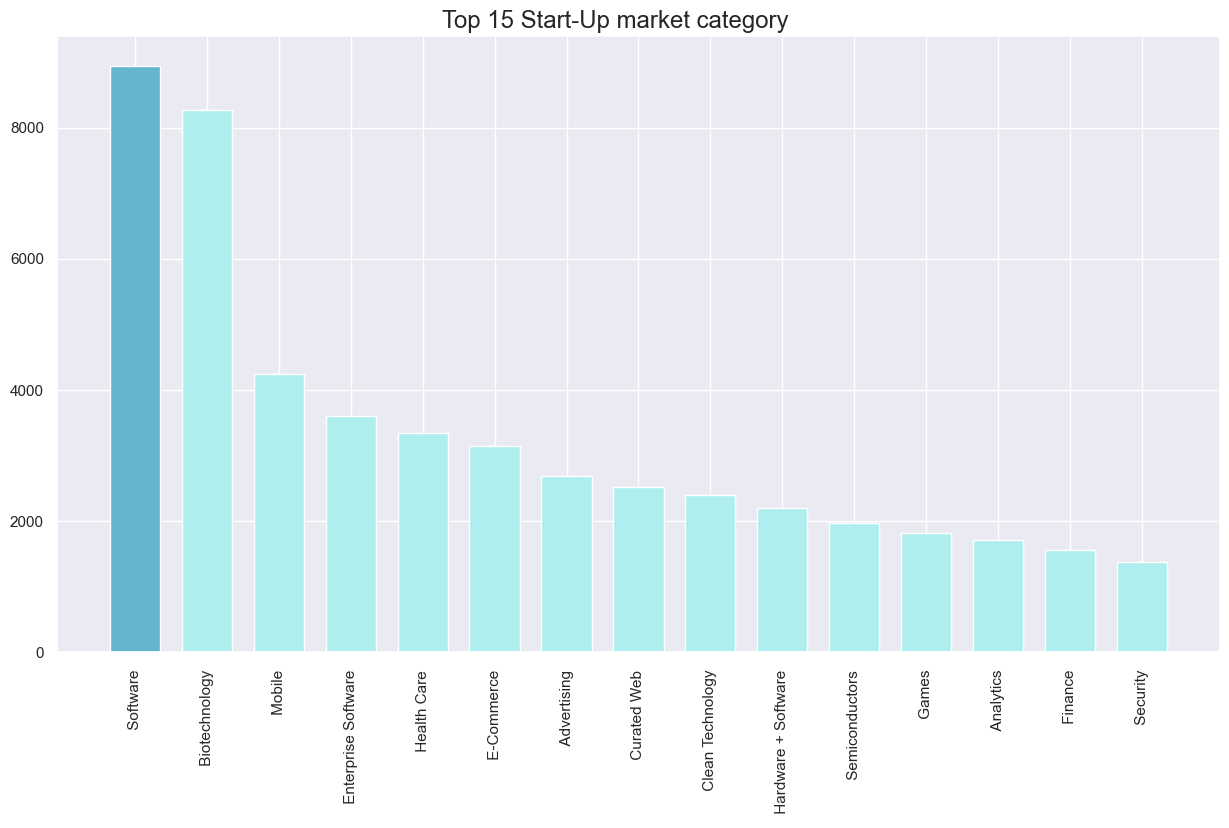

In [144]:
plt.rcParams['figure.figsize'] = 15,8

height = df_full['market'].value_counts()[:15].tolist()
bars =  df_full['market'].value_counts()[:15].index.tolist()
y_pos = np.arange(len(bars))
plt.bar(y_pos, height , width=0.7 ,color= ['c']+['paleturquoise']*14)
plt.xticks(y_pos, bars)
plt.xticks(rotation=90)
plt.title("Top 15 Start-Up market category", fontdict=None, position= [0.48,1.05], size = 'x-large')
plt.show()

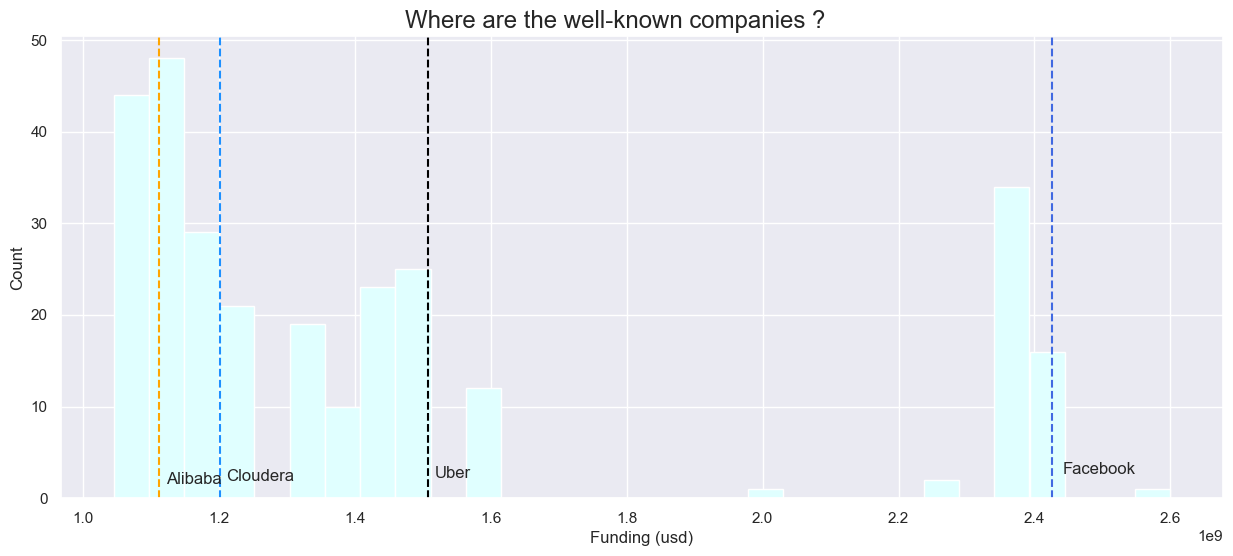

In [145]:
Facebook_total_funding = df_full['funding_total_usd'][df_full['name']=="Facebook"].values[0]
Uber_total_funding = df_full['funding_total_usd'][df_full['name']=="Uber"].values[0]
Alibaba_total_funding = df_full['funding_total_usd'][df_full['name']=="Alibaba"].values[0]
Cloudera_total_funding = df_full['funding_total_usd'][df_full['name']=="Cloudera"].values[0]

plt.rcParams['figure.figsize'] = 15,6

plt.hist(df_full['funding_total_usd'][(df_full['funding_total_usd'] >= 1000000000)&(df_full['funding_total_usd'] <= 3000000000)].dropna(), bins=30,color = 'lightcyan' )
plt.ylabel('Count')
plt.xlabel('Funding (usd)')
plt.title("Where are the well-known companies ? ", fontdict=None, position= [0.48,1.05], size = 'x-large')

plt.axvline(Facebook_total_funding,color='royalblue',linestyle ="--")
plt.text(Facebook_total_funding+15000000, 2.6,"Facebook")

plt.axvline(Uber_total_funding,color='black',linestyle ="--")
plt.text(Uber_total_funding+10000000, 2.2,"Uber")

plt.axvline(Cloudera_total_funding,color='dodgerblue',linestyle ="--")
plt.text(Cloudera_total_funding+10000000, 1.9,"Cloudera")

plt.axvline(Alibaba_total_funding,color='orange',linestyle ="--")
plt.text(Alibaba_total_funding+10000000, 1.6,"Alibaba")
#plt.ticklabel_format(style='plain')



plt.show()

#### How was the distribution of the funding given the economic events

In [146]:
df_full['founded_at'] = pd.to_datetime(df_full['founded_at'])

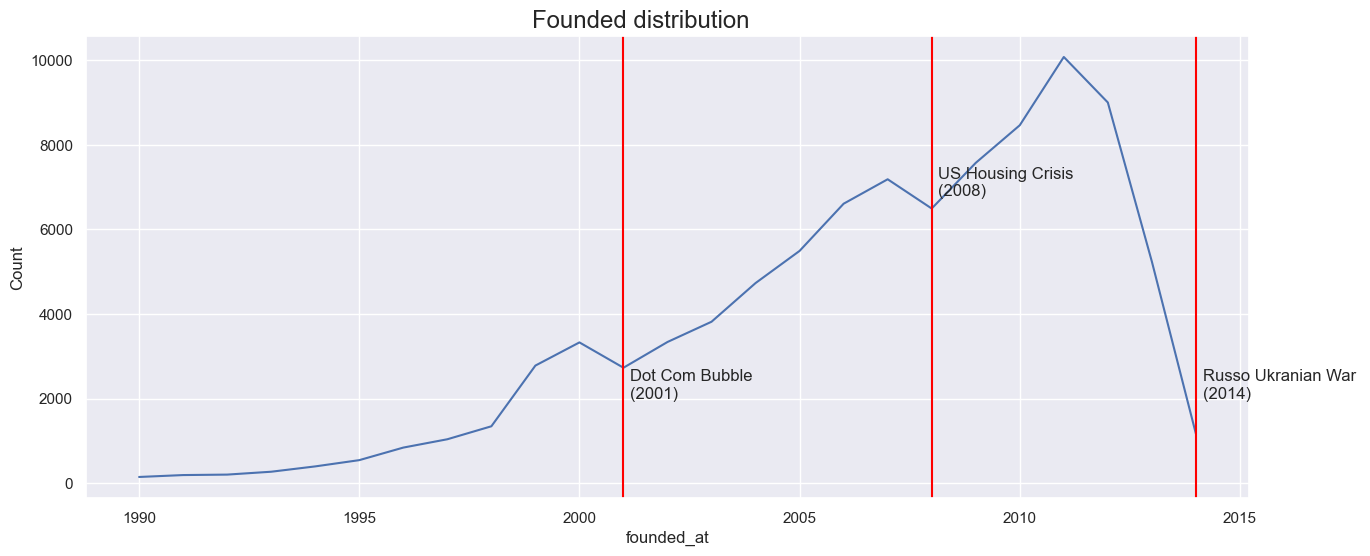

In [147]:
plt.rcParams['figure.figsize'] = 15,6
df_full['name'].groupby(df_full["founded_at"].dt.year).count().plot(kind="line")

plt.ylabel('Count')
plt.title("Founded distribution ", fontdict=None, position= [0.48,1.05], size = 'x-large')

plt.axvline(2008,color='red')
plt.text(2008+0.15, 6800,"US Housing Crisis \n(2008)")

plt.axvline(2001,color='red')
plt.text(2001+0.15, 2000,"Dot Com Bubble \n(2001)")

plt.axvline(2014,color='red')
plt.text(2014+0.15, 2000,"Russo Ukranian War \n(2014)")
plt.show()

### When the companies were founded?

In [148]:
df_full['founded_at'] = pd.to_datetime(df_full['founded_at'], errors = 'coerce' )

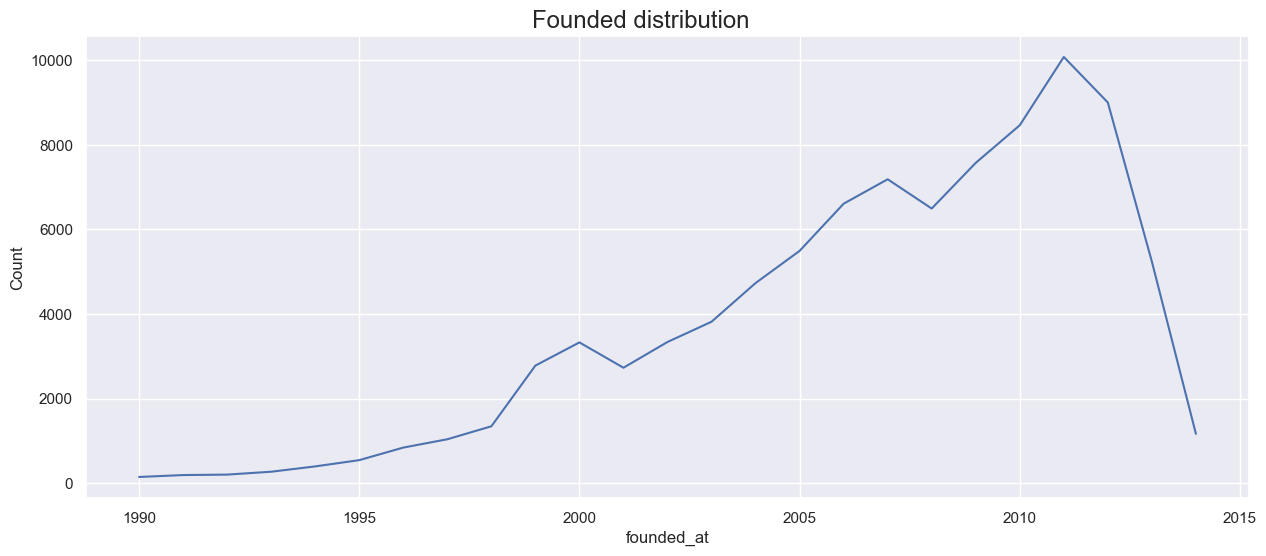

In [149]:
plt.rcParams['figure.figsize'] = 15,6
df_full['name'].groupby(df_full["founded_at"].dt.year).count().plot(kind="line")

plt.ylabel('Count')
plt.title("Founded distribution ", fontdict=None, position= [0.48,1.05], size = 'x-large')
plt.show()

In [150]:
Facebook_founded_year = df_full['founded_at'][df_full['name']=="Facebook"].dt.year.values[0]
Uber_founded_year  = df_full['founded_at'][df_full['name']=="Uber"].dt.year.values[0]
Alibaba_founded_year  = df_full['founded_at'][df_full['name']=="Alibaba"].dt.year.values[0]

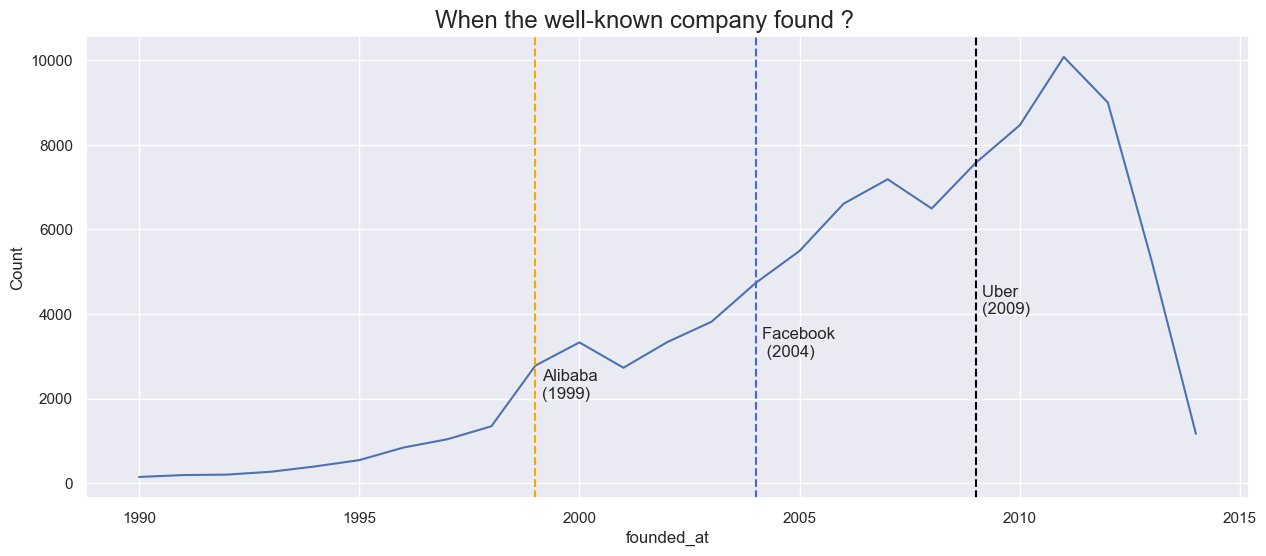

In [151]:
plt.rcParams['figure.figsize'] = 15,6
df_full['name'][df_full["founded_at"].dt.year >= 1990].groupby(df_full["founded_at"].dt.year).count().plot(kind="line")
plt.ylabel('Count')

plt.axvline(Facebook_founded_year,color='royalblue',linestyle ="--")
plt.text(Facebook_founded_year+0.15, 3000,"Facebook \n (2004)")

plt.axvline(Uber_founded_year,color='black',linestyle ="--")
plt.text(Uber_founded_year+0.15, 4000,"Uber \n(2009)")

plt.axvline(Alibaba_founded_year,color='orange',linestyle ="--")
plt.text(Alibaba_founded_year+0.15, 2000,"Alibaba \n(1999)")


plt.title("When the well-known company found ?", fontdict=None, position= [0.48,1.05], size = 'x-large')
plt.show()

### The markets

In [152]:
df_full['count'] = 1
country_market = df_full[['count','country_code','market']].groupby(['country_code','market']).agg({'count': 'sum'})
# Change: groupby state_office and divide by sum
country_market_pct = country_market.groupby(level=0).apply(lambda x:
                                                 100 * x / float(x.sum()))
country_market_pct.reset_index(inplace = True)

In [153]:
USA_market_pct = country_market_pct[country_market_pct['country_code'] == "USA"]
USA_market_pct = USA_market_pct.sort_values('count',ascending = False)[0:10]

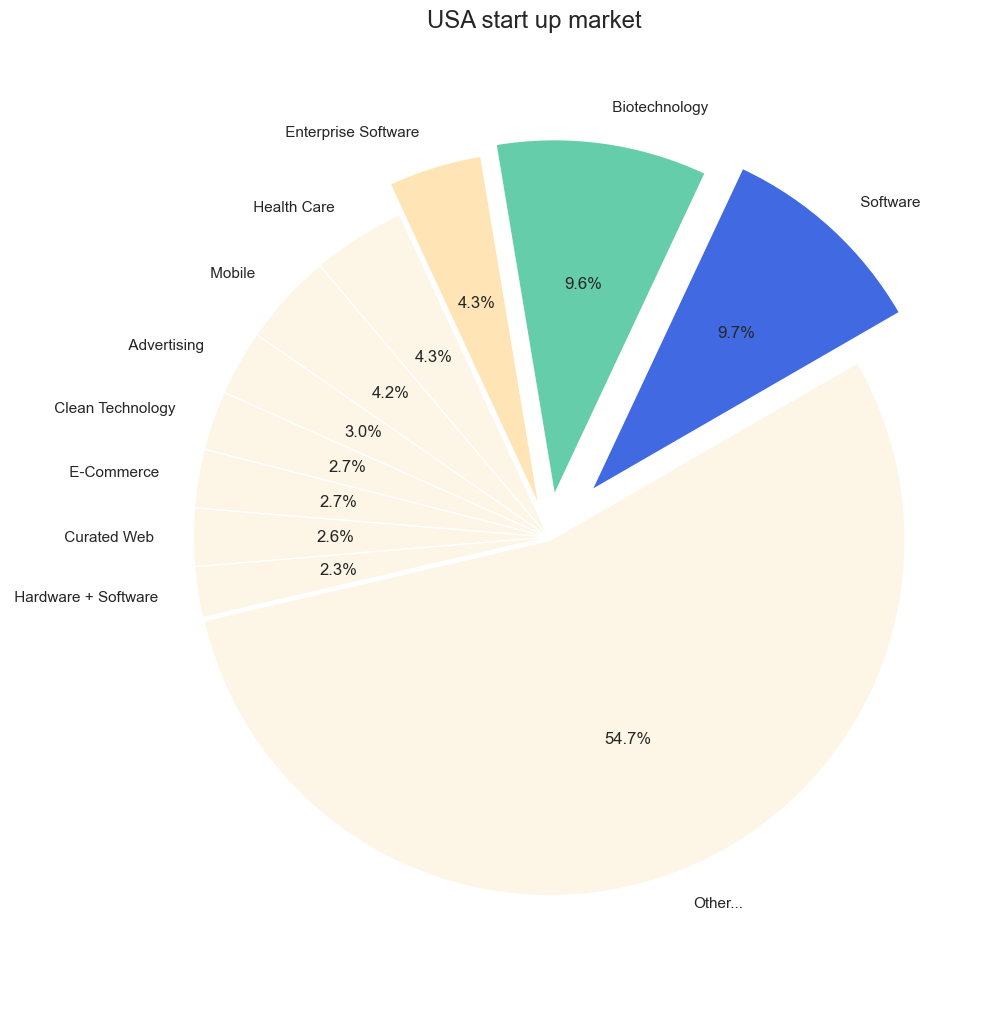

In [154]:
## USA
plt.rcParams['figure.figsize'] =10,10
labels = list(USA_market_pct['market'])+['Other...']
sizes = list(USA_market_pct['count'])+[100-USA_market_pct['count'].sum()]
explode = (0.18, 0.12, 0.09,0,0,0,0,0,0,0,0.01)
colors =  ['royalblue','mediumaquamarine','moccasin'] +['oldlace']*8

plt.pie(sizes, explode = explode, colors = colors ,labels=labels, autopct='%1.1f%%',
        shadow=False, startangle=30)
plt.axis('equal')
plt.tight_layout()
plt.title("USA start up market", fontdict=None, position= [0.48,1.1], size = 'x-large')

plt.show()


### How much money

In [155]:
#Create the df_grouped data frame which will be used for external data analysis
df_grouped = df_full.groupby(df_full["founded_at"].dt.year)["funding_total_usd"].sum()
df_grouped

founded_at
1990     4169342642.00
1991     8901484873.00
1992     8057518008.00
1993    17825153905.00
1994    16934811392.00
1995    25451402526.00
1996    38136106768.00
1997    52428626215.00
1998    81268762033.00
1999   168529098443.00
2000   168282162698.00
2001   162132973190.00
2002   194858682529.00
2003   328955688913.00
2004   349801391103.00
2005   349938094844.00
2006   394532356895.00
2007   508688996149.00
2008   300408598205.00
2009   292717792366.00
2010   192033550194.00
2011   164939984813.00
2012    98656922054.00
2013    32167563558.00
2014     4348126652.00
Name: funding_total_usd, dtype: float64

In [156]:
#Top invested categories, can be compared with the graph above including the total number of startups
df_full.groupby('market').sum()['funding_total_usd'].sort_values(ascending=False).head()

market
 Biotechnology       407960374116.00
 Software            243689637122.00
 Clean Technology    219826708786.00
 Health Care         193440615746.00
 E-Commerce          178065866512.00
Name: funding_total_usd, dtype: float64

### Country Analyses

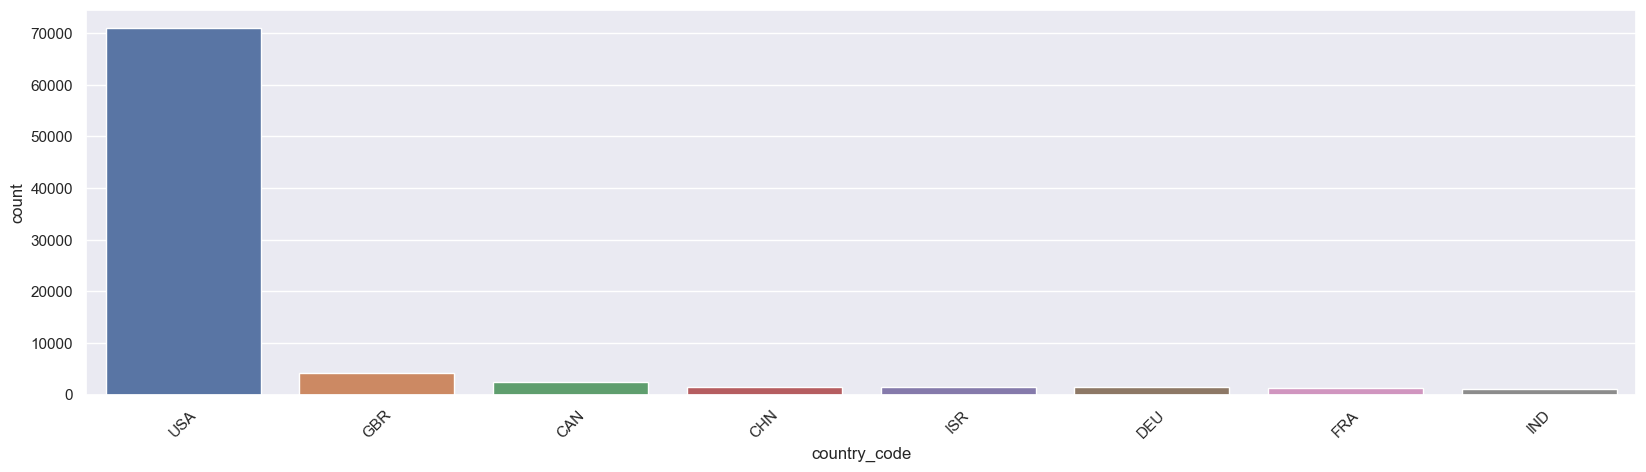

In [157]:
#Country
plt.figure(figsize=(20,5))
sns.countplot(x ='country_code', data = df_full, order=df_full['country_code'].value_counts().iloc[:8].index)
plt.xticks(rotation=45)
plt.show()

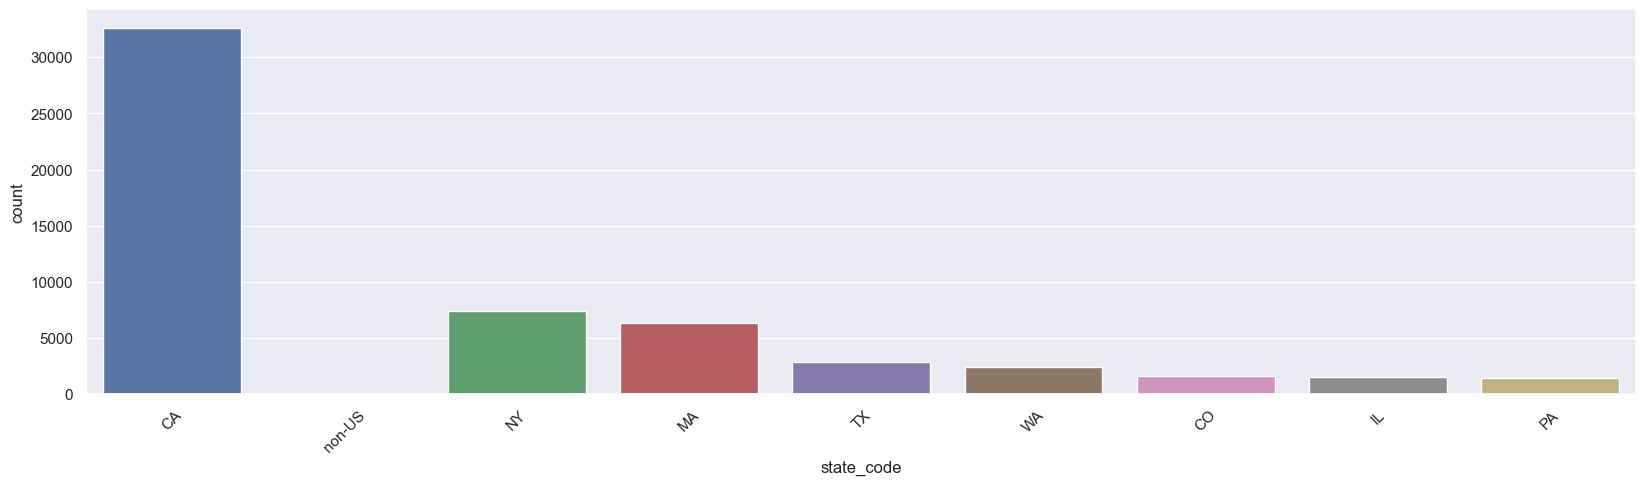

In [158]:
plt.figure(figsize=(20,5))
g = sns.countplot(x ='state_code', data = df_full[(df_full['country_code'] =='USA')], order=df_full['state_code'].value_counts().iloc[:9].index)
plt.xticks(rotation=45)
plt.show()

### Markets

c:\Users\piotr\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


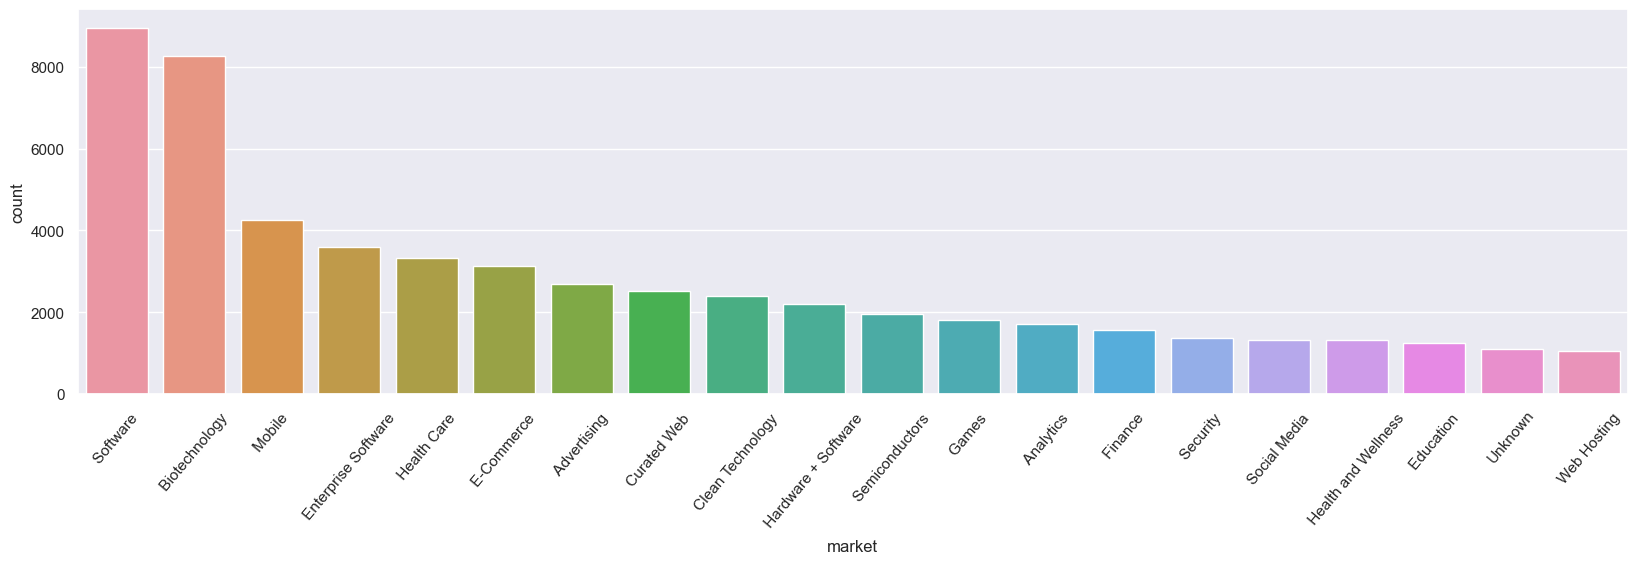

In [159]:
fig,axes = plt.subplots(1,1,figsize=(20,5))
sns.countplot(df_full.market, order = df_full.market.value_counts()[:20].index)
plt.xticks(rotation = 50)
plt.show()

# 4. External Factors Analysis

In this section, external data on USA's GDP and unemploument rate were added to the merged data frame.

Key insights from this section are as follows:

1) Both of the economic crises (dot com bubble and housing crisis) clearly hurt the amount of startups that were founded, halting the growth curve
2) Funding and GDP seemed to increase at a very similar rate from 1990 to 2009 until the GDP kept on increasing and the total funding started decreasing
3) Unlike GDP,  unemployment and funding seemed to have a negative correlation until 2000 where as funding increased, unemployment decreased, however after the low of 2000, both unemployment and funding started increasing and decreasing together



In [160]:
### PLEASE CHANGE THE WORKING/FILE DIRECTORY! THANK YOU
#US GDP data
us_gdp = pd.read_csv('C:\\Users\\piotr\\OneDrive - Erasmus University Rotterdam\\Documents\\Github repositories\\group-project-2023-project-group-7\\Data Exploration\\us_gdp.csv')
us_gdp = us_gdp[(us_gdp['label'] >= 1990) & (us_gdp['label'] <= 2014)]

In [161]:
### PLEASE CHANGE THE WORKING/FILE DIRECTORY! THANK YOU
#US Unemployment data
us_unemp = pd.read_csv('C:\\Users\\piotr\\OneDrive - Erasmus University Rotterdam\\Documents\\Github repositories\\group-project-2023-project-group-7\\Data Exploration\\us_unemp.csv')
us_unemp = us_unemp.groupby(us_unemp['label'].str[:4])['Unemployment Rate'].mean()
us_unemp = us_unemp.loc['1990':'2014']
us_unemp.index = us_unemp.index.astype('int64')

#### GDP and Funding

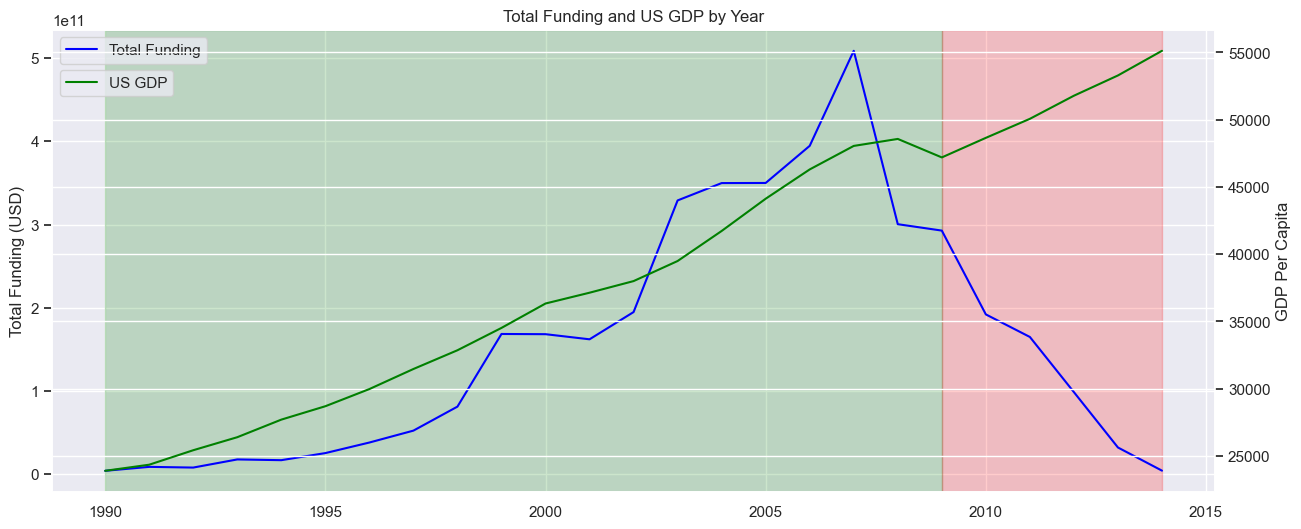

In [162]:
#create a new figure and axes
fig, ax1 = plt.subplots(figsize=(15,6))
ax1.plot(df_grouped.index, df_grouped.values, color='blue')
ax1.set_ylabel('Total Funding (USD)')

#create a second axis
ax2 = ax1.twinx()
ax2.plot(us_gdp['label'], us_gdp['GDP Per Capita'], color='green')
ax2.set_ylabel('GDP Per Capita')

#title and legend
ax1.set_title('Total Funding and US GDP by Year')
ax1.legend(['Total Funding'], loc='upper left', bbox_to_anchor=(0, 1))
ax2.legend(['US GDP'], loc='upper left', bbox_to_anchor=(0, 0.93))

#Highlight the correlation
ax1.axvspan(1990, 2009, alpha=0.2, color='green')
ax1.axvspan(2009, 2014, alpha=0.2, color='red')

plt.show()


As seen above, total funding for start-ups and US GDP increased together from 1990 to 2008. Both saw a decrease at 2009, however afterwards, the GDP kept on increasing whereas the funding kept on decreasing. The green and red backgrounds illustrate the positive and negative correlation, respectively.

#### US Unemployment and Funding

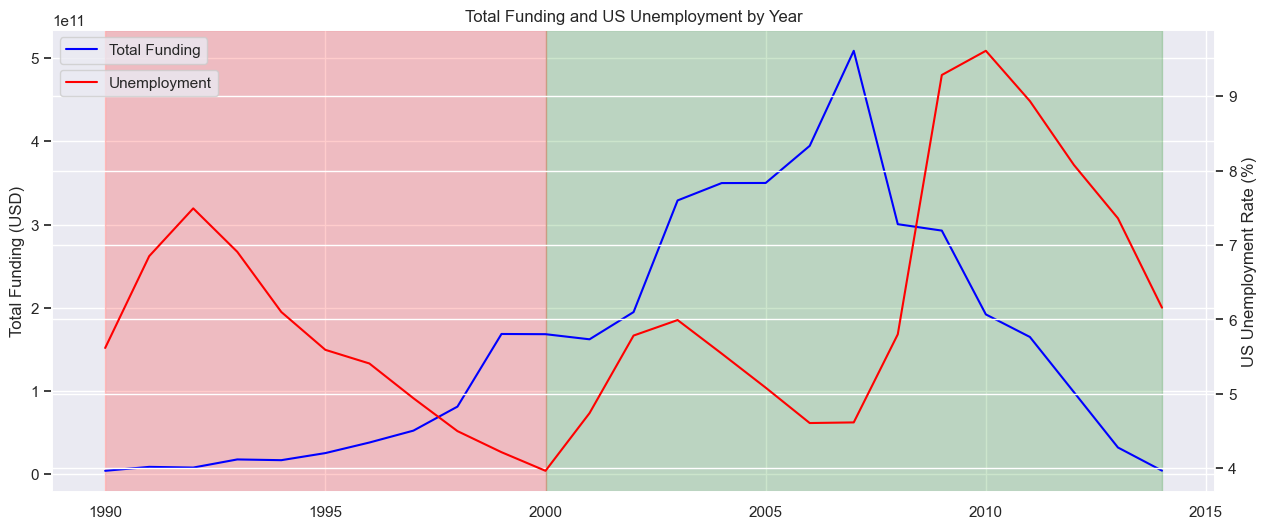

In [163]:
#create a new figurea and axes
fig, ax1 = plt.subplots(figsize=(15,6))
ax1.plot(df_grouped.index, df_grouped.values, color='blue')
ax1.set_ylabel('Total Funding (USD)')

#create a second axis
ax2 = ax1.twinx()
ax2.plot(us_unemp.index, us_unemp.values, color='red')
ax2.set_ylabel('US Unemployment Rate (%)')

#title and legend
ax1.set_title('Total Funding and US Unemployment by Year')
ax1.legend(['Total Funding'], loc='upper left', bbox_to_anchor=(0, 1))
ax2.legend(['Unemployment'], loc='upper left', bbox_to_anchor=(0, 0.93))

#Highlight the correlation
ax1.axvspan(2000, 2014, alpha=0.2, color='green')
ax1.axvspan(1990, 2000, alpha=0.2, color='red')

plt.show()


Once again, the green and red backgrounds show positive and negative correlation between total funding and unemployment. Until the year 2000, there seems to be a negative correlation with total funding increasing and unemployment decreasing. However, after 2000, both start increasing together and start decreasing together.